# **Paper Implementation**

https://academic.oup.com/gigascience/article/6/7/gix034/3796323

# **1. EEG Data 접속**

In [ ]:
# Google Colab 사용 시 파일 접근 시 경로 필요.
#구글 경로 접속
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **1.1 필요한 라이브러리 설치**

In [1]:
# 관련 라이브러리 설치
# 여기서는 snntorch 라이브러리
%pip install snntorch

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install mne

Note: you may need to restart the kernel to use updated packages.


## **1.2 라이브러리 import**

In [1]:
# 라이브러리 import
import pandas as pd
import numpy as np
import os
from scipy.signal import detrend
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import snntorch
import snntorch.spikegen as spikegen
import mne
from mne.preprocessing import compute_current_source_density

# **2. EEG Data File Check**

In [2]:
# 파일 경로
EEG_Data_File_Path = "C:/Users/user/Desktop/EEG Data"

In [5]:
# 해당 폴더 내의 모든 .csv 파일 목록 생성
csv_files = [file for file in os.listdir(EEG_Data_File_Path) if file.endswith('.csv')]

In [3]:
# 해당 폴더 내의 모든 .csv 파일 목록 중 imagery_left와 imagery_right 파일만 선택
imagery_csv_files = [file for file in os.listdir(EEG_Data_File_Path) if file.endswith('.csv') and ('imagery_left' in file or 'imagery_right' in file)]

In [4]:
# 해당 폴더 내의 모든 .csv 파일 목록 중 movement_left와 movement_right 파일만 선택
movement_csv_files = [file for file in os.listdir(EEG_Data_File_Path) if file.endswith('.csv') and ('movement_left' in file or 'movement_right' in file)]

csv_files는 EEG Data의 각 Trial Data로, 총 4,830개의 Trial Data가 존재함.

In [6]:
imagery_csv_files

['imagery_left_s01_mat_block1.csv',
 'imagery_left_s01_mat_block10.csv',
 'imagery_left_s01_mat_block100.csv',
 'imagery_left_s01_mat_block11.csv',
 'imagery_left_s01_mat_block12.csv',
 'imagery_left_s01_mat_block13.csv',
 'imagery_left_s01_mat_block14.csv',
 'imagery_left_s01_mat_block15.csv',
 'imagery_left_s01_mat_block16.csv',
 'imagery_left_s01_mat_block17.csv',
 'imagery_left_s01_mat_block18.csv',
 'imagery_left_s01_mat_block19.csv',
 'imagery_left_s01_mat_block2.csv',
 'imagery_left_s01_mat_block20.csv',
 'imagery_left_s01_mat_block21.csv',
 'imagery_left_s01_mat_block22.csv',
 'imagery_left_s01_mat_block23.csv',
 'imagery_left_s01_mat_block24.csv',
 'imagery_left_s01_mat_block25.csv',
 'imagery_left_s01_mat_block26.csv',
 'imagery_left_s01_mat_block27.csv',
 'imagery_left_s01_mat_block28.csv',
 'imagery_left_s01_mat_block29.csv',
 'imagery_left_s01_mat_block3.csv',
 'imagery_left_s01_mat_block30.csv',
 'imagery_left_s01_mat_block31.csv',
 'imagery_left_s01_mat_block32.csv',
 'i

In [7]:
movement_csv_files

['movement_left_s01_mat_block1.csv',
 'movement_left_s01_mat_block10.csv',
 'movement_left_s01_mat_block11.csv',
 'movement_left_s01_mat_block12.csv',
 'movement_left_s01_mat_block13.csv',
 'movement_left_s01_mat_block14.csv',
 'movement_left_s01_mat_block15.csv',
 'movement_left_s01_mat_block16.csv',
 'movement_left_s01_mat_block17.csv',
 'movement_left_s01_mat_block18.csv',
 'movement_left_s01_mat_block19.csv',
 'movement_left_s01_mat_block2.csv',
 'movement_left_s01_mat_block20.csv',
 'movement_left_s01_mat_block3.csv',
 'movement_left_s01_mat_block4.csv',
 'movement_left_s01_mat_block5.csv',
 'movement_left_s01_mat_block6.csv',
 'movement_left_s01_mat_block7.csv',
 'movement_left_s01_mat_block8.csv',
 'movement_left_s01_mat_block9.csv',
 'movement_left_s03_mat_block1.csv',
 'movement_left_s03_mat_block10.csv',
 'movement_left_s03_mat_block11.csv',
 'movement_left_s03_mat_block12.csv',
 'movement_left_s03_mat_block13.csv',
 'movement_left_s03_mat_block14.csv',
 'movement_left_s03_ma

이에, 여기서 피험자 별로 데이터를 나눔. s01, s03과 같은 피험자별로 데이터를 나눔.
추후에 마지막 classification에 각 피험자별 데이터를 모델에 적용시키기 위함.

In [5]:
# Assuming csv_files is directly a list of filenames
def group_by_subject(csv_files):
    subject_data = {}
    
    for file in csv_files:  # Directly iterating through the list of filenames
        # Extract subject ID from the filename (assuming the format contains 's01', 's03', etc.)
        subject_id = file.split('_')[2]  # This extracts the subject identifier, e.g., 's01'
        
        # Add file to the corresponding subject group
        if subject_id not in subject_data:
            subject_data[subject_id] = []
        subject_data[subject_id].append(file)
    
    return subject_data


In [6]:
# Now, simply call the function with csv_files
imagery_grouped_files = group_by_subject(imagery_csv_files)

In [7]:
# Now, simply call the function with csv_files
movement_grouped_files = group_by_subject(movement_csv_files)

In [11]:
# Display the grouped data for each subject
imagery_grouped_files

{'s01': ['imagery_left_s01_mat_block1.csv',
  'imagery_left_s01_mat_block10.csv',
  'imagery_left_s01_mat_block100.csv',
  'imagery_left_s01_mat_block11.csv',
  'imagery_left_s01_mat_block12.csv',
  'imagery_left_s01_mat_block13.csv',
  'imagery_left_s01_mat_block14.csv',
  'imagery_left_s01_mat_block15.csv',
  'imagery_left_s01_mat_block16.csv',
  'imagery_left_s01_mat_block17.csv',
  'imagery_left_s01_mat_block18.csv',
  'imagery_left_s01_mat_block19.csv',
  'imagery_left_s01_mat_block2.csv',
  'imagery_left_s01_mat_block20.csv',
  'imagery_left_s01_mat_block21.csv',
  'imagery_left_s01_mat_block22.csv',
  'imagery_left_s01_mat_block23.csv',
  'imagery_left_s01_mat_block24.csv',
  'imagery_left_s01_mat_block25.csv',
  'imagery_left_s01_mat_block26.csv',
  'imagery_left_s01_mat_block27.csv',
  'imagery_left_s01_mat_block28.csv',
  'imagery_left_s01_mat_block29.csv',
  'imagery_left_s01_mat_block3.csv',
  'imagery_left_s01_mat_block30.csv',
  'imagery_left_s01_mat_block31.csv',
  'imag

In [12]:
movement_grouped_files

{'s01': ['movement_left_s01_mat_block1.csv',
  'movement_left_s01_mat_block10.csv',
  'movement_left_s01_mat_block11.csv',
  'movement_left_s01_mat_block12.csv',
  'movement_left_s01_mat_block13.csv',
  'movement_left_s01_mat_block14.csv',
  'movement_left_s01_mat_block15.csv',
  'movement_left_s01_mat_block16.csv',
  'movement_left_s01_mat_block17.csv',
  'movement_left_s01_mat_block18.csv',
  'movement_left_s01_mat_block19.csv',
  'movement_left_s01_mat_block2.csv',
  'movement_left_s01_mat_block20.csv',
  'movement_left_s01_mat_block3.csv',
  'movement_left_s01_mat_block4.csv',
  'movement_left_s01_mat_block5.csv',
  'movement_left_s01_mat_block6.csv',
  'movement_left_s01_mat_block7.csv',
  'movement_left_s01_mat_block8.csv',
  'movement_left_s01_mat_block9.csv',
  'movement_right_s01_mat_block1.csv',
  'movement_right_s01_mat_block10.csv',
  'movement_right_s01_mat_block11.csv',
  'movement_right_s01_mat_block12.csv',
  'movement_right_s01_mat_block13.csv',
  'movement_right_s01_m

# **3. Methods**

## **3.1 Method 이전 단계**

In [8]:
# Sampling frequency and filter parameters
sfreq = 512  # Sampling Frequency, 512 Hz
l_freq = 8 # low frequency band-pass
h_freq = 30 # high frequency band-pass
filter_order = 4  # Filter order for Butterworth filtering

### **3.1.1 Imagery Data**

In [ ]:
# Dictionary to store preprocessed data for each subject
imagery_preprocessed_data = {}

# Step 1: Preprocessing - Apply Butterworth high-pass and band-pass filtering for each subject
for subject, files in imagery_grouped_files.items():
    subject_preprocessed_data = []

    for file_idx, file in enumerate(files):
        # Load the data from the file (assuming each file corresponds to a CSV of EEG trial data)
        file_path = os.path.join(EEG_Data_File_Path, file)
        data = pd.read_csv(file_path, header=None).values
        
        # 채널 1~64 추출 (인덱스 0~63)
        eeg_data = data[:64, :]

        # Use mne to create RawArray object for further processing
        ch_names = [str(i) for i in range(1, eeg_data.shape[0] + 1)]
        info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')
        raw = mne.io.RawArray(eeg_data, info)

        # Apply band-pass filter (8Hz to 30Hz) using Butterworth filter with 4th order to focus on the desired frequency band
        raw_filtered = raw.copy().filter(l_freq=l_freq, h_freq=h_freq, method='iir', iir_params={'order': filter_order, 'ftype': 'butter'})

        # Append the preprocessed data for the current file
        subject_preprocessed_data.append(raw_filtered)

    # Store the preprocessed data for this subject
    imagery_preprocessed_data[subject] = subject_preprocessed_data

In [ ]:
imagery_preprocessed_data

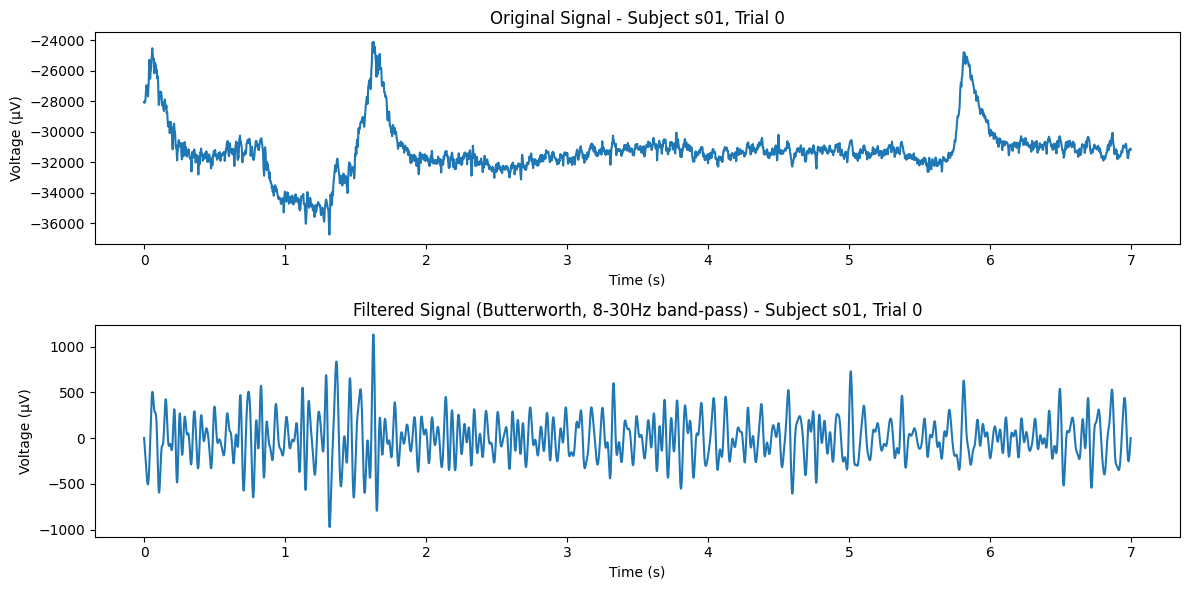

1132.058223238775
-972.8547228828975


In [13]:
import matplotlib.pyplot as plt
import numpy as np

# 시각화할 피험자와 trial 선택 (예: s01의 첫 번째 trial)
subject = 's01'
trial_idx = 0

file_path = os.path.join(EEG_Data_File_Path, imagery_grouped_files[subject][trial_idx])
data = pd.read_csv(file_path, header=None).values

# 필터링 전 trial 데이터 가져오기
original_trial_data = data

# 필터링 후 trial 데이터 가져오기
filtered_trial_data = imagery_preprocessed_data[subject][trial_idx]._data

# Time axis 설정 (샘플 수에 따른 초 단위 변환)
time_axis = np.arange(original_trial_data.shape[1]) / sfreq

# 필터링 전 신호 시각화
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time_axis, original_trial_data[0, :])
plt.title(f'Original Signal - Subject {subject}, Trial {trial_idx}')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (µV)')

# 필터링 후 신호 시각화
plt.subplot(2, 1, 2)
plt.plot(time_axis, filtered_trial_data[0, :])
plt.title(f'Filtered Signal (Butterworth, 8-30Hz band-pass) - Subject {subject}, Trial {trial_idx}')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (µV)')

plt.tight_layout()
plt.show()

print(filtered_trial_data[0, :].max())
print(filtered_trial_data[0, :].min())

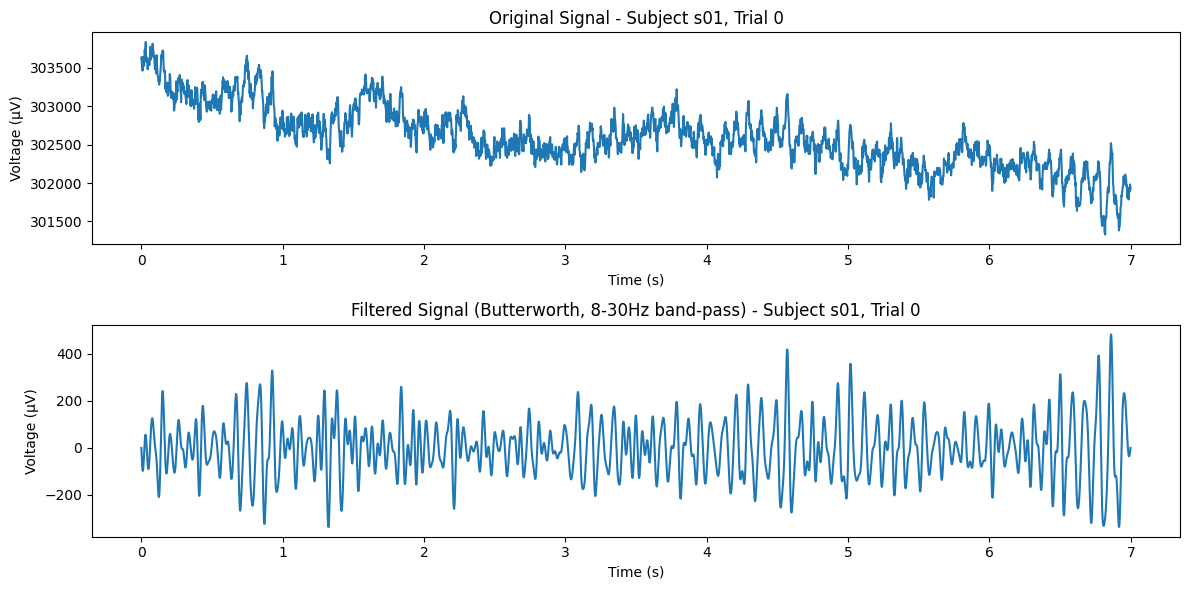

483.0520121726398
-337.1160218533635


In [11]:
import matplotlib.pyplot as plt
import numpy as np

# 시각화할 피험자와 trial 선택 (예: s01의 첫 번째 trial)
subject = 's01'
trial_idx = 0

file_path = os.path.join(EEG_Data_File_Path, imagery_grouped_files[subject][trial_idx])
data = pd.read_csv(file_path, header=None).values

# 필터링 전 trial 데이터 가져오기
original_trial_data = data

# 필터링 후 trial 데이터 가져오기
filtered_trial_data = imagery_preprocessed_data[subject][trial_idx]._data

# Time axis 설정 (샘플 수에 따른 초 단위 변환)
time_axis = np.arange(original_trial_data.shape[1]) / sfreq

# 필터링 전 신호 시각화
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time_axis, original_trial_data[12, :])  # 13 번째 채널 신호
plt.title(f'Original Signal - Subject {subject}, Trial {trial_idx}')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (µV)')

# 필터링 후 신호 시각화
plt.subplot(2, 1, 2)
plt.plot(time_axis, filtered_trial_data[12, :])  # 13 번째 채널 신호
plt.title(f'Filtered Signal (Butterworth, 8-30Hz band-pass) - Subject {subject}, Trial {trial_idx}')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (µV)')

plt.tight_layout()
plt.show()

print(filtered_trial_data[12, :].max())
print(filtered_trial_data[12, :].min())

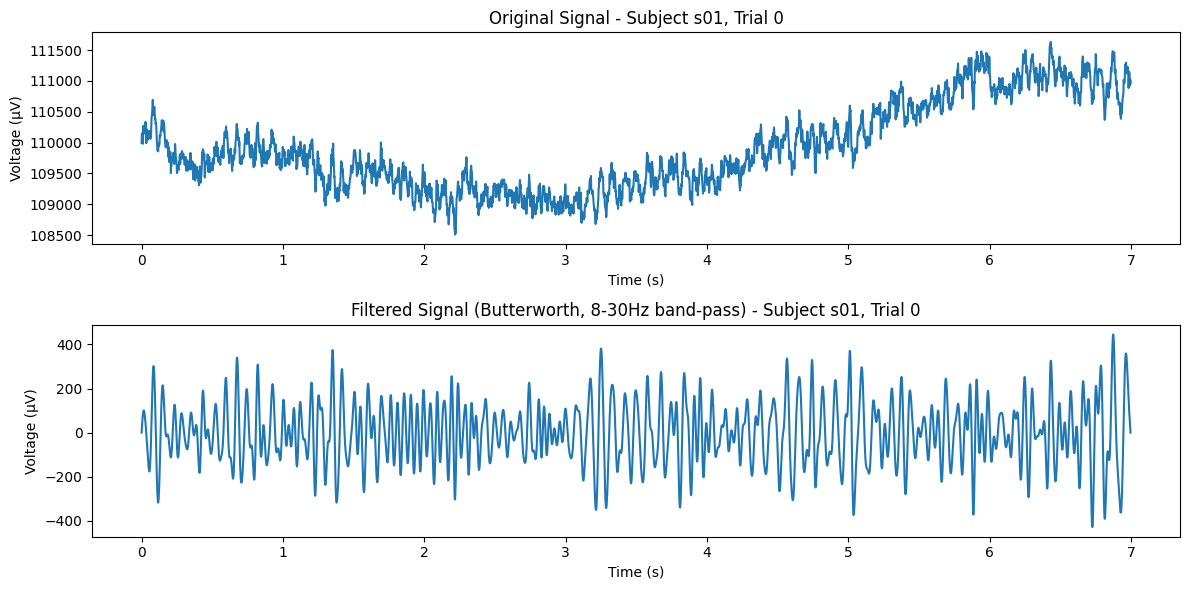

445.4987896477815
-428.47035727146346


In [12]:
# 시각화할 피험자와 trial 선택 (예: s01의 첫 번째 trial)
subject = 's01'
trial_idx = 0

file_path = os.path.join(EEG_Data_File_Path, imagery_grouped_files[subject][trial_idx])
data = pd.read_csv(file_path, header=None).values

# 필터링 전 trial 데이터 가져오기
original_trial_data = data

# 필터링 후 trial 데이터 가져오기
filtered_trial_data = imagery_preprocessed_data[subject][trial_idx]._data

# Time axis 설정 (샘플 수에 따른 초 단위 변환)
time_axis = np.arange(original_trial_data.shape[1]) / sfreq

# 필터링 전 신호 시각화
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time_axis, original_trial_data[49, :])  # 50 번째 채널 신호
plt.title(f'Original Signal - Subject {subject}, Trial {trial_idx}')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (µV)')

# 필터링 후 신호 시각화
plt.subplot(2, 1, 2)
plt.plot(time_axis, filtered_trial_data[49, :])  # 50 번째 채널 신호
plt.title(f'Filtered Signal (Butterworth, 8-30Hz band-pass) - Subject {subject}, Trial {trial_idx}')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (µV)')

plt.tight_layout()
plt.show()

print(filtered_trial_data[49, :].max())
print(filtered_trial_data[49, :].min())

## **3.2 1st Method**

In [10]:
# time step 범위 설정 (ms 단위 -> samples로 변환 필요)
start_time = 500
end_time = 2500

In [ ]:
filtered_data = []

for file in csv_files:
    # 데이터 불러오기
    file_path = os.path.join(EEG_Data_File_Path, file)
    data = pd.read_csv(file_path, header=None).values
    
    # MNE를 사용하여 RawArray 생성
    info = mne.create_info(ch_names=[str(i) for i in range(1, data.shape[0] + 1)], sfreq=sfreq, ch_types="eeg")
    raw = mne.io.RawArray(data, info)
    
    # band-pass filter 적용 (500ms ~ 2500ms 구간에만 적용)
    raw_filtered = raw.copy().crop(tmin=start_time / 1000, tmax=end_time / 1000).filter(l_freq=l_freq, h_freq=h_freq)
    
    filtered_data.append(raw_filtered)

## **3.2.1 수정된 코드**

In [ ]:
# Dictionary to store filtered data for each subject
filtered_data = {}

# Step 2: Apply the first method (band-pass filtering) for each subject
for subject, files in grouped_files.items():
    subject_filtered_data = []
    
    for file in files:
        # Load the data from the file (assuming each file corresponds to a CSV of EEG data)
        file_path = os.path.join(EEG_Data_File_Path, file)
        data = pd.read_csv(file_path, header=None).values
        
        # Use mne to create RawArray object for further processing
        info = mne.create_info(ch_names=[str(i) for i in range(1, data.shape[0] + 1)], sfreq=sfreq, ch_types='eeg')
        raw = mne.io.RawArray(data, info)  # Transpose the data to fit MNE format (channels x time)

        # Apply band-pass filter (500ms to 2500ms time window)
        raw_filtered = raw.copy().crop(tmin=start_time / 1000, tmax=end_time / 1000).filter(l_freq=l_freq, h_freq=h_freq)
        
        # Append the filtered data for the current file
        subject_filtered_data.append(raw_filtered)
    
    # Store the filtered data for this subject
    filtered_data[subject] = subject_filtered_data


In [ ]:
filtered_data

## **3.2.2 최종 버전**

In [ ]:
# Dictionary to store filtered data for each subject
filtered_data = {}

# Step 2: Apply the first method (band-pass filtering) for each subject
subject_filtered_data = []

for subject, files in grouped_files.items():

    for file in files:
        # Load the data from the file (assuming each file corresponds to a CSV of EEG data)
        file_path = os.path.join(EEG_Data_File_Path, file)
        data = pd.read_csv(file_path, header=None).values

        # Use mne to create RawArray object for further processing
        info = mne.create_info(ch_names=[str(i) for i in range(1, data.shape[0] + 1)], sfreq=sfreq, ch_types='eeg')
        raw = mne.io.RawArray(data, info)  # Transpose the data to fit MNE format (channels x time)

        # Apply band-pass filter (8Hz to 30Hz frequency band)
        raw_filtered = raw.copy().crop(tmin=start_time / 1000, tmax=end_time / 1000).filter(l_freq=l_freq, h_freq=h_freq)

        # Bad trial detection: Remove trials with amplitude exceeding ±100 µV
        bad_trials = []
        for trial_idx in range(raw_filtered._data.shape[1]):
            trial_data = raw_filtered._data[:, trial_idx]
            if np.any(trial_data > 100) or np.any(trial_data < -100):
                bad_trials.append(trial_idx)

        # Remove bad trials
        if bad_trials:
            raw_filtered = np.delete(raw_filtered._data, bad_trials, axis=1)

        # Append the filtered data for the current file
        subject_filtered_data.append(raw_filtered)

    # Store the filtered data for this subject
    filtered_data[subject] = subject_filtered_data


In [47]:
grouped_files.items()

dict_items([('s01', ['imagery_left_s01_mat_block1.csv', 'imagery_left_s01_mat_block10.csv', 'imagery_left_s01_mat_block100.csv', 'imagery_left_s01_mat_block11.csv', 'imagery_left_s01_mat_block12.csv', 'imagery_left_s01_mat_block13.csv', 'imagery_left_s01_mat_block14.csv', 'imagery_left_s01_mat_block15.csv', 'imagery_left_s01_mat_block16.csv', 'imagery_left_s01_mat_block17.csv', 'imagery_left_s01_mat_block18.csv', 'imagery_left_s01_mat_block19.csv', 'imagery_left_s01_mat_block2.csv', 'imagery_left_s01_mat_block20.csv', 'imagery_left_s01_mat_block21.csv', 'imagery_left_s01_mat_block22.csv', 'imagery_left_s01_mat_block23.csv', 'imagery_left_s01_mat_block24.csv', 'imagery_left_s01_mat_block25.csv', 'imagery_left_s01_mat_block26.csv', 'imagery_left_s01_mat_block27.csv', 'imagery_left_s01_mat_block28.csv', 'imagery_left_s01_mat_block29.csv', 'imagery_left_s01_mat_block3.csv', 'imagery_left_s01_mat_block30.csv', 'imagery_left_s01_mat_block31.csv', 'imagery_left_s01_mat_block32.csv', 'imagery_

In [ ]:
# Dictionary to store filtered data and bad trial information for each subject
filtered_data = {}
bad_trials_info = {}

# Step 2: Apply the first method (band-pass filtering and bad trial removal) for each subject
for subject, files in grouped_files.items():
    subject_filtered_data = []
    bad_trials = []

    for file in files:
        # Load the data from the file (assuming each file corresponds to a CSV of EEG data)
        file_path = os.path.join(EEG_Data_File_Path, file)
        data = pd.read_csv(file_path, header=None).values

        # Use mne to create RawArray object for further processing
        ch_names = [str(i) for i in range(1, data.shape[0] + 1)]
        info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')
        raw = mne.io.RawArray(data, info)  # Transpose the data to fit MNE format (channels x time)

        # Apply band-pass filter (8Hz to 30Hz frequency band)
        raw_filtered = raw.copy().crop(tmin=start_time / 1000, tmax=end_time / 1000).filter(l_freq=l_freq, h_freq=h_freq)

        # Bad trial detection: Remove trials with amplitude exceeding ±100 µV
        trials_to_remove = []
        for trial_idx in range(raw_filtered._data.shape[1]):
            trial_data = raw_filtered._data[:, trial_idx]
            if np.any(trial_data > 100) or np.any(trial_data < -100):
                trials_to_remove.append(trial_idx)

        # Remove bad trials
        if trials_to_remove:
            raw_filtered._data = np.delete(raw_filtered._data, trials_to_remove, axis=1)
            bad_trials.extend(trials_to_remove)

        # Append the filtered data for the current file
        subject_filtered_data.append(raw_filtered)

    # Store the filtered data for this subject
    filtered_data[subject] = subject_filtered_data
    bad_trials_info[subject] = len(bad_trials)

# Report the number of bad trials per subject
for subject, bad_trial_count in bad_trials_info.items():
    print(f"Subject {subject} had {bad_trial_count} bad trials removed.")


In [24]:
bad_trial_count

204596

In [13]:
raw_filtered._data.shape

(68, 2)

In [ ]:
bad_trials_info

In [56]:
# RMS Amplitude 계산 함수
def compute_rms(signal):
    return np.sqrt(np.mean(np.square(signal), axis=1))  # 각 채널별 RMS 계산

In [72]:
# Peak-to-Peak Amplitude 계산 함수
def compute_peak_to_peak(signal):
    return np.max(signal, axis=1) - np.min(signal, axis=1)

In [ ]:
# Dictionary to store filtered data after removing bad trials for each subject
filtered_data_after_bad_trial_removal = {}
filtered_data_bad_trial = {}
amplitude_eeg = {}

# Step 2: Apply the 1st Method - Remove bad trials for each subject
for subject, preprocessed_trials in imagery_preprocessed_data.items():
    subject_filtered_data = []
    bad_trials = []
    amplitude_channel = []

    for trial_idx, trial_data in enumerate(preprocessed_trials):
        # Extract EEG channels only (1-64)
        eeg_data = trial_data._data[:64, :]  # EEG 채널만 추출 (1-64)
        
        # Use mne to create RawArray object for further processing
        ch_names = [str(i) for i in range(1, eeg_data.shape[0] + 1)]
        info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='eeg')
        raw = mne.io.RawArray(eeg_data, info)
        
        # Crop the trial to the 500ms to 2500ms time window
        trial_data_cropped = raw.copy().crop(tmin=start_time/1000, tmax=end_time/1000)
        
        # Peak-to-Peak Amplitude
        amplitude = np.max(trial_data_cropped.get_data(), axis=1) - np.min(trial_data_cropped.get_data(), axis=1)
        
        amplitude_channel.append(amplitude)

        # Check if this trial has an amplitude greater than ±100 μV
        if np.any(amplitude > 100000) or np.any(amplitude < -100000):
            # Record this trial as a bad trial
            bad_trials.append(trial_data_cropped)
        else:
            # Append the filtered data for the current trial if it's a good trial
            subject_filtered_data.append(trial_data_cropped)
    
    amplitude_eeg[subject] = amplitude_channel
    
    # Store the filtered data for this subject
    filtered_data_after_bad_trial_removal[subject] = subject_filtered_data
    filtered_data_bad_trial[subject] = bad_trials

    # Report the number of bad trials removed for this subject
    print(f"Subject {subject} had {len(bad_trials)} bad trials removed.")


In [ ]:
amplitude_eeg

Using matplotlib as 2D backend.


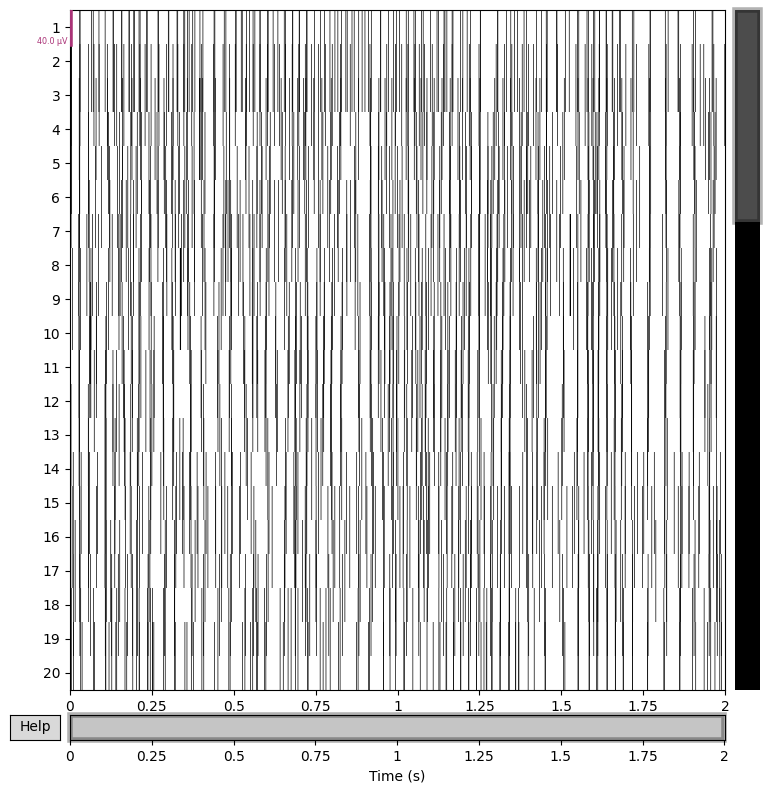

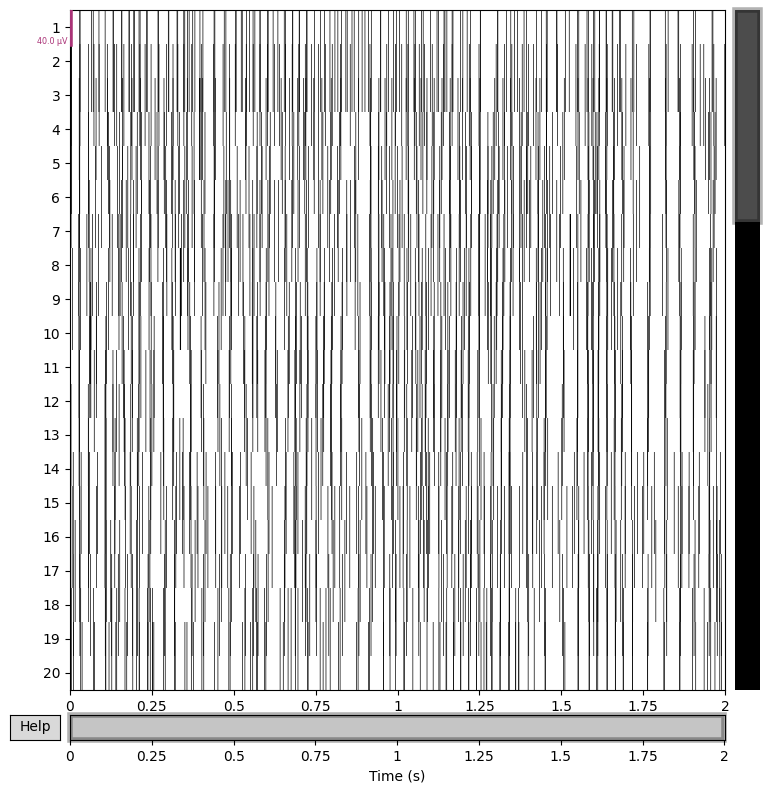

In [13]:
trial_data_cropped.plot()

In [15]:
# 총 64개. channel 기준.
np.max(trial_data_cropped.get_data(), axis=1)

array([ 588.97159123,  606.74871919,  682.36857021,  470.26664759,
        514.13948933,  619.8406048 ,  616.66196681,  509.73969695,
        525.31714078,  522.66118898,  453.16929973,  364.96899749,
        419.98856714,  364.28722395,  364.9490638 ,  407.32773   ,
        180.55013065,  195.09499773,  215.99291842,  121.74621292,
        177.09994759,  267.65187529,  321.30532344,  380.97046764,
        441.56596729,  263.02213185,  358.02138253,  322.59793278,
        191.2800808 ,  156.0973266 ,  157.23513691,  227.06348725,
        506.98453479, 1003.53513182,  831.61973869,  883.67488074,
        573.44480683,  425.93968905,  422.83738084,  533.28239464,
        693.95268516,  581.01672778,  554.81016215,  508.57578124,
        571.02461622,  441.7093561 ,  430.25203934,  364.58896592,
        364.66842421,  433.18881472,  438.69796558,  873.8786302 ,
        871.96956983,  403.74189811,  346.25721266,  296.46446796,
        247.47862078,  301.39930178,  399.81494936,  542.51794

In [54]:
# 총 1,025개. .crop()을 수행 후 time step 기준.
np.max(trial_data_cropped.get_data(), axis=0)

array([287.86534092, 265.2310198 , 221.49126955, ..., 567.05385031,
       534.54534632, 480.84423362])

In [55]:
amplitude

array([1348.18374689, 1324.14738433, 1362.88020344,  986.52957266,
       1083.35985667, 1358.48527631, 1334.500584  , 1029.17391765,
       1058.10521258,  938.64785492,  854.30476689,  674.75739556,
        729.74236854,  679.68041763,  721.6459695 ,  922.18561299,
        399.59280328,  452.1519428 ,  424.99334016,  269.10550766,
        323.16228362,  475.26913495,  623.03104537,  843.76414982,
        717.55152669,  470.65794679,  698.4565389 ,  583.5773339 ,
        401.06558694,  281.37749055,  297.09326048,  454.29702653,
       1179.34615519, 1832.32935881, 1630.03722701, 1641.35028236,
       1181.38919853,  902.52066964,  893.16825275, 1173.80207594,
       1535.69897714, 1298.77294329, 1129.6662212 ,  904.52515295,
       1069.0115793 ,  847.59168772,  872.92263094,  681.99001966,
        669.2598641 ,  774.03089393,  835.44808031, 1842.64390881,
       1615.54133121,  849.21668343,  595.47066032,  542.98116792,
        429.40194268,  556.33510746,  719.33152975,  976.65188

In [56]:
amplitude.max()

1842.6439088078798

In [57]:
amplitude.min()

269.1055076602093

In [21]:
trial_data_cropped._data.max()

1003.5351318203757

In [22]:
trial_data_cropped._data.min()

-968.7652786064086

In [ ]:
filtered_data_after_bad_trial_removal

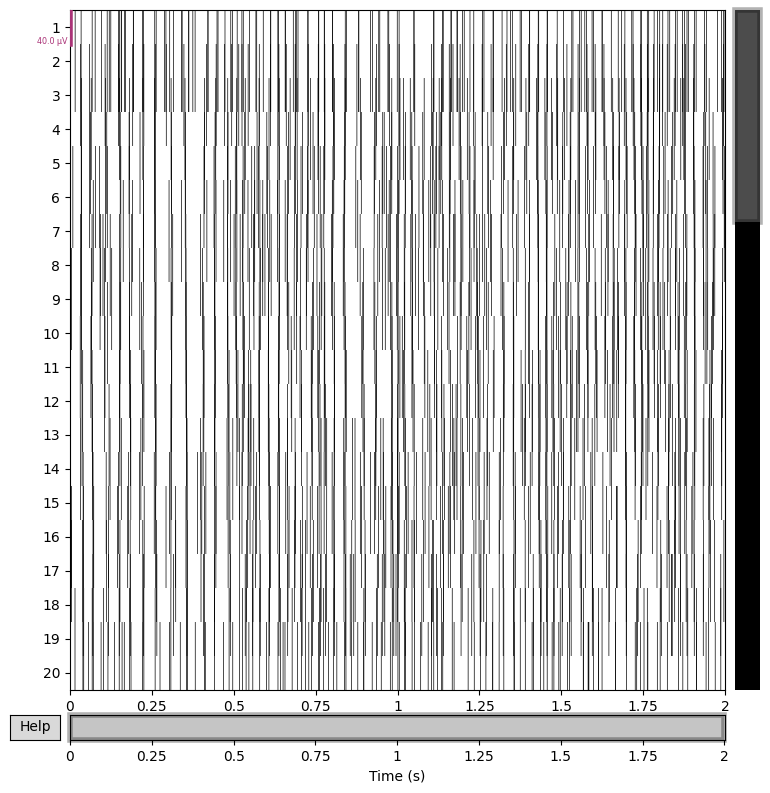

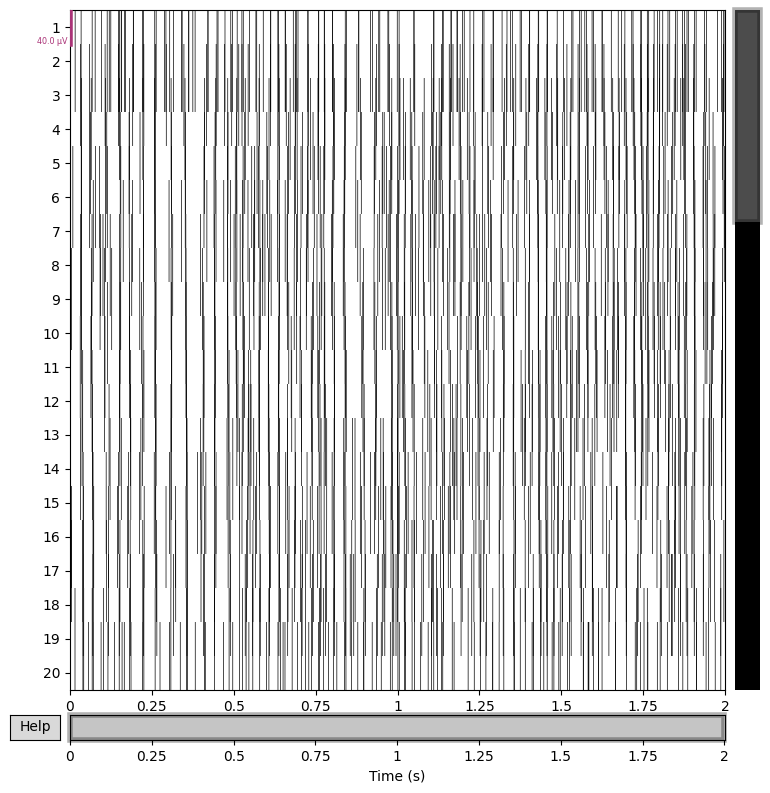

In [17]:
filtered_data_after_bad_trial_removal['s01'][0].plot()

In [ ]:
filtered_data_bad_trial

In [ ]:
preprocessed_trials

## **3.3 2nd method**

In [8]:
from scipy.signal import hilbert
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests

### **3.3.1 EMG Data 분리하기.**

In [ ]:
# Dictionary to store preprocessed data for each subject
movement_preprocessed_data = {}

# Step 1: Preprocessing - Apply Butterworth high-pass and band-pass filtering for each subject
for subject, files in movement_grouped_files.items():
    subject_preprocessed_data = []

    for file_idx, file in enumerate(files):
        # Load the data from the file (assuming each file corresponds to a CSV of EEG trial data)
        file_path = os.path.join(EEG_Data_File_Path, file)
        data = pd.read_csv(file_path, header=None).values
        
        # 채널 65~68 추출 (인덱스 64~67)
        emg_data = data[64:68, :]

        # Use mne to create RawArray object for further processing
        ch_names = [str(i) for i in range(1, emg_data.shape[0] + 1)]
        info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='emg')
        raw = mne.io.RawArray(emg_data, info)
        
        # EMG 채널을 선택
        picks = mne.pick_types(raw.info, emg=True)

        # Apply High-pass filter (0.5Hz) using Butterworth filter with 4th order to focus on the desired frequency band
        raw_filtered = raw.copy().filter(l_freq=0.5, h_freq=None, method='iir', iir_params={'order': filter_order, 'ftype': 'butter'},  picks=picks)

        # Append the preprocessed data for the current file
        subject_preprocessed_data.append(raw_filtered)

    # Store the preprocessed data for this subject
    movement_preprocessed_data[subject] = subject_preprocessed_data

In [ ]:
movement_preprocessed_data

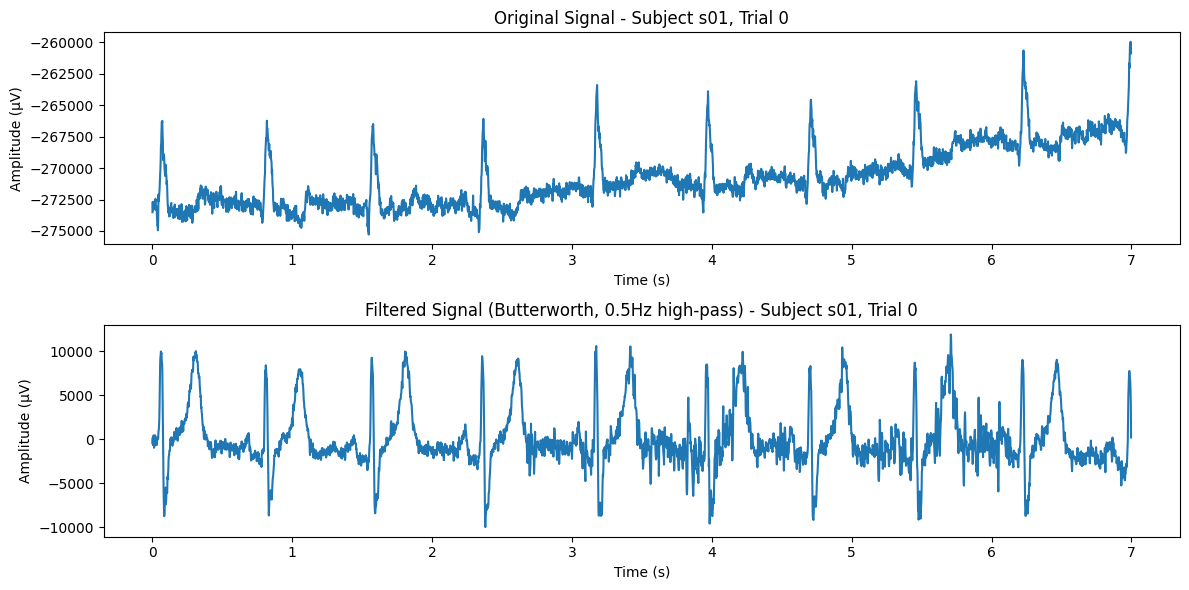

11901.1321704203
-10757.576379992139


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# 시각화할 피험자와 trial 선택 (예: s01의 첫 번째 trial)
subject = 's01'
trial_idx = 0

file_path = os.path.join(EEG_Data_File_Path, movement_grouped_files[subject][trial_idx])
data = pd.read_csv(file_path, header=None).values

# 필터링 전 trial 데이터 가져오기
original_trial_data = data

# 필터링 후 trial 데이터 가져오기
filtered_trial_data = movement_preprocessed_data[subject][trial_idx]._data

# Time axis 설정 (샘플 수에 따른 초 단위 변환)
time_axis = np.arange(original_trial_data.shape[1]) / sfreq

# 필터링 전 신호 시각화
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time_axis, original_trial_data[67, :])  # 첫 번째 채널 신호
plt.title(f'Original Signal - Subject {subject}, Trial {trial_idx}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')

# 필터링 후 신호 시각화
plt.subplot(2, 1, 2)
plt.plot(time_axis, filtered_trial_data[0, :])  # 첫 번째 채널 신호
plt.title(f'Filtered Signal (Butterworth, 0.5Hz high-pass) - Subject {subject}, Trial {trial_idx}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')

plt.tight_layout()
plt.show()

print(filtered_trial_data.max())
print(filtered_trial_data.min())

피험자별 적용시킨 버전.

In [12]:
# Create lists to store the separated EEG and EMG data per subject
eeg_data_list = {}
emg_data_list = {}

# Iterate through the filtered data and split into EEG and EMG
for subject, filtered_subject_data in filtered_data.items():
    eeg_subject_data = []
    emg_subject_data = []
    
    for data in filtered_subject_data:
        # 채널 1~64 추출 (인덱스 0~63)
        eeg_data = data.get_data()[:64, :]  # Using .get_data() to access the numpy array

        # 채널 65~68 추출 (인덱스 64~67)
        emg_data = data.get_data()[64:68, :]
        
        # 분리된 데이터를 각 리스트에 저장
        eeg_subject_data.append(eeg_data)
        emg_subject_data.append(emg_data)
    
    # Store the separated data for each subject
    eeg_data_list[subject] = eeg_subject_data
    emg_data_list[subject] = emg_subject_data


In [ ]:
emg_data_list

In [37]:
# 데이터 형식 출력. 모두 tuple 형식인 것을 확인.
for emg_data in movement_preprocessed_data:
    print(type(emg_data))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


### **3.3.2 개선된 code**

In [14]:
# Helper function to compute Pearson correlation with Bonferroni-corrected p-values
def compute_pearson_correlation(data, labels, threshold=0.8):
    
    n_channels, n_samples = data.shape
    correlations = np.zeros(n_channels)
    p_values = np.zeros(n_channels)

    for i in range(n_channels):
        corr, p_val = pearsonr(data[i], labels)
        correlations[i] = corr
        p_values[i] = p_val

    # Bonferroni correction
    _, corrected_p_values, _, _ = multipletests(p_values, alpha=0.01, method='bonferroni')

    # Identify bad trials where correlation > threshold and p-value < 0.01
    bad_trials = [i for i, (corr, p_val) in enumerate(zip(correlations, corrected_p_values))
                  if abs(corr) > threshold and p_val < 0.01]

    return bad_trials


In [15]:
# Helper function to apply Common Average Reference (CAR)
def apply_car(data):
    car = np.mean(data, axis=0)
    return data - car

In [17]:
# Filtering parameters
sfreq = 512
bad_trial_amplitude_threshold = 100  # ±100 μV
bad_trial_correlation_threshold = 0.8  # Pearson correlation threshold

피험자별 데이터로 수행한 버전.

In [ ]:
movement_preprocessed_data

In [36]:
movement_preprocessed_data.items()

dict_items([('s01', [<RawArray | 4 x 3584 (7.0 s), ~121 kB, data loaded>, <RawArray | 4 x 3584 (7.0 s), ~121 kB, data loaded>, <RawArray | 4 x 3584 (7.0 s), ~121 kB, data loaded>, <RawArray | 4 x 3584 (7.0 s), ~121 kB, data loaded>, <RawArray | 4 x 3584 (7.0 s), ~121 kB, data loaded>, <RawArray | 4 x 3584 (7.0 s), ~121 kB, data loaded>, <RawArray | 4 x 3584 (7.0 s), ~121 kB, data loaded>, <RawArray | 4 x 3584 (7.0 s), ~121 kB, data loaded>, <RawArray | 4 x 3584 (7.0 s), ~121 kB, data loaded>, <RawArray | 4 x 3584 (7.0 s), ~121 kB, data loaded>, <RawArray | 4 x 3584 (7.0 s), ~121 kB, data loaded>, <RawArray | 4 x 3584 (7.0 s), ~121 kB, data loaded>, <RawArray | 4 x 3584 (7.0 s), ~121 kB, data loaded>, <RawArray | 4 x 3584 (7.0 s), ~121 kB, data loaded>, <RawArray | 4 x 3584 (7.0 s), ~121 kB, data loaded>, <RawArray | 4 x 3584 (7.0 s), ~121 kB, data loaded>, <RawArray | 4 x 3584 (7.0 s), ~121 kB, data loaded>, <RawArray | 4 x 3584 (7.0 s), ~121 kB, data loaded>, <RawArray | 4 x 3584 (7.0

In [ ]:
# List to store the filtered EMG data
emg_data_list_filtered = []

# Iterate over each subject's EMG data
for subject, emg_data_trial in movement_preprocessed_data.items():
    # Extract EMG data for the current subject
    
    for trial_idx, trial_data in enumerate(emg_data_trial):
        
        # Step 2: Apply Common Average Referencing (CAR)s
        emg_data.set_eeg_reference('average', projection=False)

         # Step 3: Band-Pass Filtering (50-250Hz)
        raw.filter(l_freq=50, h_freq=250, fir_design='firwin', picks=picks)

    # Step 4: Apply Hilbert Transform
    emg_data_envelope = np.abs(hilbert(raw.get_data(), axis=1))

    # Step 5: Bad Trial Detection using Amplitude Threshold
    bad_trials_amplitude = np.any(np.abs(emg_data_envelope) > bad_trial_amplitude_threshold, axis=1)

    # Step 6: Pearson Correlation for EMG with Task Labels
    # Assume `labels` is a task-related label array (dummy labels used as an example)
    labels = np.ones(emg_data_envelope.shape[1])  # Dummy labels for example, replace with actual labels
    bad_trials_correlation = compute_pearson_correlation(emg_data_envelope, labels, threshold=bad_trial_correlation_threshold)

    # Combine bad trials from both amplitude and correlation checks
    bad_trials = list(set(np.where(bad_trials_amplitude)[0].tolist() + bad_trials_correlation))

    # Remove bad trials
    filtered_emg_data = np.delete(emg_data, bad_trials, axis=1)

    # Append the filtered EMG data and envelope for the current subject
    emg_data_list_filtered.append({
        'subject': subject,
        'emg_data': filtered_emg_data,
        'emg_data_envelope': emg_data_envelope
    })

In [18]:
# 피험자별 데이터 처리
movement_filtered_data = {}

for subject, trials in movement_preprocessed_data.items():
    subject_filtered_data = []
    
    for trial_data in trials:
       
        # Common Average Referencing (CAR)
        raw_car = apply_car(trial_data.get_data())
        
        ch_names = ['EMG1', 'EMG2', 'EMG3', 'EMG4']  # EMG 채널 이름
        info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='emg')
        raw_car = mne.io.RawArray(raw_car, info)  # RawArray로 변환
        picks = mne.pick_types(raw_car.info, emg=True)

        # Band-pass filtering (50–250 Hz)
        raw_filtered = raw_car.filter(l_freq=50, h_freq=250, fir_design='firwin', picks=picks)

        # Hilbert Transform to calculate amplitude envelope
        analytic_signal = hilbert(raw_filtered.get_data(), axis=1)
        amplitude_envelope = np.abs(analytic_signal)

        # Task labels 설정 (rest window: -1, task window: +1)
        rest_duration = 1.0  # resting window (in seconds)
        task_duration = 3.0  # task window (in seconds)
        
        rest_samples = int(sfreq * rest_duration)
        task_samples = int(sfreq * task_duration)
        
        labels = np.concatenate((np.ones(int(rest_samples)) * -1, np.ones(int(task_samples)) * 1))
        padding_length = amplitude_envelope.shape[1] - len(labels)
        labels = np.pad(labels, (0, padding_length), mode='constant', constant_values=0)

        # 나쁜 trial 기준: 상관계수가 threshold 이상, p-value가 0.01 이하인 경우
        bad_trials = compute_pearson_correlation(amplitude_envelope, labels)

        # 나쁜 trial 제거
        filtered_data = np.delete(amplitude_envelope, bad_trials, axis=1)
        subject_filtered_data.append(filtered_data)
    
    movement_filtered_data[subject] = subject_filtered_data

# movement_filtered_data는 나쁜 trial이 제거된 데이터를 담고 있습니다.


Creating RawArray with float64 data, n_channels=4, n_times=3584
    Range : 0 ... 3583 =      0.000 ...     6.998 secs
Ready.
No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 50 - 2.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 50.00
- Lower transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 43.75 Hz)
- Upper passband edge: 250.00 Hz
- Upper transition bandwidth: 6.00 Hz (-6 dB cutoff frequency: 253.00 Hz)
- Filter length: 283 samples (0.553 s)

Creating RawArray with float64 data, n_channels=4, n_times=3584
    Range : 0 ... 3583 =      0.000 ...     6.998 secs
Ready.
No data channels found. The highpass and lowpass values in the measurement i

### **3.3.3 최종 Code**

In [13]:
from scipy.stats import pearsonr
from scipy.signal import hilbert, decimate
from statsmodels.stats.multitest import multipletests
import numpy as np

In [14]:
# Helper function to apply Common Average Reference (CAR)
def apply_car(data):
    car = np.mean(data, axis=0)
    return data - car

In [15]:
# Helper function to perform the permutation test and calculate p-values
def compute_pearson_correlation(data, labels, threshold=0.8, n_permutations=100):
    n_channels, n_samples = data.shape
    correlations = np.zeros(n_channels)
    p_values = np.zeros(n_channels)

    # Original correlation calculation
    for i in range(n_channels):
        corr, _ = pearsonr(data[i], labels)
        correlations[i] = corr

    # Permutation test
    permuted_correlations = np.zeros((n_channels, n_permutations))
    for i in range(n_channels):
        for j in range(n_permutations):
            permuted_labels = np.random.permutation(labels)
            permuted_correlations[i, j], _ = pearsonr(data[i], permuted_labels)

    # Calculate p-values based on the permutation distribution (right-tailed test)
    for i in range(n_channels):
        perm_corr = permuted_correlations[i]
        p_values[i] = (np.sum(perm_corr >= correlations[i]) + 1) / (n_permutations + 1)

    # Apply Bonferroni correction
    _, corrected_p_values, _, _ = multipletests(p_values, alpha=0.01, method='bonferroni')

    # Identify bad trials
    bad_trials = [i for i, (corr, p_val) in enumerate(zip(correlations, corrected_p_values))
                  if abs(corr) > threshold and p_val < 0.01]

    return bad_trials


In [16]:
# Main code for processing each trial
movement_filtered_data = {}

for subject, trials in movement_preprocessed_data.items():
    subject_filtered_data = []

    for trial_data in trials:
        # Common Average Referencing (CAR)
        raw_car = apply_car(trial_data.get_data())

        ch_names = ['EMG1', 'EMG2', 'EMG3', 'EMG4']
        info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types='emg')
        raw_car = mne.io.RawArray(raw_car, info)
        picks = mne.pick_types(raw_car.info, emg=True)

        # Band-pass filtering (50-250 Hz)
        raw_filtered = raw_car.filter(l_freq=50, h_freq=250, fir_design='firwin', picks=picks)

        # Hilbert Transform to calculate amplitude envelope and square it
        analytic_signal = hilbert(raw_filtered.get_data(), axis=1)
        amplitude_envelope = np.square(np.abs(analytic_signal))

        # Task labels 설정 (rest window: -1, task window: +1)
        rest_duration = 1.0  # resting window (in seconds)
        task_duration = 3.0  # task window (in seconds)

        rest_samples = int(sfreq * rest_duration)
        task_samples = int(sfreq * task_duration)

        labels = np.concatenate((np.ones(rest_samples) * -1, np.ones(task_samples) * 1))
        padding_length = amplitude_envelope.shape[1] - len(labels)
        labels = np.pad(labels, (0, padding_length), mode='constant', constant_values=0)

        # Decimate amplitude_envelope and labels by a factor of 8
        amplitude_envelope = decimate(amplitude_envelope, 8, axis=1)
        labels = decimate(labels, 8, axis=0)

        # Pearson correlation and Bonferroni correction
        bad_trials = compute_pearson_correlation(amplitude_envelope, labels)

        # Remove bad trials
        filtered_data = np.delete(amplitude_envelope, bad_trials, axis=1)
        subject_filtered_data.append(filtered_data)

    movement_filtered_data[subject] = subject_filtered_data


Creating RawArray with float64 data, n_channels=4, n_times=3584
    Range : 0 ... 3583 =      0.000 ...     6.998 secs
Ready.
No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 50 - 2.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 50.00
- Lower transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 43.75 Hz)
- Upper passband edge: 250.00 Hz
- Upper transition bandwidth: 6.00 Hz (-6 dB cutoff frequency: 253.00 Hz)
- Filter length: 283 samples (0.553 s)

Creating RawArray with float64 data, n_channels=4, n_times=3584
    Range : 0 ... 3583 =      0.000 ...     6.998 secs
Ready.
No data channels found. The highpass and lowpass values in the measurement i

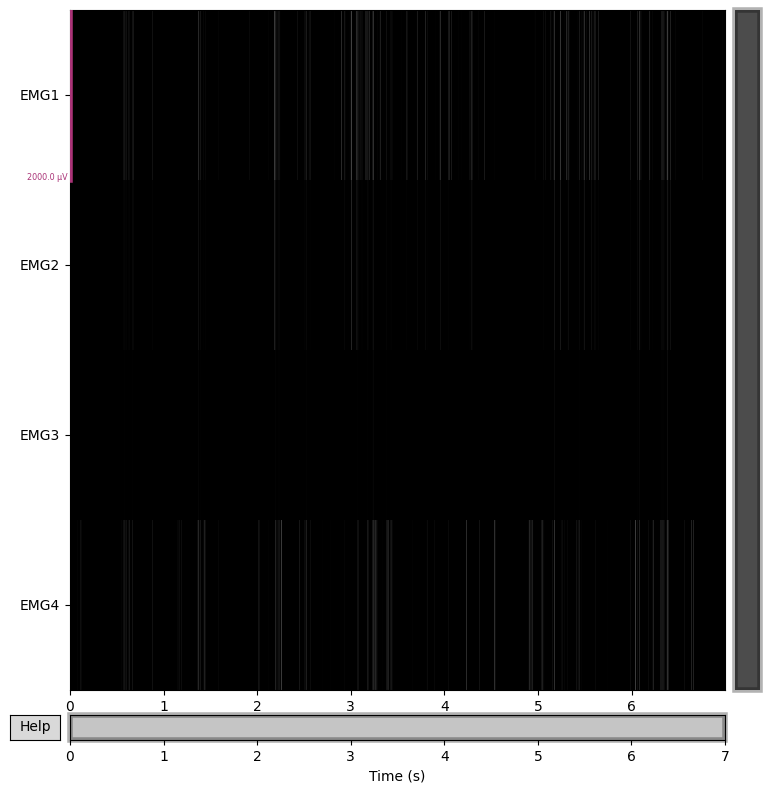

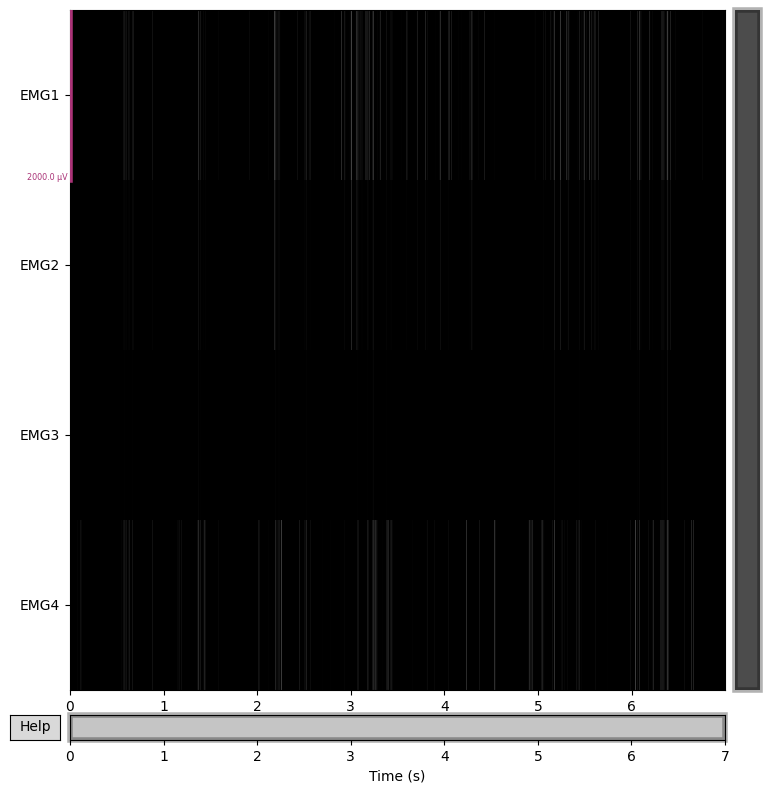

In [20]:
raw_car.plot()

In [22]:
raw_filtered

<RawArray | 4 x 3584 (7.0 s), ~121 kB, data loaded>

In [ ]:
amplitude_envelope

In [ ]:
labels

In [ ]:
# bad trial 확인.
bad_trials

In [ ]:
# 2nd Method 결과 확인.
movement_filtered_data

In [24]:
len(emg_data_list_filtered[0]['emg_data'])

4

## **3.4 3rd method**

In [ ]:
#EEG Data 추출하기.
filtered_data_after_bad_trial_removal

In [15]:
# 데이터 형식 출력. 모두 tuple 형식인 것을 확인.
for eeg_data in filtered_data_after_bad_trial_removal:
    print(type(eeg_data))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


In [16]:
# Baseline Correction 함수
def baseline_correction(data, baseline):
    baseline_mean = np.mean(data[:, baseline[0]:baseline[1]], axis=1, keepdims=True)
    return data - baseline_mean

In [18]:
# Laplacian Filtering 함수 (간단한 방법으로 주변 채널의 평균값을 뺌)
def laplacian_filter(data):
    n_channels, n_samples = data.shape
    laplacian_data = np.zeros((n_channels, n_samples))
    
    # 단순히 인접 채널 간의 평균값을 빼는 방식
    for i in range(1, n_channels-1):
        laplacian_data[i, :] = data[i, :] - 0.5 * (data[i-1, :] + data[i+1, :])
    
    # 가장자리 채널은 고려하지 않음 (0과 마지막 채널)
    laplacian_data[0, :] = data[0, :] - data[1, :]
    laplacian_data[-1, :] = data[-1, :] - data[-2, :]
    
    return laplacian_data

### **3.4.1 데이터 확인**

출력 후 Nan이 확인되어 데이터를 확인 필요.

In [17]:
baseline = (-500, 0) # 단위는 ms

In [25]:
for eeg_data_tuple in eeg_data_list:  # 이전에 분리한 EEG 데이터를 사용

    eeg_data = eeg_data_tuple[0]  # 첫 번째 요소가 데이터라고 가정
    print("Original EEG data contains NaN:", np.isnan(eeg_data).any())

    # Step 1: High-Pass Filtering (0.5Hz)
    raw.filter(l_freq=0.5, h_freq=None, method='iir')
    print("After High-Pass Filtering contains NaN:", np.isnan(raw.get_data()).any())

    # Step 2: Laplacian Filtering
    laplacian_data = compute_current_source_density(raw)
    print("After Laplacian Filtering contains NaN:", np.isnan(laplacian_data.get_data()).any())

    # Step 3: Band-Pass Filtering (8-14Hz)
    laplacian_data.filter(l_freq=8, h_freq=14, method='iir')
    print("After Band-Pass Filtering contains NaN:", np.isnan(laplacian_data.get_data()).any())

    # Step 4: Hilbert Transform
    hilbert_transformed_data = np.abs(hilbert(laplacian_data.get_data(), axis=1))
    print("After Hilbert Transform contains NaN:", np.isnan(hilbert_transformed_data).any())

    # Step 5: Baseline Correction
    baseline_corrected_data = baseline_correction(hilbert_transformed_data, baseline)
    print("After Baseline Correction contains NaN:", np.isnan(baseline_corrected_data).any())

Original EEG data contains NaN: False
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 0.50 Hz: -6.02 dB

After High-Pass Filtering contains NaN: False


RuntimeError: Cannot fit headshape without digitization , info["dig"] is None

### **3.4.2 본격 Method**

In [19]:
# 채널 이름 매핑: 번호를 international 10-10 system 이름으로 변환
channel_mapping = {
    'EEG1': 'FP1', 'EEG2': 'AF7', 'EEG3': 'AF3',
    'EEG4': 'F1', 'EEG5': 'F3', 'EEG6': 'F5', 'EEG7': 'F7', 'EEG8': 'FT7',
    'EEG9': 'FC5', 'EEG10': 'FC3', 'EEG11': 'FC1', 'EEG12': 'C1', 'EEG13': 'C3',
    'EEG14': 'C5', 'EEG15': 'T7', 'EEG16': 'TP7', 'EEG17': 'CP5',
    'EEG18': 'CP3', 'EEG19': 'CP1', 'EEG20': 'P1', 'EEG21': 'P3', 'EEG22': 'P5',
    'EEG23': 'P7', 'EEG24': 'P9', 'EEG25': 'PO7', 'EEG26': 'PO3',
    'EEG27': 'O1', 'EEG28': 'Iz', 'EEG29': 'Oz', 'EEG30': 'POz', 'EEG31': 'Pz',
    'EEG32': 'CPZ', 'EEG33': 'FPZ', 'EEG34': 'FP2', 'EEG35': 'AF8',
    'EEG36': 'AF4', 'EEG37': 'AFZ', 'EEG38': 'FZ', 'EEG39': 'F2', 'EEG40': 'F4',
    'EEG41': 'F6', 'EEG42': 'F8', 'EEG43': 'FT8', 'EEG44': 'FC6',
    'EEG45': 'FC4', 'EEG46': 'FC2', 'EEG47': 'FCz', 'EEG48': 'Cz', 'EEG49': 'C2',
    'EEG50': 'C4', 'EEG51': 'C6', 'EEG52': 'T8', 'EEG53': 'TP8',
    'EEG54': 'CP6', 'EEG55': 'CP4', 'EEG56': 'CP2', 'EEG57': 'P2', 'EEG58': 'P4',
    'EEG59': 'P6', 'EEG60': 'P8', 'EEG61': 'P10',
    'EEG62': 'PO8', 'EEG63': 'PO4', 'EEG64': 'O2'
}

In [49]:
# Parameter
sfreq = 512  # Sampling Frequency
baseline = (-0.5, 0)  # baseline 구간, 단위는 s

In [21]:
# Baseline Correction, mne library 사용.
def apply_baseline_correction(data, baseline, sfreq):
    mne.baseline.rescale(data, times=np.arange(data.shape[1]) / sfreq, baseline=baseline, mode='mean')
    return data

In [ ]:
eeg_data_list_filtered = []

for eeg_data_tuple in eeg_data_list:  # 이전에 분리한 EEG 데이터를 사용
    # tuple에서 데이터를 추출
    eeg_data = eeg_data_tuple[0]  # 첫 번째 요소가 데이터라고 가정

    # MNE를 사용해 RawArray로 변환 (채널명 매핑)
    ch_names = [f'EEG{i+1}' for i in range(eeg_data.shape[0])]
    mapped_ch_names = [channel_mapping.get(name) for name in ch_names]

    info = mne.create_info(ch_names=mapped_ch_names, sfreq=sfreq, ch_types='eeg')
    raw = mne.io.RawArray(eeg_data, info)

    # Step 1: High-Pass Filtering (0.5Hz)
    raw.filter(l_freq=0.5, h_freq=None, fir_design='firwin')

    # Step 2: Laplacian Filtering
    montage = mne.channels.make_standard_montage('biosemi64') # montage로 10-10 system 형태로 정함. channel이 EEG는 64개, EMG는 4개.
    # 여기서는 Biosemi ActiveTwo System으로 EEG를 측정.
    raw.set_montage(montage, match_case=False)  # match_case=False로 설정하여 channel 이름과 montage 이름이 다를 경우 자동으로 처리.

    laplacian_data = compute_current_source_density(raw)

    # Step 3: Band-Pass Filtering (8-14Hz)
    laplacian_data.filter(l_freq=8, h_freq=14, fir_design='firwin')

    # Step 4: Hilbert Transform
    hilbert_transformed_data = np.abs(hilbert(laplacian_data.get_data(), axis=1))

    # Step 5: Baseline Correction
    baseline_corrected_data = apply_baseline_correction(hilbert_transformed_data, baseline, sfreq)

    eeg_data_list_filtered.append(baseline_corrected_data)

In [20]:
# 주어진 데이터에 대한 처리 시작
sfreq = 512  # 샘플링 주파수
# baseline = (-500, 0)  # baseline 구간 (0~100ms) 예시

eeg_data_list_filtered = []

for eeg_data_tuple in eeg_data_list:  # 이전에 분리한 EEG 데이터를 사용
    
    # tuple에서 데이터를 추출
    eeg_data = eeg_data_tuple[0]  # 첫 번째 요소가 데이터라고 가정
    
    # MNE를 사용해 RawArray로 변환 (채널명은 간단히 "EEG1", "EEG2" 등으로 지정)
    info = mne.create_info(ch_names=[f'EEG{i+1}' for i in range(eeg_data.shape[0])], sfreq=sfreq, ch_types='eeg')
    raw = mne.io.RawArray(eeg_data, info)
    
    # Step 1: High-Pass Filtering (0.5Hz)
    raw.filter(l_freq=0.5, h_freq=None)
    
    # Step 2: Laplacian Filtering (MNE에서는 Custom Laplacian 필터를 직접 작성하거나 표준화를 적용)
    montage = mne.channels.make_standard_montage('standard_1020')  # 표준 10-20 시스템 몽타주 설정
    raw.set_montage(montage)
    laplacian_data = compute_current_source_density(raw, montage)  # 몽타주 없이 Laplacian 적용
    
    # Step 3: Band-Pass Filtering (8-14Hz)
    laplacian_data.filter(l_freq=8, h_freq=14)
    
    # Step 4: Hilbert Transform
    hilbert_transformed_data = np.abs(hilbert(laplacian_data.get_data(), axis=1))
    
    # Step 5: Baseline Correction
    # baseline_corrected_data = baseline_correction(hilbert_transformed_data, baseline)
    baseline_corrected_data = hilbert_transformed_data.apply_baseline(baseline = (-0.5, 0))
    
    eeg_data_list_filtered.append(baseline_corrected_data)

# 결과 확인: 첫 번째 파일의 처리된 EEG 데이터를 확인
print("First EEG data after processing:")
print(eeg_data_list_filtered[0])

Creating RawArray with float64 data, n_channels=64, n_times=1025
    Range : 0 ... 1024 =      0.000 ...     2.000 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Filter length: 3381 samples (6.604 s)



C:\Users\user\AppData\Local\Temp\ipykernel_26772\678737717.py:17: RuntimeWarning: filter_length (3381) is longer than the signal (1025), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(l_freq=0.5, h_freq=None)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


ValueError: DigMontage is only a subset of info. There are 64 channel positions not present in the DigMontage. The channels missing from the montage are:

['EEG1', 'EEG2', 'EEG3', 'EEG4', 'EEG5', 'EEG6', 'EEG7', 'EEG8', 'EEG9', 'EEG10', 'EEG11', 'EEG12', 'EEG13', 'EEG14', 'EEG15', 'EEG16', 'EEG17', 'EEG18', 'EEG19', 'EEG20', 'EEG21', 'EEG22', 'EEG23', 'EEG24', 'EEG25', 'EEG26', 'EEG27', 'EEG28', 'EEG29', 'EEG30', 'EEG31', 'EEG32', 'EEG33', 'EEG34', 'EEG35', 'EEG36', 'EEG37', 'EEG38', 'EEG39', 'EEG40', 'EEG41', 'EEG42', 'EEG43', 'EEG44', 'EEG45', 'EEG46', 'EEG47', 'EEG48', 'EEG49', 'EEG50', 'EEG51', 'EEG52', 'EEG53', 'EEG54', 'EEG55', 'EEG56', 'EEG57', 'EEG58', 'EEG59', 'EEG60', 'EEG61', 'EEG62', 'EEG63', 'EEG64'].

Consider using inst.rename_channels to match the montage nomenclature, or inst.set_channel_types if these are not EEG channels, or use the on_missing parameter if the channel positions are allowed to be unknown in your analyses.

피험자별 데이터로 수행한 버전.

In [ ]:
filtered_data_after_bad_trial_removal

In [ ]:
# Initialize the list to store the results for each subject in the same format as the original data
eeg_data_list_filtered = {}

# Iterate over each subject's EEG data and apply the third method
for subject, eeg_data_list in filtered_data_after_bad_trial_removal.items():
    print(f"Processing subject: {subject}")
    
    subject_processed_data = []

    for eeg_data in eeg_data_list:
        # Map channel names using the provided mapping
        ch_names = [f'EEG{i+1}' for i in range(64)]
        mapped_ch_names = [channel_mapping.get(name) for name in ch_names]

        # Step 1: Convert EEG data to MNE RawArray (with mapped channel names)
        info = mne.create_info(ch_names=mapped_ch_names, sfreq=sfreq, ch_types='eeg')
        raw = mne.io.RawArray(eeg_data.get_data(), info)

        # Step 2: High-Pass Filtering (0.5 Hz)
        raw.filter(l_freq=0.5, h_freq=None, fir_design='firwin')

        # Step 3: Laplacian Filtering (Apply standard montage and compute Laplacian)
        montage = mne.channels.make_standard_montage('biosemi64')
        raw.set_montage(montage, match_case=False)  # Apply International 10-10 montage system
        laplacian_data = mne.preprocessing.compute_current_source_density(raw)  # Laplacian filtering

        # Step 4: Band-Pass Filtering (8-14 Hz for mu rhythm)
        laplacian_data.filter(l_freq=8, h_freq=14, fir_design='firwin')

        # Step 5: Hilbert Transform (Envelope Detection)
        hilbert_transformed_data = np.abs(hilbert(laplacian_data.get_data(), axis=1))
        amplitude_envelope = np.abs(hilbert_transformed_data)

        # Step 6: Baseline Correction
        baseline_corrected_data = apply_baseline_correction(amplitude_envelope, baseline, sfreq)

        # Append the processed data for this trial
        subject_processed_data.append(baseline_corrected_data)
    
    # Store the processed data for each subject
    eeg_data_list_filtered[subject] = subject_processed_data

In [ ]:
eeg_data_list_filtered

### **3.4.3 최종 Code**

In [50]:
# Function to apply baseline correction for ERD/ERS calculation
def calculate_erd_ers(data, baseline_period, sfreq):
    """
    Calculate ERD/ERS percentage for EEG data based on baseline.
    
    Parameters:
    - data: numpy array, shape (n_channels, n_times)
    - baseline_period: tuple, baseline period in seconds (e.g., (-0.5, 0))
    - sfreq: int, sampling frequency of the data
    
    Returns:
    - erd_ers: numpy array, ERD/ERS percentage for each time point
    """
    baseline_samples = int(sfreq * (baseline_period[1] - baseline_period[0]))
    baseline = data[:, :baseline_samples].mean(axis=1, keepdims=True)  # Mean over baseline period
    erd_ers = (data - baseline) / baseline * 100  # ERD% calculation: (A-R)/R * 100
    return erd_ers

In [ ]:
# Initialize the list to store the results for each subject
erd_ers_results = {}

# Iterate over each subject's EEG data and apply the third method
for subject, eeg_data_list in filtered_data_after_bad_trial_removal.items():
    print(f"Processing subject: {subject}")
    subject_processed_data = []
    
    for eeg_data in eeg_data_list:
        # Map channel names using the provided mapping
        ch_names = [f'EEG{i+1}' for i in range(64)]
        mapped_ch_names = [channel_mapping.get(name) for name in ch_names]
        
        # Step 1: Convert EEG data to MNE RawArray (with mapped channel names)
        info = mne.create_info(ch_names=mapped_ch_names, sfreq=sfreq, ch_types='eeg')
        raw = mne.io.RawArray(eeg_data.get_data(), info)
        
        # Step 2: High-Pass Filtering (0.5 Hz)
        raw.filter(l_freq=0.5, h_freq=None, fir_design='firwin')
        
        # Step 3: Laplacian Filtering (Applying standard montage and computing Laplacian)
        montage = mne.channels.make_standard_montage('biosemi64')
        raw.set_montage(montage, match_case=False) # Apply International 10-10 montage system
        laplacian_data = mne.preprocessing.compute_current_source_density(raw) # Laplacian filtering
        
        # Step 4: Band-Pass Filtering (8-14 Hz for mu rhythm)
        laplacian_data.filter(l_freq=8, h_freq=14, fir_design='firwin')
        
        # Step 5: Hilbert Transform (Envelope Detection)
        hilbert_transformed_data = np.abs(hilbert(laplacian_data.get_data(), axis=1))
        
        # Step 6: Baseline Correction for ERD/ERS Calculation
        erd_ers_data = calculate_erd_ers(hilbert_transformed_data, baseline, sfreq)
        
        # Append the processed data for this trial
        subject_processed_data.append(erd_ers_data)
    
    # Store the processed data for each subject
    erd_ers_results[subject] = np.mean(subject_processed_data, axis=0)  # Average across trials


In [ ]:
erd_ers_data

In [ ]:
subject_preprocessed_data

In [ ]:
erd_ers_results

In [59]:
len(erd_ers_results[subject][0][1])

1025

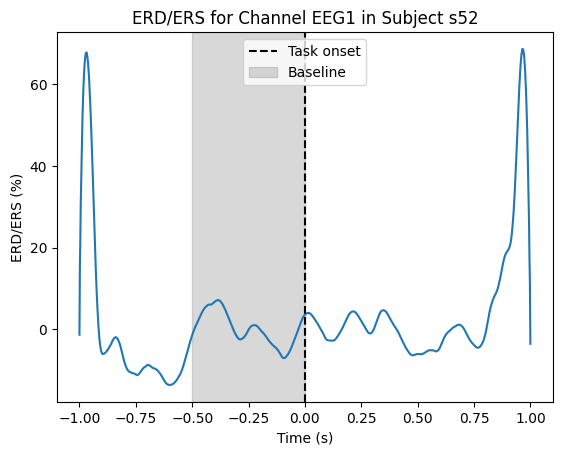

In [67]:
# Example Plotting ERD/ERS for a single channel
import matplotlib.pyplot as plt

channel_idx = 0  # Index for a channel, e.g., C3 or C4
time = np.arange(erd_ers_results[subject].shape[1]) / sfreq - 1  # Time axis in seconds (shift for baseline)

plt.plot(time, erd_ers_results[subject][channel_idx])
plt.xlabel("Time (s)")
plt.ylabel("ERD/ERS (%)")
plt.title(f"ERD/ERS for Channel {ch_names[channel_idx]} in Subject {subject}")
plt.axvline(x=0, color='k', linestyle='--', label="Task onset")
plt.axvspan(-0.5, 0, color='gray', alpha=0.3, label="Baseline")
plt.legend()
plt.show()

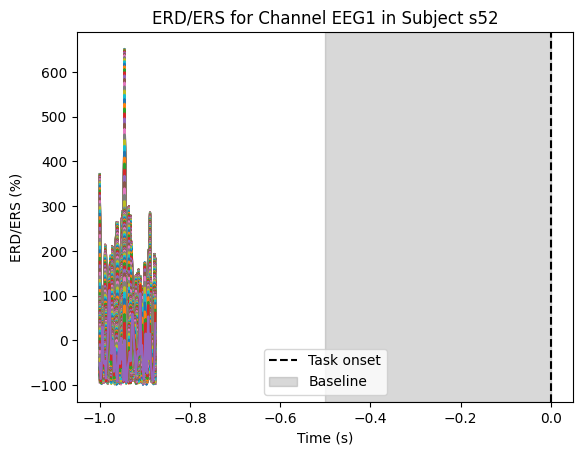

In [62]:
# Example Plotting ERD/ERS for a single channel
# erd_ers_results가 리스트 형태인 경우 사용.
import matplotlib.pyplot as plt

erd_ers_results[subject] = np.array(erd_ers_results[subject])
channel_idx = 0  # Index for a channel, e.g., C3 or C4
time = np.arange(erd_ers_results[subject].shape[1]) / sfreq - 1  # Time axis in seconds (shift for baseline)

plt.plot(time, erd_ers_results[subject][channel_idx])
plt.xlabel("Time (s)")
plt.ylabel("ERD/ERS (%)")
plt.title(f"ERD/ERS for Channel {ch_names[channel_idx]} in Subject {subject}")
plt.axvline(x=0, color='k', linestyle='--', label="Task onset")
plt.axvspan(-0.5, 0, color='gray', alpha=0.3, label="Baseline")
plt.legend()
plt.show()

NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").
inst is Evoked, setting `average=False`
Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_28516\586808933.py:24: FutureWarning: Parameters `vmin` and `vmax` are deprecated, use `vlim` instead.
  power.plot([63], baseline=baseline, mode='percent', title='ERDS map',


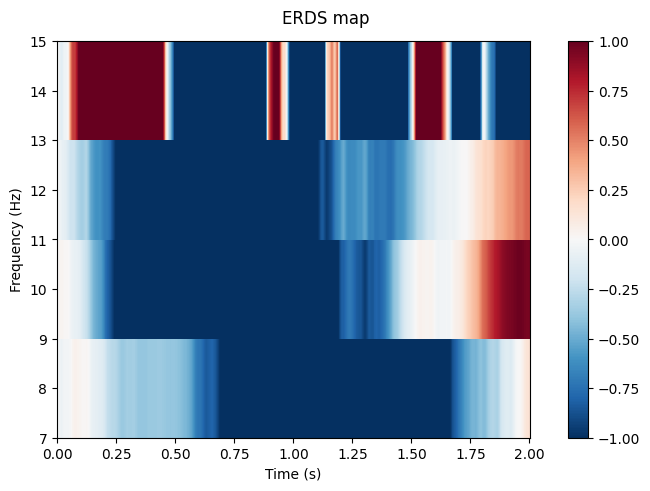

In [46]:
import mne
from mne.time_frequency import tfr_multitaper
import matplotlib.pyplot as plt

# 예제 데이터 로드 (BCI 데이터 세트를 사용하는 것이 권장됨)
# raw = mne.io.read_raw_fif('path_to_file.fif', preload=True)

# 이벤트와 이벤트 ID 설정
# events, event_id = mne.events_from_annotations(raw)

# 주파수 범위와 설정 (8–14 Hz)
freqs = [8, 10, 12, 14]  # 관심있는 주파수 대역
n_cycles = freqs  # 각 주파수에 대한 주기 수를 동일하게 설정

# TFR(Time-Frequency Representation) 계산 (데이터와 설정에 따라 수정)
power = tfr_multitaper(raw, freqs=freqs, n_cycles=n_cycles, 
                       use_fft=True, return_itc=False, average=True)

# 베이스라인 기간을 설정하고 보정
baseline_vis=(0.0, 2.0)
power.apply_baseline(baseline=baseline_vis, mode='percent')

# ERDS 맵 시각화
power.plot([63], baseline=baseline, mode='percent', title='ERDS map',
           vmin=-1, vmax=1, cmap='RdBu_r')
plt.show()


## **3.5 4th Method**

In [30]:
import os
import pandas as pd
from collections import defaultdict

In [20]:
# 피험자 ID 목록
subject_ids = [
    's1', 's3', 's4', 's5', 's6', 's9', 's10', 's13', 's14', 's33', 's35', 
    's41', 's43', 's44', 's46', 's48', 's49', 's50', 's52'
]

# 모든 CSV 파일 경로가 저장된 리스트 (예: csv_files 리스트에 모든 파일 경로가 저장되어 있다고 가정)
csv_files

# 피험자별 및 데이터 유형별 데이터를 저장하기 위한 딕셔너리 생성
subject_data = defaultdict(lambda: defaultdict(list))

# 각 파일을 피험자별 및 데이터 유형별로 분류하여 subject_data에 저장
for file_path in csv_files:
    # 파일명에서 피험자 ID 추출 (예: 's01')
    file_name = os.path.basename(file_path)
    components = file_name.split('_')
    
    data_type = components[0] + "_" + components[1]  # 데이터 유형 추출 (예: 'imagery_left', 'movement_right', 'rest' 등)
    subject_id = components[2]  # 피험자 ID 추출 (예: 's01')

    # 피험자 ID가 목록에 있는 경우에만 처리
    if subject_id in subject_ids:
        # CSV 파일 읽기
        data = pd.read_csv(file_path)  # 각 파일의 데이터를 읽어서 DataFrame으로 저장

        # 피험자 및 데이터 유형별로 데이터를 딕셔너리에 추가
        subject_data[subject_id][data_type].append(data)

# 피험자별로 데이터 확인
for subject, data_types in subject_data.items():
    print(f"Subject: {subject}")
    for data_type, data_list in data_types.items():
        print(f"  Data Type: {data_type}, Number of trials: {len(data_list)}")



FileNotFoundError: [Errno 2] No such file or directory: 'imagery_left_s10_mat_block1.csv'

In [ ]:
csv_files

In [25]:
# 피험자 ID 목록
subject_ids = [
    's01', 's03', 's04', 's05', 's06', 's09', 's10', 's13', 's14', 's33', 's35', 
    's41', 's43', 's44', 's46', 's48', 's49', 's50', 's52'
]

# 피험자별 및 데이터 유형별 데이터를 저장하기 위한 딕셔너리 생성
subject_data = defaultdict(lambda: defaultdict(list))

# 각 파일을 피험자별 및 데이터 유형별로 분류하여 subject_data에 저장
for file_path in csv_files:
    # 파일명에서 피험자 ID 추출 (예: 's01')
    file_name = os.path.basename(file_path)
    components = file_name.split('_')

    # 데이터 유형과 피험자 ID 추출
    data_type = components[0] + "_" + components[1]  # 데이터 유형 추출 (예: 'imagery_left', 'movement_right', 'rest' 등)
    subject_id = components[2]  # 피험자 ID 추출 (예: 's01')

    # 피험자 ID가 목록에 있는 경우에만 처리
    if subject_id in subject_ids:
        try:
            # CSV 파일 읽기
            data = pd.read_csv(file_path)  # 각 파일의 데이터를 읽어서 DataFrame으로 저장

            # 피험자 및 데이터 유형별로 데이터를 딕셔너리에 추가
            subject_data[subject_id][data_type].append(data)
        except FileNotFoundError:
            print(f"File not found: {file_path}")
        except pd.errors.EmptyDataError:
            print(f"Empty data found in file: {file_path}")

# 피험자별로 데이터 확인
for subject, data_types in subject_data.items():
    print(f"Subject: {subject}")
    for data_type, data_list in data_types.items():
        print(f"  Data Type: {data_type}, Number of trials: {len(data_list)}")



Subject: s01
  Data Type: imagery_left, Number of trials: 100
  Data Type: imagery_right, Number of trials: 100
  Data Type: movement_left, Number of trials: 20
  Data Type: movement_right, Number of trials: 20
Subject: s03
  Data Type: imagery_left, Number of trials: 100
  Data Type: imagery_right, Number of trials: 100
  Data Type: movement_left, Number of trials: 20
  Data Type: movement_right, Number of trials: 20
Subject: s04
  Data Type: imagery_left, Number of trials: 100
  Data Type: imagery_right, Number of trials: 100
  Data Type: movement_left, Number of trials: 20
  Data Type: movement_right, Number of trials: 20
Subject: s05
  Data Type: imagery_left, Number of trials: 100
  Data Type: imagery_right, Number of trials: 100
  Data Type: movement_left, Number of trials: 20
  Data Type: movement_right, Number of trials: 20
Subject: s06
  Data Type: imagery_left, Number of trials: 100
  Data Type: imagery_right, Number of trials: 100
  Data Type: movement_left, Number of trials

In [45]:
from mne.decoding import CSP
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA # Fisher's linear discriminant analysis
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [21]:
# eeg_data_list_filtered는 전처리된 EEG 데이터를 저장한 리스트
# 각 데이터를 2차원 배열로 변환 (CSP와 LDA의 입력으로 사용할 수 있도록)
# 데이터가 피험자별로 나누어져 있다고 가정하고 피험자별 학습을 수행

subject_ids = [
    's01', 's03', 's04', 's05', 's06', 's09', 's10', 's13', 's14', 
    's33', 's35', 's41', 's43', 's44', 's46', 's48', 's49', 's50', 's52'
]

for subject_id in subject_ids:
    print(f"Subject: {subject_id}")

    # 각 피험자에 해당하는 데이터를 가져옴
    subject_data = eeg_data_list_filtered[subject_id]
    X = np.array([np.array(trial) for trial in subject_data])

    # 레이블 생성 (예: 왼손=0, 오른손=1로 가정)
    n_trials = X.shape[0]
    y = np.array([0] * (n_trials // 2) + [1] * (n_trials // 2))  # 레이블 생성

    # Train-Test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # CSP 적용 (공간적 필터 수는 2로 설정)
    csp = CSP(n_components=2, reg=None, log=True, cov_est='epoch')
    X_train_csp = csp.fit_transform(X_train, y_train)
    X_test_csp = csp.transform(X_test)

    # LDA 분류기 적용
    lda = LDA()
    lda.fit(X_train_csp, y_train)
    y_pred = lda.predict(X_test_csp)

    # 분류 정확도 및 Confusion Matrix 출력
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    print(f"Classification accuracy: {accuracy * 100:.2f}%")
    print(f"Confusion Matrix:\n{cm}")


Subject: s01


TypeError: list indices must be integers or slices, not str

In [46]:
# eeg_data_list_filtered는 전처리된 EEG 데이터를 저장한 리스트
# 각 데이터를 2차원 배열로 변환 (CSP와 LDA의 입력으로 사용할 수 있도록)
X = np.array([np.array(trial) for trial in eeg_data_list_filtered])

# 여기서 y는 레이블을 나타냅니다 (예: 왼손=0, 오른손=1). 해당 데이터셋에 맞게 설정
# 예시로 왼손과 오른손의 데이터를 각각 절반으로 나누어 사용한다고 가정
n_trials = X.shape[0]
y = np.array([0] * (n_trials // 2) + [1] * (n_trials // 2))  # 레이블 생성

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# CSP 적용 (공간적 필터 수는 2로 설정)
csp = CSP(n_components=2, reg=None, log=True, cov_est='epoch')
X_train_csp = csp.fit_transform(X_train, y_train)
X_test_csp = csp.transform(X_test)

# LDA 분류기 적용
lda = LDA()
lda.fit(X_train_csp, y_train)
y_pred = lda.predict(X_test_csp)

# 분류 정확도 출력
accuracy = accuracy_score(y_test, y_pred)
print(f"Classification accuracy: {accuracy * 100:.2f}%")

Computing rank from data with rank=None
    Using tolerance 1.2e+08 (2.2e-16 eps * 64 dim * 8.5e+21  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=0 co

피험자별 적용시킨 버전.

In [ ]:
#1번째 method 결과.
filtered_data_after_bad_trial_removal

In [21]:
# 각 피험자의 최소 trial 수 확인
# trial 갯수는 7의 배수를 해야 함. - train/test를 7:3으로 해야 함.
min_trials = min([len(trials) for trials in eeg_data_list_filtered.values()]) - 1

# 최소 trial 수에 맞춰 각 피험자 데이터를 정리
for subject, trials in eeg_data_list_filtered.items():
    eeg_data_list_filtered[subject] = trials[:min_trials]


### **3.5.1 최종 코드**

In [12]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from mne.decoding import CSP
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score

In [13]:
# trial counts for each subject
trial_counts = {subject: len(trials) for subject, trials in filtered_data_after_bad_trial_removal.items()}

# Initialize labels_per_subject dictionary
labels_per_subject = {}

# Loop through each subject and generate labels based on trial counts
for subject, n_trials in trial_counts.items():
    # Half of the trials are 'imagery_left' (0), the other half are 'imagery_right' (1)
    half_trials = n_trials // 2
    labels = np.array([0] * half_trials + [1] * half_trials)  # First half '0', second half '1'
    
    # Store the generated labels for the subject
    labels_per_subject[subject] = labels


In [ ]:
trial_counts

In [ ]:
labels_per_subject

In [16]:
# Dictionary to store classification accuracy for each subject
classification_results = {}

# Iterate over each subject's EEG data and perform classification
for subject, eeg_data_list in filtered_data_after_bad_trial_removal.items():
    print(f"Processing subject: {subject}")
    
    # Convert the processed EEG data to a numpy array
    X = np.array(eeg_data_list)  # Shape should be (n_trials, n_channels, n_times)
    X = np.stack([x for x in eeg_data_list])  # Ensure the shape is (n_trials, n_channels, n_times)
    y = labels_per_subject[subject]  # Corresponding labels for this subject

    # Step 1: Apply CSP (Common Spatial Patterns) for feature extraction
    csp = CSP(n_components=2, reg=None, log=True)
    X_csp = csp.fit_transform(X, y)
    
     # Step 2: Perform 7:3 train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_csp, y, test_size=0.3, random_state=42)

    # Step 3: Perform classification using FLDA (Fisher's Linear Discriminant Analysis)
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = lda.predict(X_test)
    
    # Step 4: Compute and display the confusion matrix for the subject
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Left', 'Right'])
    disp.plot()
    plt.title(f'Confusion Matrix for Subject {subject}')
    plt.show()

    # Step 5: Calculate and store classification accuracy for this subject
    accuracy = np.mean(y_test == y_pred)
    classification_results[subject] = accuracy
    print(f"Classification accuracy for {subject}: {accuracy * 100:.2f}%")

Processing subject: s01


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_26168\1554162028.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(eeg_data_list)  # Shape should be (n_trials, n_channels, n_times)
c:\Users\user\anaconda3\lib\site-packages\numpy\core\shape_base.py:420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arrays = [asanyarray(arr) for arr in arrays]


ValueError: setting an array element with a sequence.

X shape: (200, 64, 1025), y shape: (200,)
Computing rank from data with rank=None
    Using tolerance 1e+04 (2.2e-16 eps * 64 dim * 7.3e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


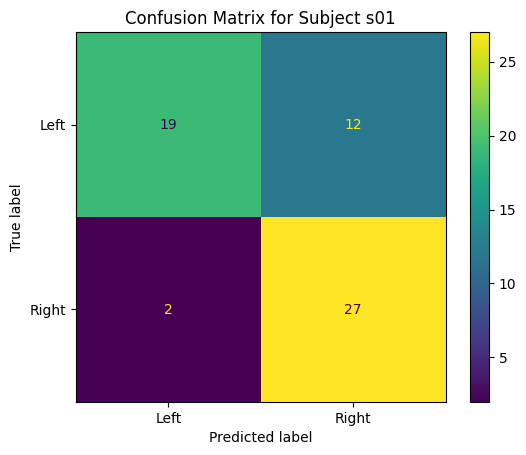

Classification accuracy for s01: 76.67%


In [24]:
# Ensure all trials are converted from RawArray to numpy arrays and have the same shape
consistent_shape = (64, 1025)  # Adjust based on your data dimensions (n_channels, n_times)
processed_data = []

for trial in eeg_data_list:
    # Convert RawArray to numpy array
    trial_data = trial.get_data()  # Now trial_data is a numpy array of shape (n_channels, n_times)
    
    # Check if trial_data matches the expected shape
    if trial_data.shape == consistent_shape:
        processed_data.append(trial_data)
    else:
        # Adjust trial by truncating or padding to fit the consistent shape
        adjusted_trial = np.zeros(consistent_shape)
        min_shape = (min(consistent_shape[0], trial_data.shape[0]), min(consistent_shape[1], trial_data.shape[1]))
        adjusted_trial[:min_shape[0], :min_shape[1]] = trial_data[:min_shape[0], :min_shape[1]]
        processed_data.append(adjusted_trial)

# Convert processed_data to a consistent 3D array
X = np.stack(processed_data)  # Shape should be (n_trials, n_channels, n_times)
y = labels_per_subject[subject]  # Ensure y matches the number of trials in X

# Check the shapes
print(f"X shape: {X.shape}, y shape: {y.shape}")

# Proceed with CSP and classification if shapes are correct
try:
    # Step 1: Apply CSP (Common Spatial Patterns) for feature extraction
    csp = CSP(n_components=2, reg=None, log=True)
    X_csp = csp.fit_transform(X, y)

    # Step 2: Perform 7:3 train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_csp, y, test_size=0.3, random_state=42)

    # Step 3: Perform classification using FLDA (Fisher's Linear Discriminant Analysis)
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = lda.predict(X_test)

    # Compute and display the confusion matrix for the subject
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Left', 'Right'])
    disp.plot()
    plt.title(f'Confusion Matrix for Subject {subject}')
    plt.show()

    # Calculate and store classification accuracy for this subject
    accuracy = np.mean(y_test == y_pred)
    classification_results[subject] = accuracy
    print(f"Classification accuracy for {subject}: {accuracy * 100:.2f}%")

except ValueError as e:
    print(f"An error occurred: {e}")


### **3.5.2 CSP를 사용한 Classification**

여기서는 CSP를 feature Extraction으로 사용함.  
모델은 FLDA, SVM, SGD, MLP를 사용함.  
3.5.1에서 labels_per_subject를 해야 함. = y를 설정하기 위해서.   

#### **FLDA Model**

Processing subject: s01
Computing rank from data with rank=None
    Using tolerance 1e+04 (2.2e-16 eps * 64 dim * 7.3e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


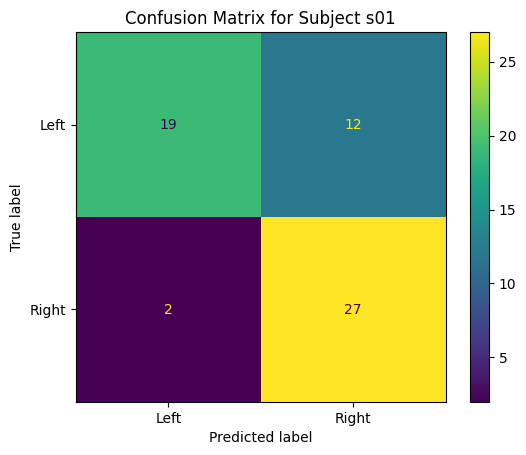

Classification accuracy for s01: 76.67%
Weighted F1-score: 0.76

Classification Report:
               precision    recall  f1-score   support

        Left       0.90      0.61      0.73        31
       Right       0.69      0.93      0.79        29

    accuracy                           0.77        60
   macro avg       0.80      0.77      0.76        60
weighted avg       0.80      0.77      0.76        60

Processing subject: s03
Computing rank from data with rank=None
    Using tolerance 6.1e+03 (2.2e-16 eps * 64 dim * 4.3e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


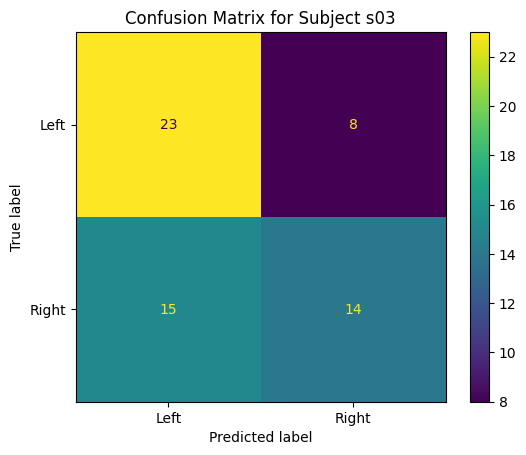

Classification accuracy for s03: 61.67%
Weighted F1-score: 0.61

Classification Report:
               precision    recall  f1-score   support

        Left       0.61      0.74      0.67        31
       Right       0.64      0.48      0.55        29

    accuracy                           0.62        60
   macro avg       0.62      0.61      0.61        60
weighted avg       0.62      0.62      0.61        60

Processing subject: s04
Computing rank from data with rank=None
    Using tolerance 1.2e+04 (2.2e-16 eps * 64 dim * 8.2e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


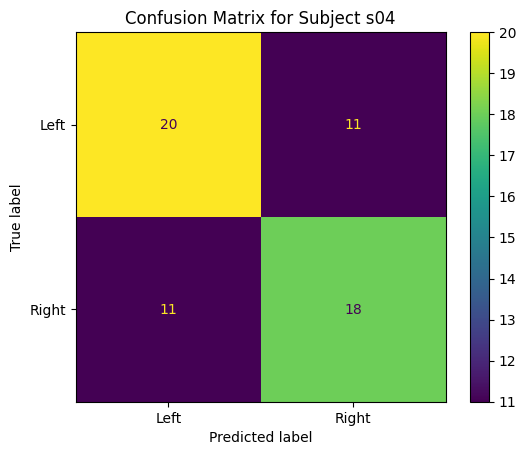

Classification accuracy for s04: 63.33%
Weighted F1-score: 0.63

Classification Report:
               precision    recall  f1-score   support

        Left       0.65      0.65      0.65        31
       Right       0.62      0.62      0.62        29

    accuracy                           0.63        60
   macro avg       0.63      0.63      0.63        60
weighted avg       0.63      0.63      0.63        60

Processing subject: s05
Computing rank from data with rank=None
    Using tolerance 1.4e+04 (2.2e-16 eps * 64 dim * 9.6e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


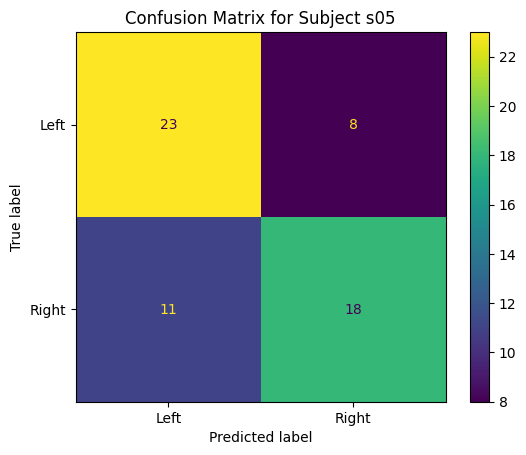

Classification accuracy for s05: 68.33%
Weighted F1-score: 0.68

Classification Report:
               precision    recall  f1-score   support

        Left       0.68      0.74      0.71        31
       Right       0.69      0.62      0.65        29

    accuracy                           0.68        60
   macro avg       0.68      0.68      0.68        60
weighted avg       0.68      0.68      0.68        60

Processing subject: s06
Computing rank from data with rank=None
    Using tolerance 4.4e+03 (2.2e-16 eps * 64 dim * 3.1e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


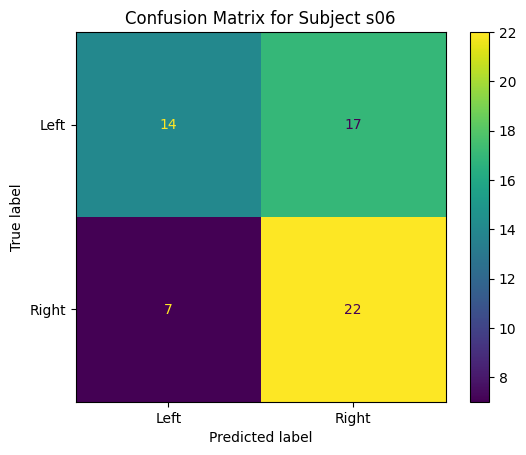

Classification accuracy for s06: 60.00%
Weighted F1-score: 0.59

Classification Report:
               precision    recall  f1-score   support

        Left       0.67      0.45      0.54        31
       Right       0.56      0.76      0.65        29

    accuracy                           0.60        60
   macro avg       0.62      0.61      0.59        60
weighted avg       0.62      0.60      0.59        60

Processing subject: s09
Computing rank from data with rank=None
    Using tolerance 5.9e+03 (2.2e-16 eps * 64 dim * 4.2e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


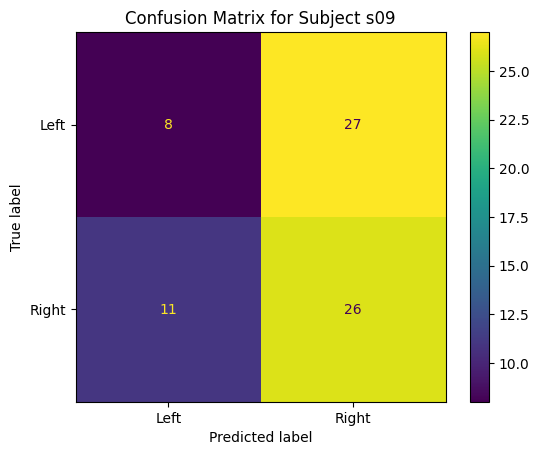

Classification accuracy for s09: 47.22%
Weighted F1-score: 0.44

Classification Report:
               precision    recall  f1-score   support

        Left       0.42      0.23      0.30        35
       Right       0.49      0.70      0.58        37

    accuracy                           0.47        72
   macro avg       0.46      0.47      0.44        72
weighted avg       0.46      0.47      0.44        72

Processing subject: s10
Computing rank from data with rank=None
    Using tolerance 1e+04 (2.2e-16 eps * 64 dim * 7e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


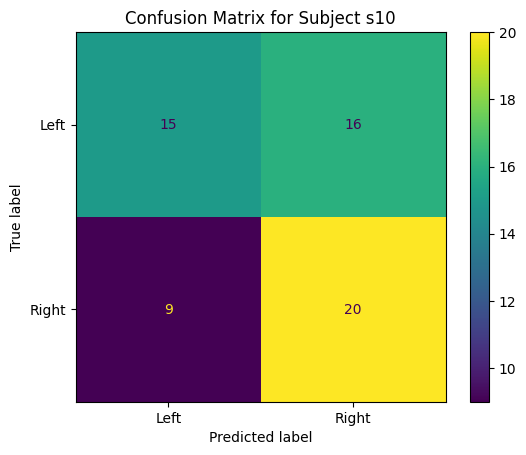

Classification accuracy for s10: 58.33%
Weighted F1-score: 0.58

Classification Report:
               precision    recall  f1-score   support

        Left       0.62      0.48      0.55        31
       Right       0.56      0.69      0.62        29

    accuracy                           0.58        60
   macro avg       0.59      0.59      0.58        60
weighted avg       0.59      0.58      0.58        60

Processing subject: s13
Computing rank from data with rank=None
    Using tolerance 7.8e+03 (2.2e-16 eps * 64 dim * 5.5e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


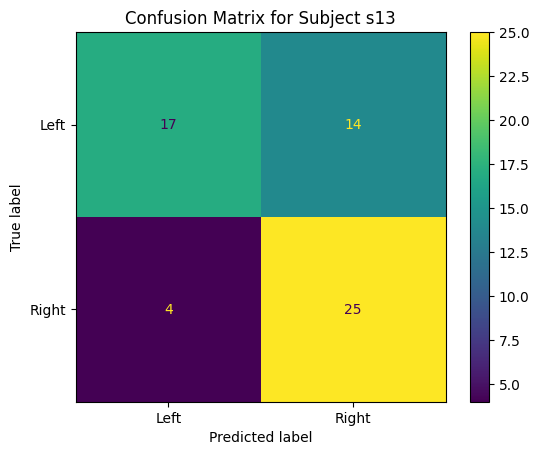

Classification accuracy for s13: 70.00%
Weighted F1-score: 0.69

Classification Report:
               precision    recall  f1-score   support

        Left       0.81      0.55      0.65        31
       Right       0.64      0.86      0.74        29

    accuracy                           0.70        60
   macro avg       0.73      0.71      0.69        60
weighted avg       0.73      0.70      0.69        60

Processing subject: s14
Computing rank from data with rank=None
    Using tolerance 1.2e+04 (2.2e-16 eps * 64 dim * 8.1e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


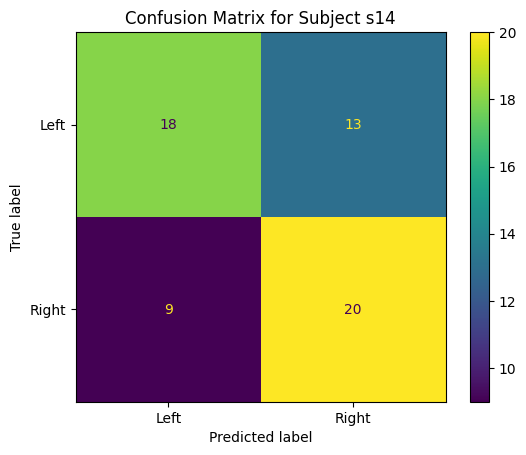

Classification accuracy for s14: 63.33%
Weighted F1-score: 0.63

Classification Report:
               precision    recall  f1-score   support

        Left       0.67      0.58      0.62        31
       Right       0.61      0.69      0.65        29

    accuracy                           0.63        60
   macro avg       0.64      0.64      0.63        60
weighted avg       0.64      0.63      0.63        60

Processing subject: s33
Computing rank from data with rank=None
    Using tolerance 1e+04 (2.2e-16 eps * 64 dim * 7.1e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


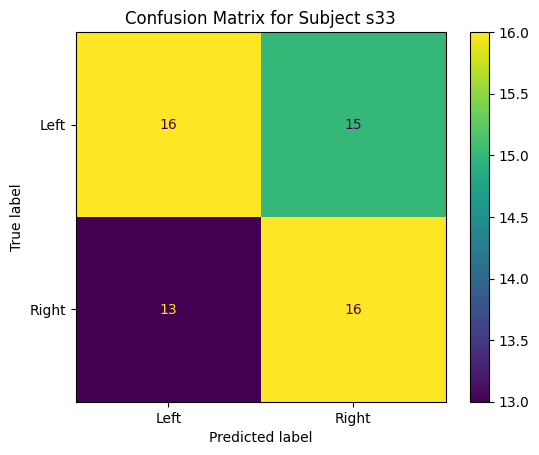

Classification accuracy for s33: 53.33%
Weighted F1-score: 0.53

Classification Report:
               precision    recall  f1-score   support

        Left       0.55      0.52      0.53        31
       Right       0.52      0.55      0.53        29

    accuracy                           0.53        60
   macro avg       0.53      0.53      0.53        60
weighted avg       0.53      0.53      0.53        60

Processing subject: s35
Computing rank from data with rank=None
    Using tolerance 4.3e+03 (2.2e-16 eps * 64 dim * 3.1e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


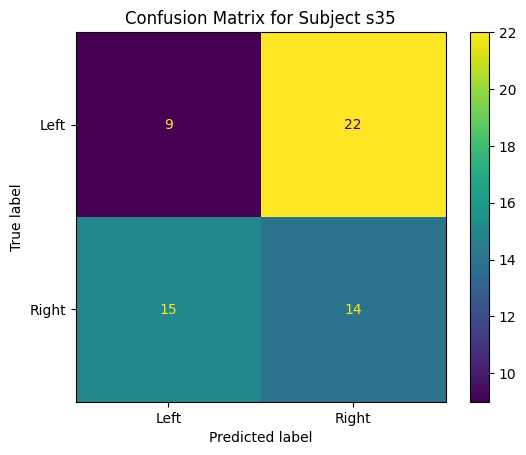

Classification accuracy for s35: 38.33%
Weighted F1-score: 0.38

Classification Report:
               precision    recall  f1-score   support

        Left       0.38      0.29      0.33        31
       Right       0.39      0.48      0.43        29

    accuracy                           0.38        60
   macro avg       0.38      0.39      0.38        60
weighted avg       0.38      0.38      0.38        60

Processing subject: s41
Computing rank from data with rank=None
    Using tolerance 1.1e+04 (2.2e-16 eps * 64 dim * 7.9e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


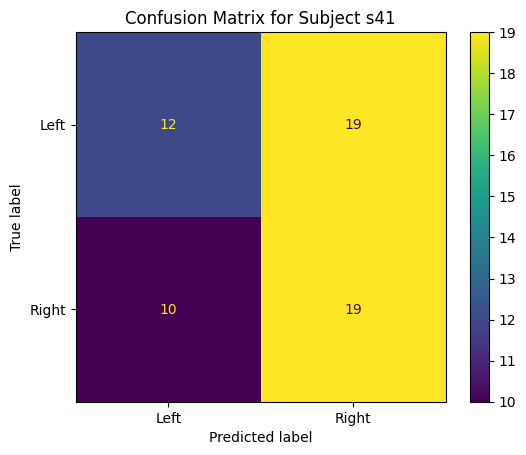

Classification accuracy for s41: 51.67%
Weighted F1-score: 0.51

Classification Report:
               precision    recall  f1-score   support

        Left       0.55      0.39      0.45        31
       Right       0.50      0.66      0.57        29

    accuracy                           0.52        60
   macro avg       0.52      0.52      0.51        60
weighted avg       0.52      0.52      0.51        60

Processing subject: s43
Computing rank from data with rank=None
    Using tolerance 5.9e+03 (2.2e-16 eps * 64 dim * 4.2e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


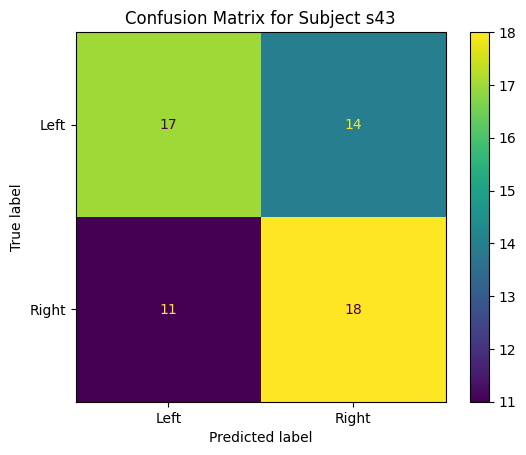

Classification accuracy for s43: 58.33%
Weighted F1-score: 0.58

Classification Report:
               precision    recall  f1-score   support

        Left       0.61      0.55      0.58        31
       Right       0.56      0.62      0.59        29

    accuracy                           0.58        60
   macro avg       0.58      0.58      0.58        60
weighted avg       0.59      0.58      0.58        60

Processing subject: s44
Computing rank from data with rank=None
    Using tolerance 1e+04 (2.2e-16 eps * 64 dim * 7.3e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


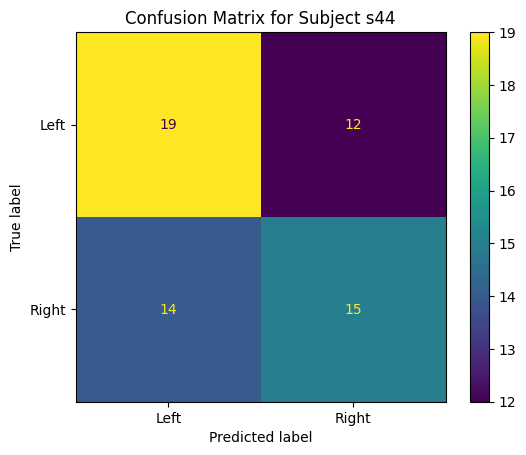

Classification accuracy for s44: 56.67%
Weighted F1-score: 0.57

Classification Report:
               precision    recall  f1-score   support

        Left       0.58      0.61      0.59        31
       Right       0.56      0.52      0.54        29

    accuracy                           0.57        60
   macro avg       0.57      0.57      0.56        60
weighted avg       0.57      0.57      0.57        60

Processing subject: s46
Computing rank from data with rank=None
    Using tolerance 1.6e+04 (2.2e-16 eps * 64 dim * 1.1e+18  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


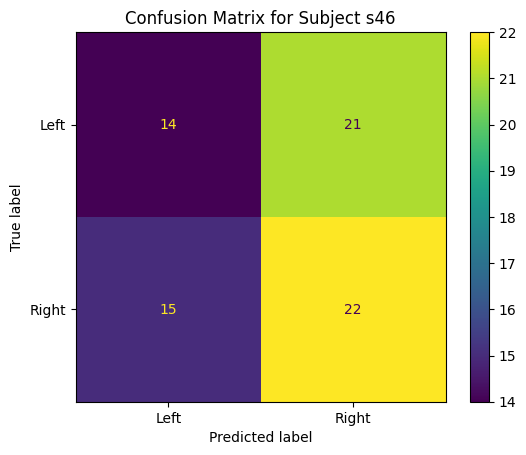

Classification accuracy for s46: 50.00%
Weighted F1-score: 0.50

Classification Report:
               precision    recall  f1-score   support

        Left       0.48      0.40      0.44        35
       Right       0.51      0.59      0.55        37

    accuracy                           0.50        72
   macro avg       0.50      0.50      0.49        72
weighted avg       0.50      0.50      0.50        72

Processing subject: s48
Computing rank from data with rank=None
    Using tolerance 1.6e+04 (2.2e-16 eps * 64 dim * 1.1e+18  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


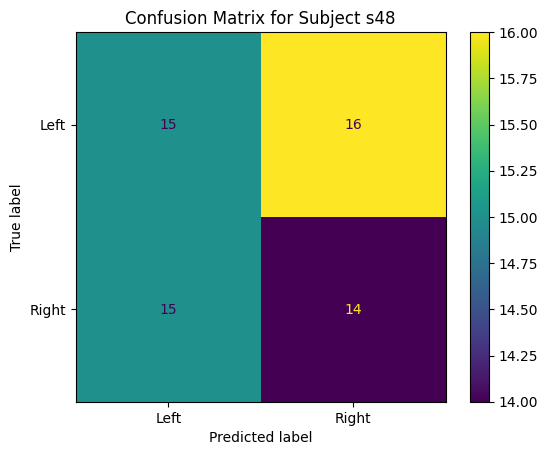

Classification accuracy for s48: 48.33%
Weighted F1-score: 0.48

Classification Report:
               precision    recall  f1-score   support

        Left       0.50      0.48      0.49        31
       Right       0.47      0.48      0.47        29

    accuracy                           0.48        60
   macro avg       0.48      0.48      0.48        60
weighted avg       0.48      0.48      0.48        60

Processing subject: s49
Computing rank from data with rank=None
    Using tolerance 9.6e+03 (2.2e-16 eps * 64 dim * 6.8e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


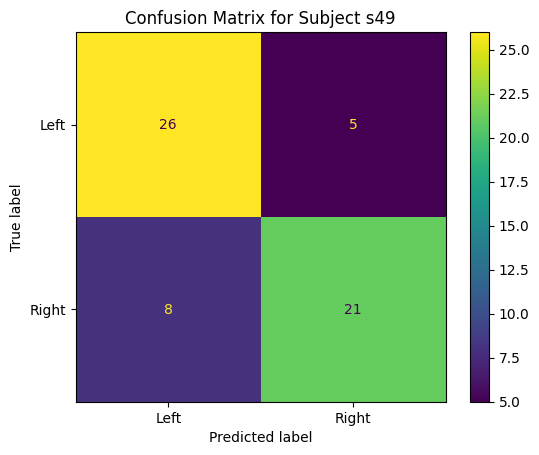

Classification accuracy for s49: 78.33%
Weighted F1-score: 0.78

Classification Report:
               precision    recall  f1-score   support

        Left       0.76      0.84      0.80        31
       Right       0.81      0.72      0.76        29

    accuracy                           0.78        60
   macro avg       0.79      0.78      0.78        60
weighted avg       0.79      0.78      0.78        60

Processing subject: s50
Computing rank from data with rank=None
    Using tolerance 7.6e+03 (2.2e-16 eps * 64 dim * 5.3e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


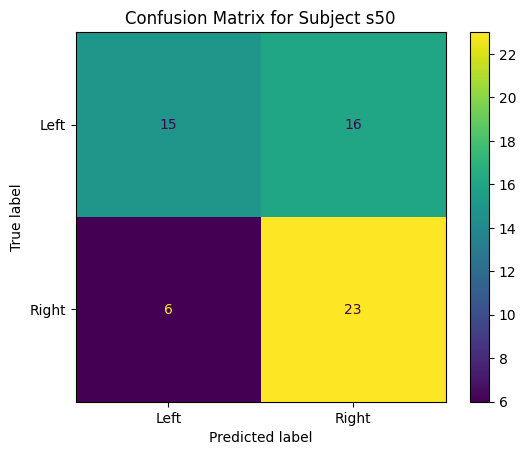

Classification accuracy for s50: 63.33%
Weighted F1-score: 0.63

Classification Report:
               precision    recall  f1-score   support

        Left       0.71      0.48      0.58        31
       Right       0.59      0.79      0.68        29

    accuracy                           0.63        60
   macro avg       0.65      0.64      0.63        60
weighted avg       0.65      0.63      0.63        60

Processing subject: s52
Computing rank from data with rank=None
    Using tolerance 6.8e+03 (2.2e-16 eps * 64 dim * 4.8e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


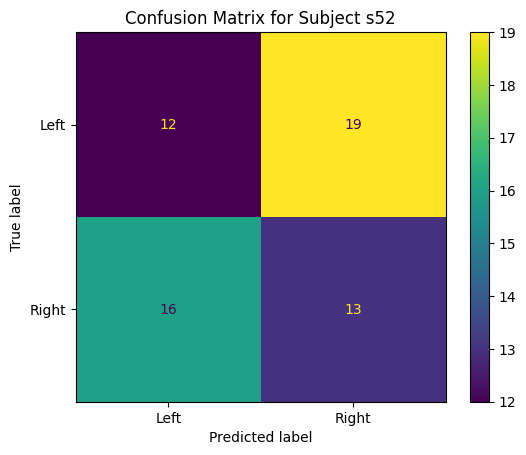

Classification accuracy for s52: 41.67%
Weighted F1-score: 0.42

Classification Report:
               precision    recall  f1-score   support

        Left       0.43      0.39      0.41        31
       Right       0.41      0.45      0.43        29

    accuracy                           0.42        60
   macro avg       0.42      0.42      0.42        60
weighted avg       0.42      0.42      0.42        60



In [14]:
# Dictionary to store classification accuracy for each subject
classification_results = {}

# Iterate over each subject's EEG data and perform classification
for subject, eeg_data_list in filtered_data_after_bad_trial_removal.items():
    print(f"Processing subject: {subject}")

    # Convert each trial's RawArray to numpy and check consistency
    processed_data = []
    for trial_data in eeg_data_list:
        # Convert RawArray to numpy
        trial_numpy = trial_data.get_data()
        
        # Ensure all trials have the same shape
        if processed_data and trial_numpy.shape != processed_data[0].shape:
            # Adjust shape by truncating or padding
            min_shape = (processed_data[0].shape[0], min(processed_data[0].shape[1], trial_numpy.shape[1]))
            adjusted_trial = np.zeros(processed_data[0].shape)
            adjusted_trial[:, :min_shape[1]] = trial_numpy[:, :min_shape[1]]
            processed_data.append(adjusted_trial)
        else:
            processed_data.append(trial_numpy)

    # Convert processed data to a consistent 3D array
    X = np.stack(processed_data)  # Shape should be (n_trials, n_channels, n_times)
    y = labels_per_subject[subject]  # Corresponding labels for this subject

    # Check shape consistency
    if X.shape[0] != len(y):
        print(f"Mismatch in trial counts for subject {subject}. X shape: {X.shape}, y length: {len(y)}")
        continue

    # Step 1: Apply CSP (Common Spatial Patterns) for feature extraction
    csp = CSP(n_components=2, reg=None, log=True)
    X_csp = csp.fit_transform(X, y)

    # Step 2: Perform 7:3 train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_csp, y, test_size=0.3, random_state=42)

    # Step 3: Perform classification using FLDA (Fisher's Linear Discriminant Analysis)
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = lda.predict(X_test)

    # Step 4: Compute and display the confusion matrix for the subject
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Left', 'Right'])
    disp.plot()
    plt.title(f"Confusion Matrix for Subject {subject}")
    plt.show()

    # Step 5: Calculate and store classification accuracy for this subject
    accuracy = np.mean(y_test == y_pred)
    classification_results[subject] = accuracy
    print(f"Classification accuracy for {subject}: {accuracy * 100:.2f}%")

    
    # F1-score 계산 및 출력
    f1 = f1_score(y_test, y_pred, average='weighted')  # 'weighted'는 클래스 불균형이 있을 때 사용, 'macro'는 각 클래스에 동일한 가중치 부여
    print(f"Weighted F1-score: {f1:.2f}")
    
    # 클래스별 Precision, Recall, F1-score 및 Accuracy 등 출력
    report = classification_report(y_test, y_pred, target_names=['Left', 'Right'])
    print("\nClassification Report:\n", report)


In [ ]:
X

In [ ]:
X_train

In [ ]:
X_test

#### **Support Vector Machine**

In [23]:
from sklearn.svm import SVC

Processing subject: s01
Computing rank from data with rank=None
    Using tolerance 1e+04 (2.2e-16 eps * 64 dim * 7.3e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


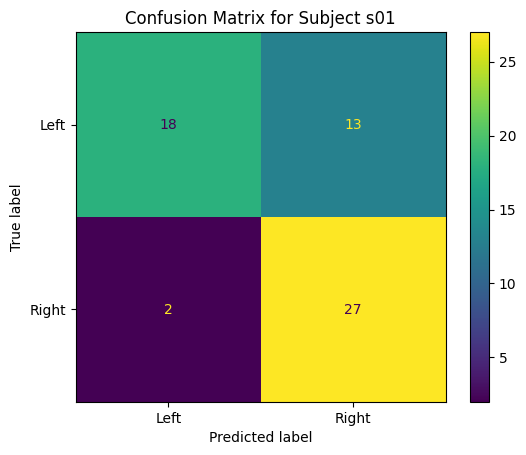

Classification accuracy for s01: 75.00%
Weighted F1-score: 0.74

Classification Report:
               precision    recall  f1-score   support

        Left       0.90      0.58      0.71        31
       Right       0.68      0.93      0.78        29

    accuracy                           0.75        60
   macro avg       0.79      0.76      0.74        60
weighted avg       0.79      0.75      0.74        60

Processing subject: s03
Computing rank from data with rank=None
    Using tolerance 6.1e+03 (2.2e-16 eps * 64 dim * 4.3e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


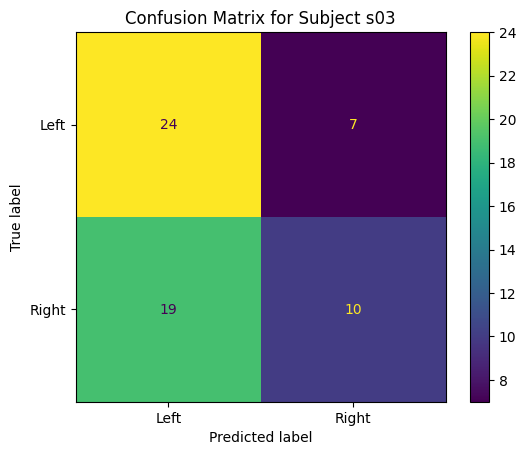

Classification accuracy for s03: 56.67%
Weighted F1-score: 0.55

Classification Report:
               precision    recall  f1-score   support

        Left       0.56      0.77      0.65        31
       Right       0.59      0.34      0.43        29

    accuracy                           0.57        60
   macro avg       0.57      0.56      0.54        60
weighted avg       0.57      0.57      0.55        60

Processing subject: s04
Computing rank from data with rank=None
    Using tolerance 1.2e+04 (2.2e-16 eps * 64 dim * 8.2e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


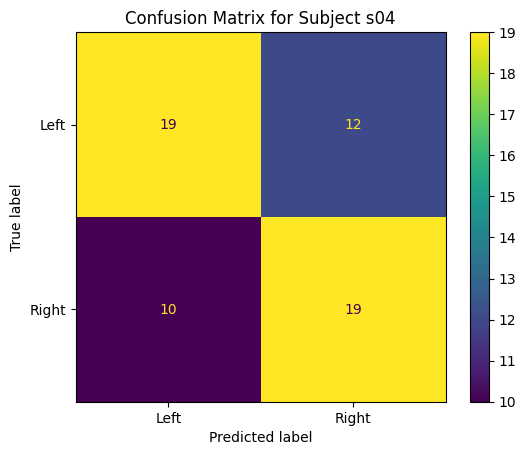

Classification accuracy for s04: 63.33%
Weighted F1-score: 0.63

Classification Report:
               precision    recall  f1-score   support

        Left       0.66      0.61      0.63        31
       Right       0.61      0.66      0.63        29

    accuracy                           0.63        60
   macro avg       0.63      0.63      0.63        60
weighted avg       0.63      0.63      0.63        60

Processing subject: s05
Computing rank from data with rank=None
    Using tolerance 1.4e+04 (2.2e-16 eps * 64 dim * 9.6e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


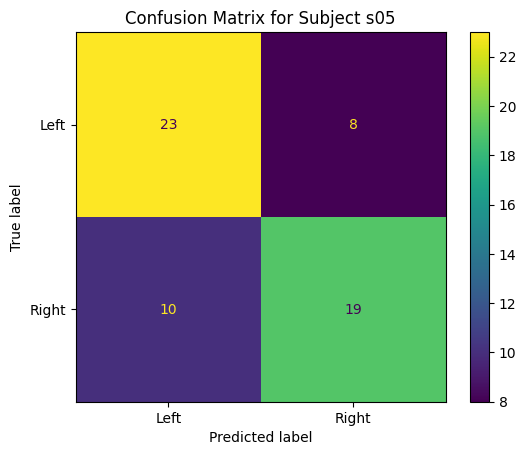

Classification accuracy for s05: 70.00%
Weighted F1-score: 0.70

Classification Report:
               precision    recall  f1-score   support

        Left       0.70      0.74      0.72        31
       Right       0.70      0.66      0.68        29

    accuracy                           0.70        60
   macro avg       0.70      0.70      0.70        60
weighted avg       0.70      0.70      0.70        60

Processing subject: s06
Computing rank from data with rank=None
    Using tolerance 4.4e+03 (2.2e-16 eps * 64 dim * 3.1e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


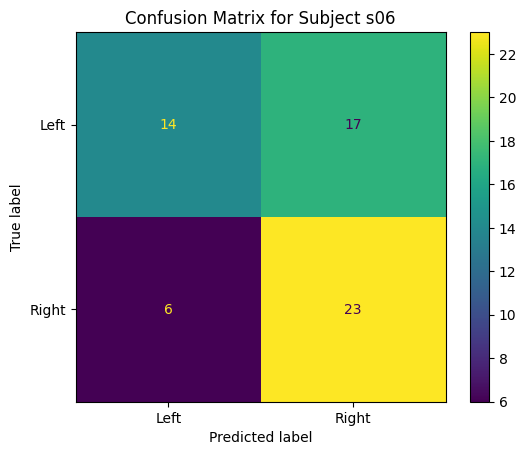

Classification accuracy for s06: 61.67%
Weighted F1-score: 0.61

Classification Report:
               precision    recall  f1-score   support

        Left       0.70      0.45      0.55        31
       Right       0.57      0.79      0.67        29

    accuracy                           0.62        60
   macro avg       0.64      0.62      0.61        60
weighted avg       0.64      0.62      0.61        60

Processing subject: s09
Computing rank from data with rank=None
    Using tolerance 5.9e+03 (2.2e-16 eps * 64 dim * 4.2e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


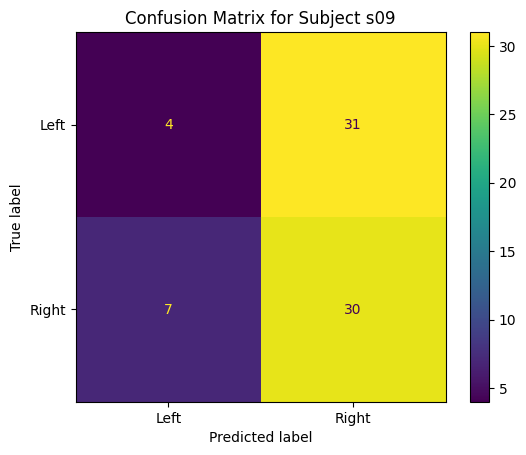

Classification accuracy for s09: 47.22%
Weighted F1-score: 0.40

Classification Report:
               precision    recall  f1-score   support

        Left       0.36      0.11      0.17        35
       Right       0.49      0.81      0.61        37

    accuracy                           0.47        72
   macro avg       0.43      0.46      0.39        72
weighted avg       0.43      0.47      0.40        72

Processing subject: s10
Computing rank from data with rank=None
    Using tolerance 1e+04 (2.2e-16 eps * 64 dim * 7e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


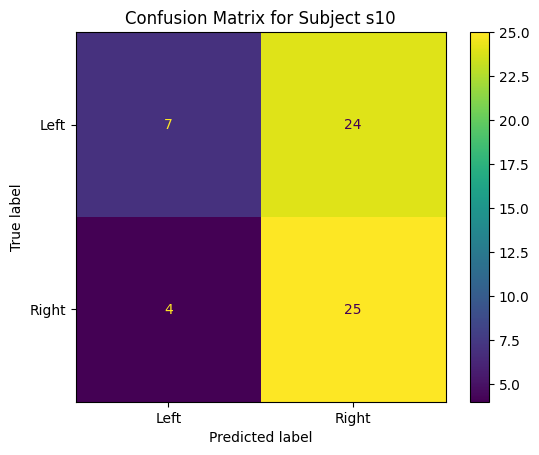

Classification accuracy for s10: 53.33%
Weighted F1-score: 0.48

Classification Report:
               precision    recall  f1-score   support

        Left       0.64      0.23      0.33        31
       Right       0.51      0.86      0.64        29

    accuracy                           0.53        60
   macro avg       0.57      0.54      0.49        60
weighted avg       0.58      0.53      0.48        60

Processing subject: s13
Computing rank from data with rank=None
    Using tolerance 7.8e+03 (2.2e-16 eps * 64 dim * 5.5e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


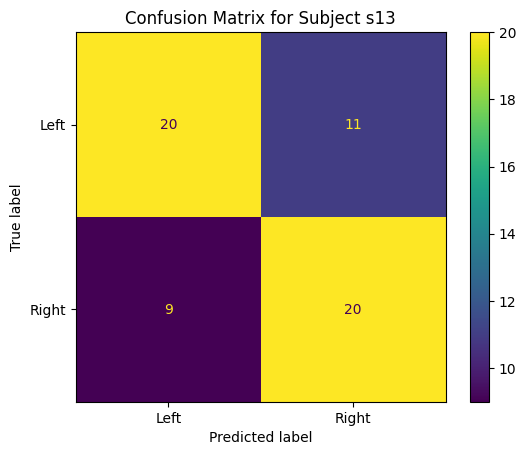

Classification accuracy for s13: 66.67%
Weighted F1-score: 0.67

Classification Report:
               precision    recall  f1-score   support

        Left       0.69      0.65      0.67        31
       Right       0.65      0.69      0.67        29

    accuracy                           0.67        60
   macro avg       0.67      0.67      0.67        60
weighted avg       0.67      0.67      0.67        60

Processing subject: s14
Computing rank from data with rank=None
    Using tolerance 1.2e+04 (2.2e-16 eps * 64 dim * 8.1e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


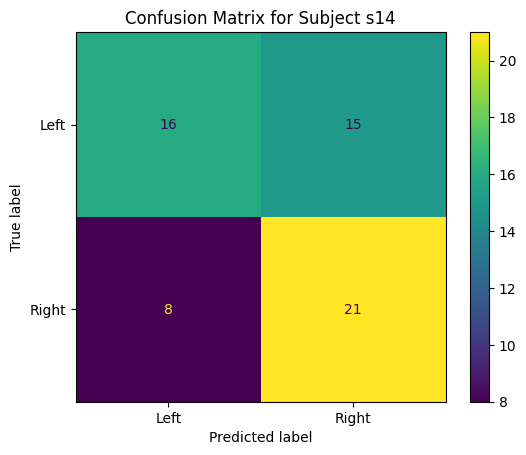

Classification accuracy for s14: 61.67%
Weighted F1-score: 0.61

Classification Report:
               precision    recall  f1-score   support

        Left       0.67      0.52      0.58        31
       Right       0.58      0.72      0.65        29

    accuracy                           0.62        60
   macro avg       0.62      0.62      0.61        60
weighted avg       0.63      0.62      0.61        60

Processing subject: s33
Computing rank from data with rank=None
    Using tolerance 1e+04 (2.2e-16 eps * 64 dim * 7.1e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


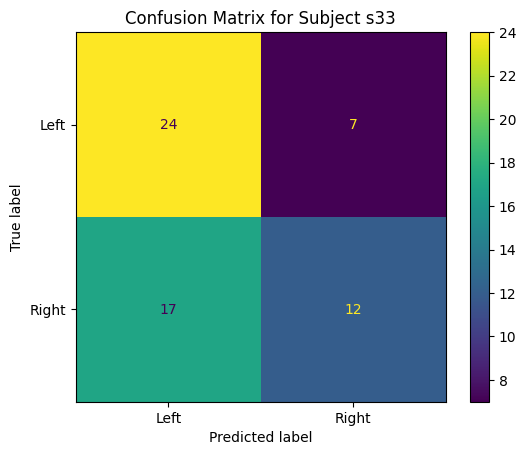

Classification accuracy for s33: 60.00%
Weighted F1-score: 0.59

Classification Report:
               precision    recall  f1-score   support

        Left       0.59      0.77      0.67        31
       Right       0.63      0.41      0.50        29

    accuracy                           0.60        60
   macro avg       0.61      0.59      0.58        60
weighted avg       0.61      0.60      0.59        60

Processing subject: s35
Computing rank from data with rank=None
    Using tolerance 4.3e+03 (2.2e-16 eps * 64 dim * 3.1e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


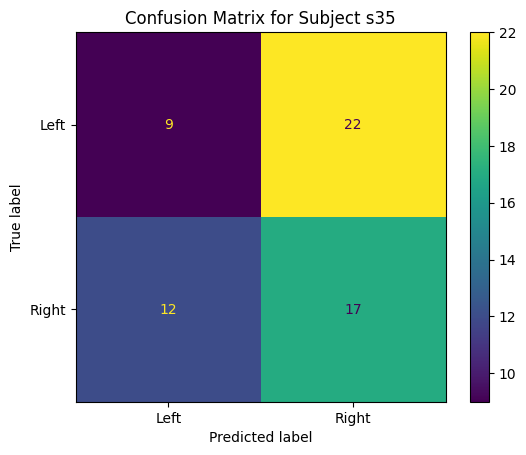

Classification accuracy for s35: 43.33%
Weighted F1-score: 0.42

Classification Report:
               precision    recall  f1-score   support

        Left       0.43      0.29      0.35        31
       Right       0.44      0.59      0.50        29

    accuracy                           0.43        60
   macro avg       0.43      0.44      0.42        60
weighted avg       0.43      0.43      0.42        60

Processing subject: s41
Computing rank from data with rank=None
    Using tolerance 1.1e+04 (2.2e-16 eps * 64 dim * 7.9e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


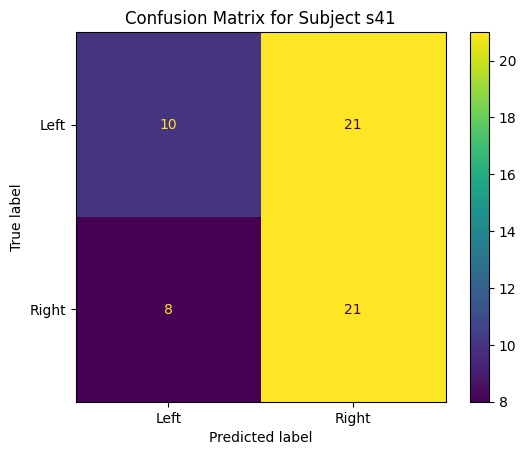

Classification accuracy for s41: 51.67%
Weighted F1-score: 0.50

Classification Report:
               precision    recall  f1-score   support

        Left       0.56      0.32      0.41        31
       Right       0.50      0.72      0.59        29

    accuracy                           0.52        60
   macro avg       0.53      0.52      0.50        60
weighted avg       0.53      0.52      0.50        60

Processing subject: s43
Computing rank from data with rank=None
    Using tolerance 5.9e+03 (2.2e-16 eps * 64 dim * 4.2e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


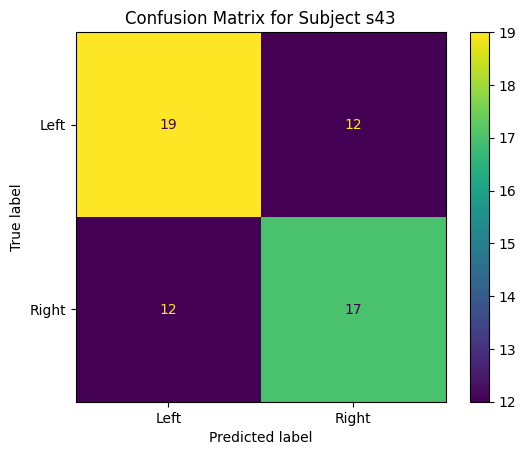

Classification accuracy for s43: 60.00%
Weighted F1-score: 0.60

Classification Report:
               precision    recall  f1-score   support

        Left       0.61      0.61      0.61        31
       Right       0.59      0.59      0.59        29

    accuracy                           0.60        60
   macro avg       0.60      0.60      0.60        60
weighted avg       0.60      0.60      0.60        60

Processing subject: s44
Computing rank from data with rank=None
    Using tolerance 1e+04 (2.2e-16 eps * 64 dim * 7.3e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


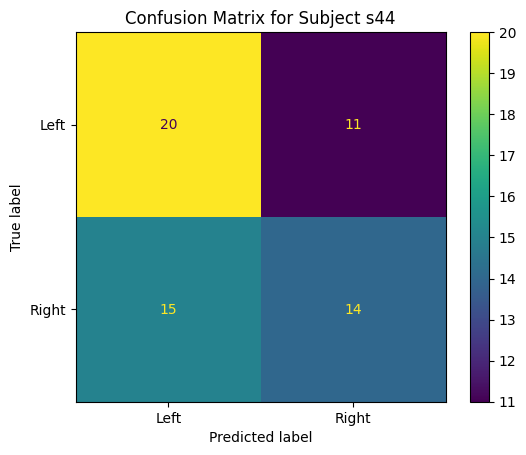

Classification accuracy for s44: 56.67%
Weighted F1-score: 0.56

Classification Report:
               precision    recall  f1-score   support

        Left       0.57      0.65      0.61        31
       Right       0.56      0.48      0.52        29

    accuracy                           0.57        60
   macro avg       0.57      0.56      0.56        60
weighted avg       0.57      0.57      0.56        60

Processing subject: s46
Computing rank from data with rank=None
    Using tolerance 1.6e+04 (2.2e-16 eps * 64 dim * 1.1e+18  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


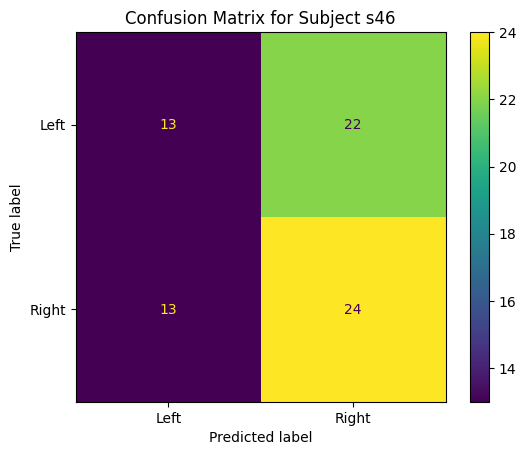

Classification accuracy for s46: 51.39%
Weighted F1-score: 0.50

Classification Report:
               precision    recall  f1-score   support

        Left       0.50      0.37      0.43        35
       Right       0.52      0.65      0.58        37

    accuracy                           0.51        72
   macro avg       0.51      0.51      0.50        72
weighted avg       0.51      0.51      0.50        72

Processing subject: s48
Computing rank from data with rank=None
    Using tolerance 1.6e+04 (2.2e-16 eps * 64 dim * 1.1e+18  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


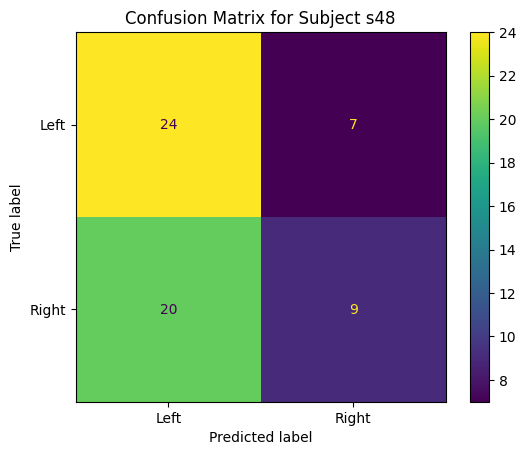

Classification accuracy for s48: 55.00%
Weighted F1-score: 0.52

Classification Report:
               precision    recall  f1-score   support

        Left       0.55      0.77      0.64        31
       Right       0.56      0.31      0.40        29

    accuracy                           0.55        60
   macro avg       0.55      0.54      0.52        60
weighted avg       0.55      0.55      0.52        60

Processing subject: s49
Computing rank from data with rank=None
    Using tolerance 9.6e+03 (2.2e-16 eps * 64 dim * 6.8e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


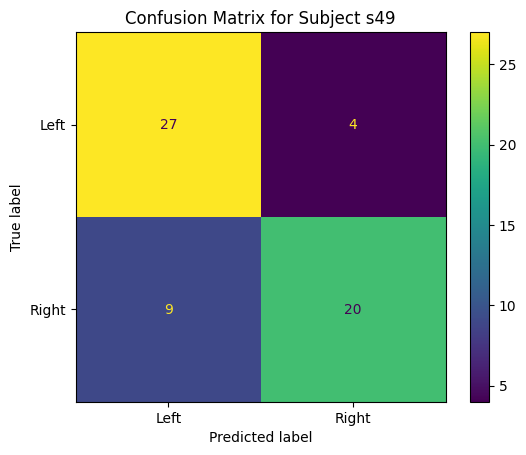

Classification accuracy for s49: 78.33%
Weighted F1-score: 0.78

Classification Report:
               precision    recall  f1-score   support

        Left       0.75      0.87      0.81        31
       Right       0.83      0.69      0.75        29

    accuracy                           0.78        60
   macro avg       0.79      0.78      0.78        60
weighted avg       0.79      0.78      0.78        60

Processing subject: s50
Computing rank from data with rank=None
    Using tolerance 7.6e+03 (2.2e-16 eps * 64 dim * 5.3e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


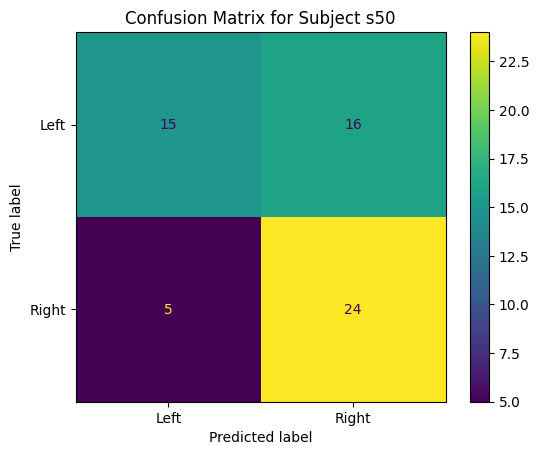

Classification accuracy for s50: 65.00%
Weighted F1-score: 0.64

Classification Report:
               precision    recall  f1-score   support

        Left       0.75      0.48      0.59        31
       Right       0.60      0.83      0.70        29

    accuracy                           0.65        60
   macro avg       0.68      0.66      0.64        60
weighted avg       0.68      0.65      0.64        60

Processing subject: s52
Computing rank from data with rank=None
    Using tolerance 6.8e+03 (2.2e-16 eps * 64 dim * 4.8e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


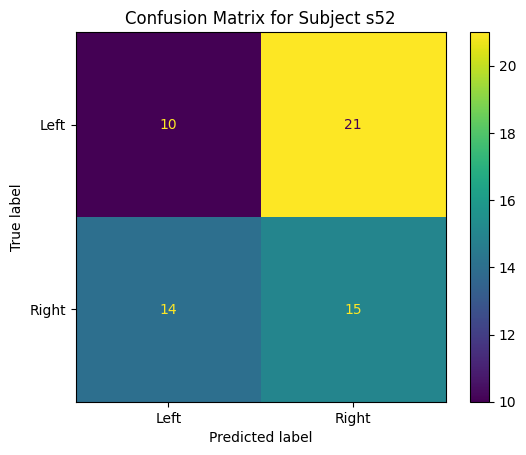

Classification accuracy for s52: 41.67%
Weighted F1-score: 0.41

Classification Report:
               precision    recall  f1-score   support

        Left       0.42      0.32      0.36        31
       Right       0.42      0.52      0.46        29

    accuracy                           0.42        60
   macro avg       0.42      0.42      0.41        60
weighted avg       0.42      0.42      0.41        60



In [17]:
# Dictionary to store classification accuracy for each subject
classification_results = {}

# Iterate over each subject's EEG data and perform classification
for subject, eeg_data_list in filtered_data_after_bad_trial_removal.items():
    print(f"Processing subject: {subject}")

    # Convert each trial's RawArray to numpy and check consistency
    processed_data = []
    for trial_data in eeg_data_list:
        # Convert RawArray to numpy
        trial_numpy = trial_data.get_data()
        
        # Ensure all trials have the same shape
        if processed_data and trial_numpy.shape != processed_data[0].shape:
            # Adjust shape by truncating or padding
            min_shape = (processed_data[0].shape[0], min(processed_data[0].shape[1], trial_numpy.shape[1]))
            adjusted_trial = np.zeros(processed_data[0].shape)
            adjusted_trial[:, :min_shape[1]] = trial_numpy[:, :min_shape[1]]
            processed_data.append(adjusted_trial)
        else:
            processed_data.append(trial_numpy)

    # Convert processed data to a consistent 3D array
    X = np.stack(processed_data)  # Shape should be (n_trials, n_channels, n_times)
    y = labels_per_subject[subject]  # Corresponding labels for this subject

    # Check shape consistency
    if X.shape[0] != len(y):
        print(f"Mismatch in trial counts for subject {subject}. X shape: {X.shape}, y length: {len(y)}")
        continue

    # Step 1: Apply CSP (Common Spatial Patterns) for feature extraction
    csp = CSP(n_components=2, reg=None, log=True)
    X_csp = csp.fit_transform(X, y)

    # Step 2: Perform 7:3 train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_csp, y, test_size=0.3, random_state=42)

    # Step 3: Support Vector Machine(SVM)을 적용
    model = SVC(kernel='linear')  # 또는 'rbf', 'poly' 등으로 커널 변경 가능
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Step 4: Compute and display the confusion matrix for the subject
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Left', 'Right'])
    disp.plot()
    plt.title(f"Confusion Matrix for Subject {subject}")
    plt.show()

    # Step 5: Calculate and store classification accuracy for this subject
    accuracy = np.mean(y_test == y_pred)
    classification_results[subject] = accuracy
    print(f"Classification accuracy for {subject}: {accuracy * 100:.2f}%")
    
    # F1-score 계산 및 출력
    f1 = f1_score(y_test, y_pred, average='weighted')  # 'weighted'는 클래스 불균형이 있을 때 사용, 'macro'는 각 클래스에 동일한 가중치 부여
    print(f"Weighted F1-score: {f1:.2f}")
    
    # 클래스별 Precision, Recall, F1-score 및 Accuracy 등 출력
    report = classification_report(y_test, y_pred, target_names=['Left', 'Right'])
    print("\nClassification Report:\n", report)


#### **Stochastic Gradient Descent**

In [15]:
from sklearn.linear_model import SGDClassifier

Processing subject: s01
Computing rank from data with rank=None
    Using tolerance 1e+04 (2.2e-16 eps * 64 dim * 7.3e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


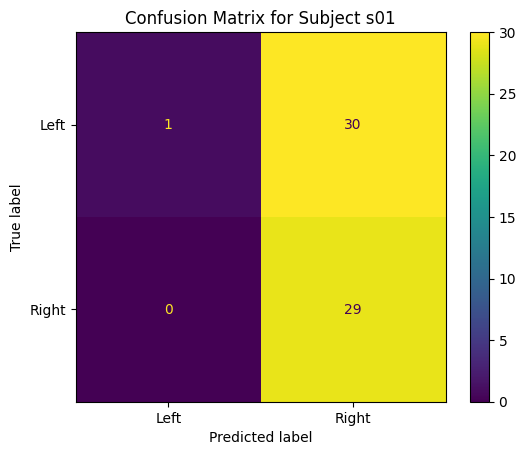

Classification accuracy for s01: 50.00%
Weighted F1-score: 0.35

Classification Report:
               precision    recall  f1-score   support

        Left       1.00      0.03      0.06        31
       Right       0.49      1.00      0.66        29

    accuracy                           0.50        60
   macro avg       0.75      0.52      0.36        60
weighted avg       0.75      0.50      0.35        60

Processing subject: s03
Computing rank from data with rank=None
    Using tolerance 6.1e+03 (2.2e-16 eps * 64 dim * 4.3e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


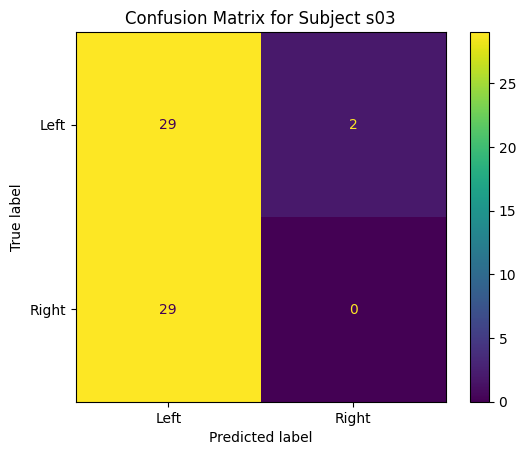

Classification accuracy for s03: 48.33%
Weighted F1-score: 0.34

Classification Report:
               precision    recall  f1-score   support

        Left       0.50      0.94      0.65        31
       Right       0.00      0.00      0.00        29

    accuracy                           0.48        60
   macro avg       0.25      0.47      0.33        60
weighted avg       0.26      0.48      0.34        60

Processing subject: s04
Computing rank from data with rank=None
    Using tolerance 1.2e+04 (2.2e-16 eps * 64 dim * 8.2e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


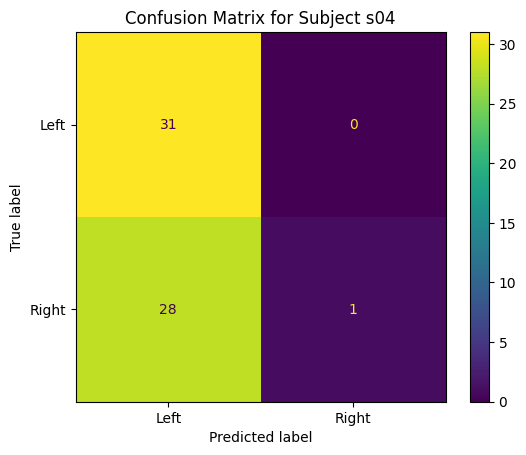

Classification accuracy for s04: 53.33%
Weighted F1-score: 0.39

Classification Report:
               precision    recall  f1-score   support

        Left       0.53      1.00      0.69        31
       Right       1.00      0.03      0.07        29

    accuracy                           0.53        60
   macro avg       0.76      0.52      0.38        60
weighted avg       0.75      0.53      0.39        60

Processing subject: s05
Computing rank from data with rank=None
    Using tolerance 1.4e+04 (2.2e-16 eps * 64 dim * 9.6e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


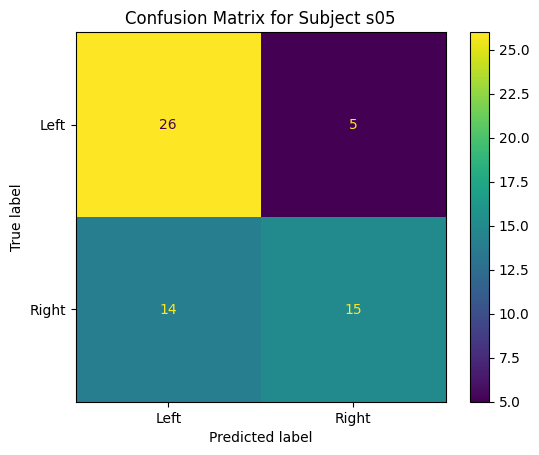

Classification accuracy for s05: 68.33%
Weighted F1-score: 0.67

Classification Report:
               precision    recall  f1-score   support

        Left       0.65      0.84      0.73        31
       Right       0.75      0.52      0.61        29

    accuracy                           0.68        60
   macro avg       0.70      0.68      0.67        60
weighted avg       0.70      0.68      0.67        60

Processing subject: s06
Computing rank from data with rank=None
    Using tolerance 4.4e+03 (2.2e-16 eps * 64 dim * 3.1e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


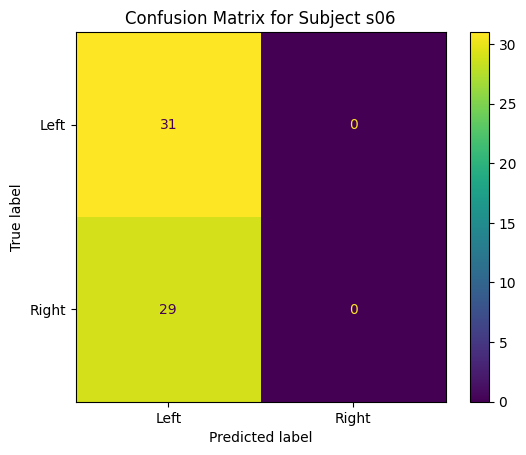

Classification accuracy for s06: 51.67%
Weighted F1-score: 0.35

Classification Report:
               precision    recall  f1-score   support

        Left       0.52      1.00      0.68        31
       Right       0.00      0.00      0.00        29

    accuracy                           0.52        60
   macro avg       0.26      0.50      0.34        60
weighted avg       0.27      0.52      0.35        60

Processing subject: s09
Computing rank from data with rank=None


c:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


    Using tolerance 5.9e+03 (2.2e-16 eps * 64 dim * 4.2e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


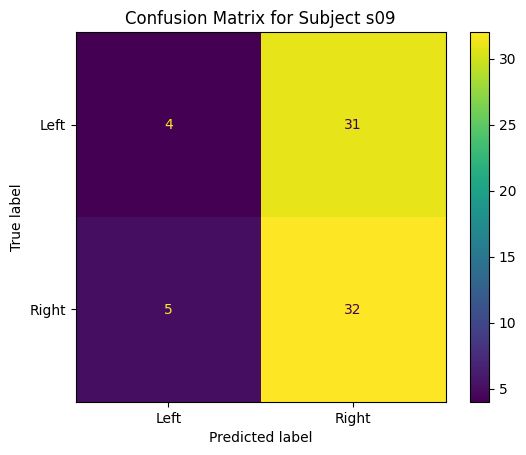

Classification accuracy for s09: 50.00%
Weighted F1-score: 0.42

Classification Report:
               precision    recall  f1-score   support

        Left       0.44      0.11      0.18        35
       Right       0.51      0.86      0.64        37

    accuracy                           0.50        72
   macro avg       0.48      0.49      0.41        72
weighted avg       0.48      0.50      0.42        72

Processing subject: s10
Computing rank from data with rank=None
    Using tolerance 1e+04 (2.2e-16 eps * 64 dim * 7e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


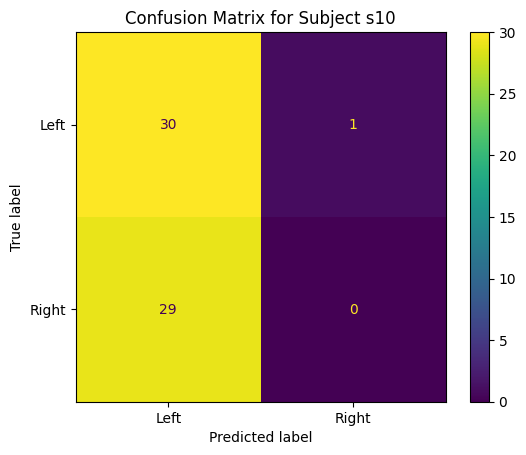

Classification accuracy for s10: 50.00%
Weighted F1-score: 0.34

Classification Report:
               precision    recall  f1-score   support

        Left       0.51      0.97      0.67        31
       Right       0.00      0.00      0.00        29

    accuracy                           0.50        60
   macro avg       0.25      0.48      0.33        60
weighted avg       0.26      0.50      0.34        60

Processing subject: s13
Computing rank from data with rank=None
    Using tolerance 7.8e+03 (2.2e-16 eps * 64 dim * 5.5e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


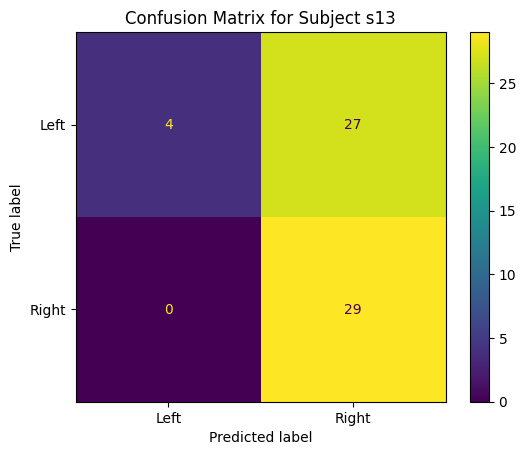

Classification accuracy for s13: 55.00%
Weighted F1-score: 0.45

Classification Report:
               precision    recall  f1-score   support

        Left       1.00      0.13      0.23        31
       Right       0.52      1.00      0.68        29

    accuracy                           0.55        60
   macro avg       0.76      0.56      0.46        60
weighted avg       0.77      0.55      0.45        60

Processing subject: s14
Computing rank from data with rank=None
    Using tolerance 1.2e+04 (2.2e-16 eps * 64 dim * 8.1e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


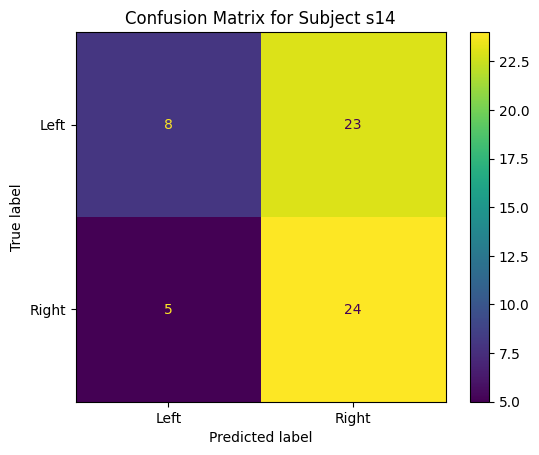

Classification accuracy for s14: 53.33%
Weighted F1-score: 0.49

Classification Report:
               precision    recall  f1-score   support

        Left       0.62      0.26      0.36        31
       Right       0.51      0.83      0.63        29

    accuracy                           0.53        60
   macro avg       0.56      0.54      0.50        60
weighted avg       0.56      0.53      0.49        60

Processing subject: s33
Computing rank from data with rank=None
    Using tolerance 1e+04 (2.2e-16 eps * 64 dim * 7.1e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


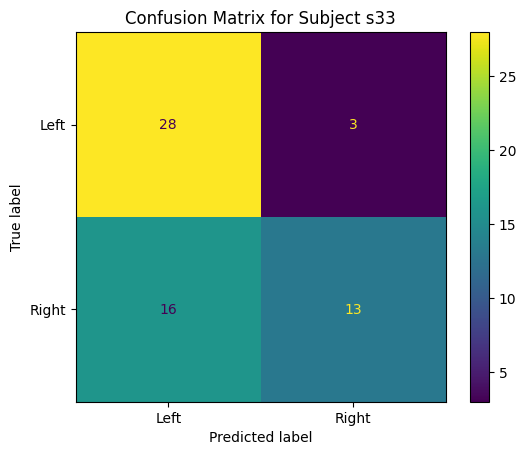

Classification accuracy for s33: 68.33%
Weighted F1-score: 0.67

Classification Report:
               precision    recall  f1-score   support

        Left       0.64      0.90      0.75        31
       Right       0.81      0.45      0.58        29

    accuracy                           0.68        60
   macro avg       0.72      0.68      0.66        60
weighted avg       0.72      0.68      0.67        60

Processing subject: s35
Computing rank from data with rank=None
    Using tolerance 4.3e+03 (2.2e-16 eps * 64 dim * 3.1e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


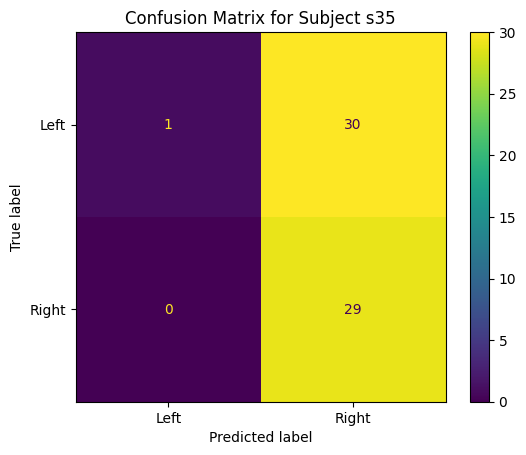

Classification accuracy for s35: 50.00%
Weighted F1-score: 0.35

Classification Report:
               precision    recall  f1-score   support

        Left       1.00      0.03      0.06        31
       Right       0.49      1.00      0.66        29

    accuracy                           0.50        60
   macro avg       0.75      0.52      0.36        60
weighted avg       0.75      0.50      0.35        60

Processing subject: s41
Computing rank from data with rank=None
    Using tolerance 1.1e+04 (2.2e-16 eps * 64 dim * 7.9e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


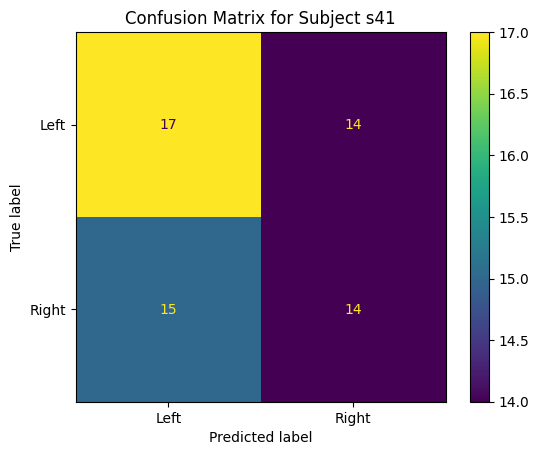

Classification accuracy for s41: 51.67%
Weighted F1-score: 0.52

Classification Report:
               precision    recall  f1-score   support

        Left       0.53      0.55      0.54        31
       Right       0.50      0.48      0.49        29

    accuracy                           0.52        60
   macro avg       0.52      0.52      0.52        60
weighted avg       0.52      0.52      0.52        60

Processing subject: s43
Computing rank from data with rank=None
    Using tolerance 5.9e+03 (2.2e-16 eps * 64 dim * 4.2e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


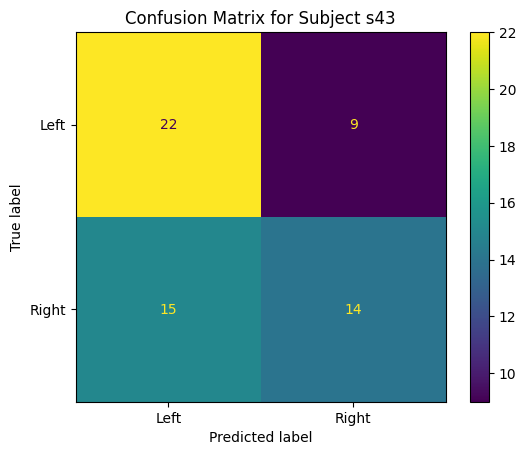

Classification accuracy for s43: 60.00%
Weighted F1-score: 0.59

Classification Report:
               precision    recall  f1-score   support

        Left       0.59      0.71      0.65        31
       Right       0.61      0.48      0.54        29

    accuracy                           0.60        60
   macro avg       0.60      0.60      0.59        60
weighted avg       0.60      0.60      0.59        60

Processing subject: s44
Computing rank from data with rank=None
    Using tolerance 1e+04 (2.2e-16 eps * 64 dim * 7.3e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


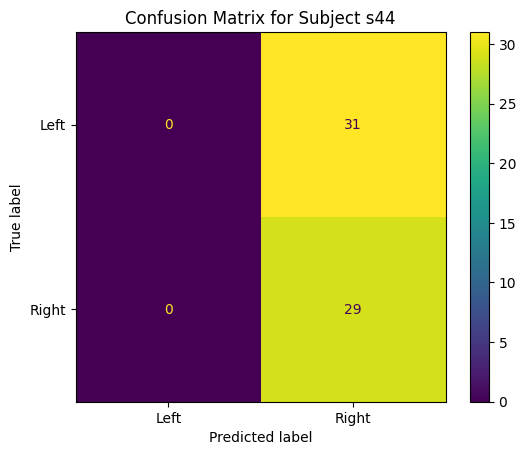

Classification accuracy for s44: 48.33%
Weighted F1-score: 0.31

Classification Report:
               precision    recall  f1-score   support

        Left       0.00      0.00      0.00        31
       Right       0.48      1.00      0.65        29

    accuracy                           0.48        60
   macro avg       0.24      0.50      0.33        60
weighted avg       0.23      0.48      0.31        60

Processing subject: s46
Computing rank from data with rank=None


c:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


    Using tolerance 1.6e+04 (2.2e-16 eps * 64 dim * 1.1e+18  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


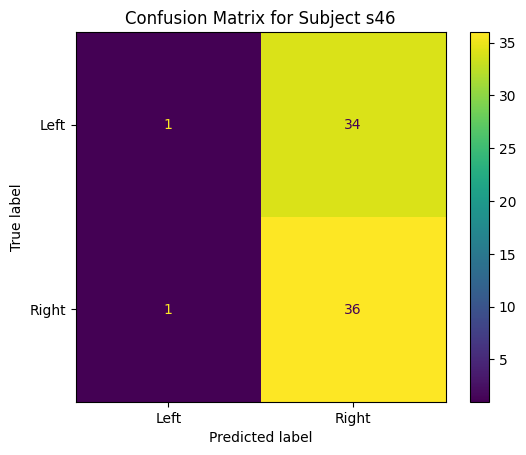

Classification accuracy for s46: 51.39%
Weighted F1-score: 0.37

Classification Report:
               precision    recall  f1-score   support

        Left       0.50      0.03      0.05        35
       Right       0.51      0.97      0.67        37

    accuracy                           0.51        72
   macro avg       0.51      0.50      0.36        72
weighted avg       0.51      0.51      0.37        72

Processing subject: s48
Computing rank from data with rank=None
    Using tolerance 1.6e+04 (2.2e-16 eps * 64 dim * 1.1e+18  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


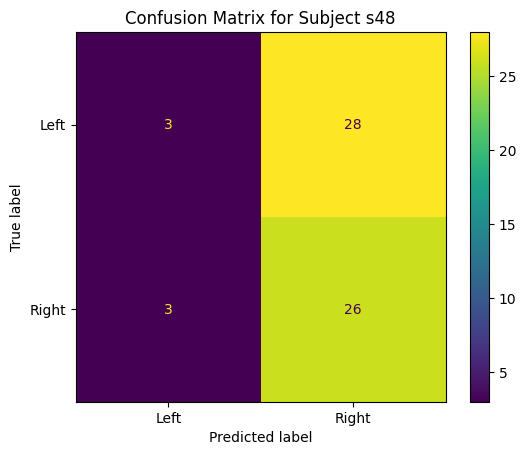

Classification accuracy for s48: 48.33%
Weighted F1-score: 0.39

Classification Report:
               precision    recall  f1-score   support

        Left       0.50      0.10      0.16        31
       Right       0.48      0.90      0.63        29

    accuracy                           0.48        60
   macro avg       0.49      0.50      0.39        60
weighted avg       0.49      0.48      0.39        60

Processing subject: s49
Computing rank from data with rank=None
    Using tolerance 9.6e+03 (2.2e-16 eps * 64 dim * 6.8e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


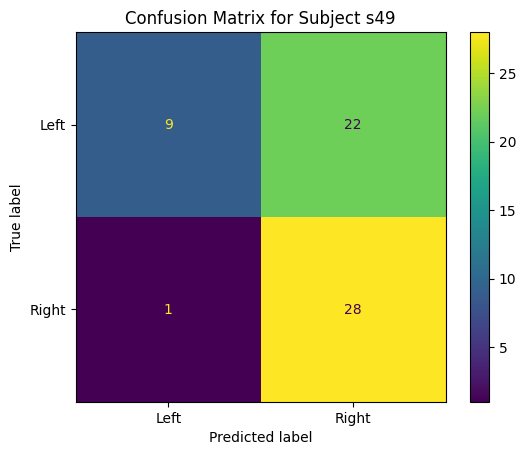

Classification accuracy for s49: 61.67%
Weighted F1-score: 0.57

Classification Report:
               precision    recall  f1-score   support

        Left       0.90      0.29      0.44        31
       Right       0.56      0.97      0.71        29

    accuracy                           0.62        60
   macro avg       0.73      0.63      0.57        60
weighted avg       0.74      0.62      0.57        60

Processing subject: s50
Computing rank from data with rank=None
    Using tolerance 7.6e+03 (2.2e-16 eps * 64 dim * 5.3e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


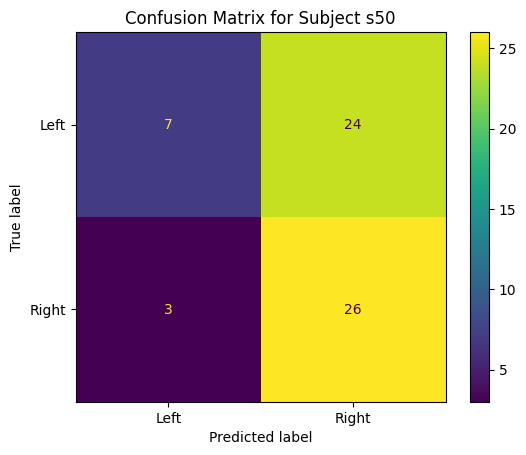

Classification accuracy for s50: 55.00%
Weighted F1-score: 0.49

Classification Report:
               precision    recall  f1-score   support

        Left       0.70      0.23      0.34        31
       Right       0.52      0.90      0.66        29

    accuracy                           0.55        60
   macro avg       0.61      0.56      0.50        60
weighted avg       0.61      0.55      0.49        60

Processing subject: s52
Computing rank from data with rank=None
    Using tolerance 6.8e+03 (2.2e-16 eps * 64 dim * 4.8e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


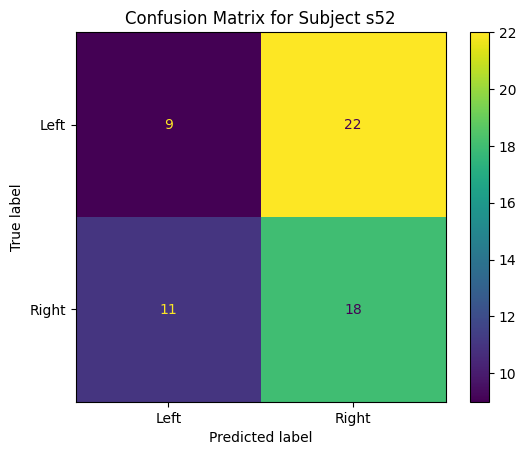

Classification accuracy for s52: 45.00%
Weighted F1-score: 0.43

Classification Report:
               precision    recall  f1-score   support

        Left       0.45      0.29      0.35        31
       Right       0.45      0.62      0.52        29

    accuracy                           0.45        60
   macro avg       0.45      0.46      0.44        60
weighted avg       0.45      0.45      0.43        60



In [16]:
# Dictionary to store classification accuracy for each subject
classification_results = {}

# Iterate over each subject's EEG data and perform classification
for subject, eeg_data_list in filtered_data_after_bad_trial_removal.items():
    print(f"Processing subject: {subject}")

    # Convert each trial's RawArray to numpy and check consistency
    processed_data = []
    for trial_data in eeg_data_list:
        # Convert RawArray to numpy
        trial_numpy = trial_data.get_data()
        
        # Ensure all trials have the same shape
        if processed_data and trial_numpy.shape != processed_data[0].shape:
            # Adjust shape by truncating or padding
            min_shape = (processed_data[0].shape[0], min(processed_data[0].shape[1], trial_numpy.shape[1]))
            adjusted_trial = np.zeros(processed_data[0].shape)
            adjusted_trial[:, :min_shape[1]] = trial_numpy[:, :min_shape[1]]
            processed_data.append(adjusted_trial)
        else:
            processed_data.append(trial_numpy)

    # Convert processed data to a consistent 3D array
    X = np.stack(processed_data)  # Shape should be (n_trials, n_channels, n_times)
    y = labels_per_subject[subject]  # Corresponding labels for this subject

    # Check shape consistency
    if X.shape[0] != len(y):
        print(f"Mismatch in trial counts for subject {subject}. X shape: {X.shape}, y length: {len(y)}")
        continue

    # Step 1: Apply CSP (Common Spatial Patterns) for feature extraction
    csp = CSP(n_components=2, reg=None, log=True)
    X_csp = csp.fit_transform(X, y)

    # Step 2: Perform 7:3 train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_csp, y, test_size=0.3, random_state=42)

    # Step 3: Classification using SGD
    model = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Step 4: Compute and display the confusion matrix for the subject
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Left', 'Right'])
    disp.plot()
    plt.title(f"Confusion Matrix for Subject {subject}")
    plt.show()

    # Step 5: Calculate and store classification accuracy for this subject
    accuracy = np.mean(y_test == y_pred)
    classification_results[subject] = accuracy
    print(f"Classification accuracy for {subject}: {accuracy * 100:.2f}%")
    
    # F1-score 계산 및 출력
    f1 = f1_score(y_test, y_pred, average='weighted')  # 'weighted'는 클래스 불균형이 있을 때 사용, 'macro'는 각 클래스에 동일한 가중치 부여
    print(f"Weighted F1-score: {f1:.2f}")
    
    # 클래스별 Precision, Recall, F1-score 및 Accuracy 등 출력
    report = classification_report(y_test, y_pred, target_names=['Left', 'Right'])
    print("\nClassification Report:\n", report)


#### **Multi Layer Perception**

In [17]:
from sklearn.neural_network import MLPClassifier

Processing subject: s01
Computing rank from data with rank=None
    Using tolerance 1e+04 (2.2e-16 eps * 64 dim * 7.3e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


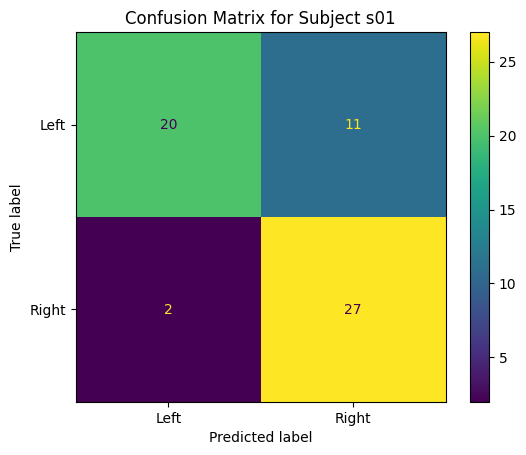

Classification accuracy for s01: 78.33%
Weighted F1-score: 0.78

Classification Report:
               precision    recall  f1-score   support

        Left       0.91      0.65      0.75        31
       Right       0.71      0.93      0.81        29

    accuracy                           0.78        60
   macro avg       0.81      0.79      0.78        60
weighted avg       0.81      0.78      0.78        60

Processing subject: s03
Computing rank from data with rank=None
    Using tolerance 6.1e+03 (2.2e-16 eps * 64 dim * 4.3e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


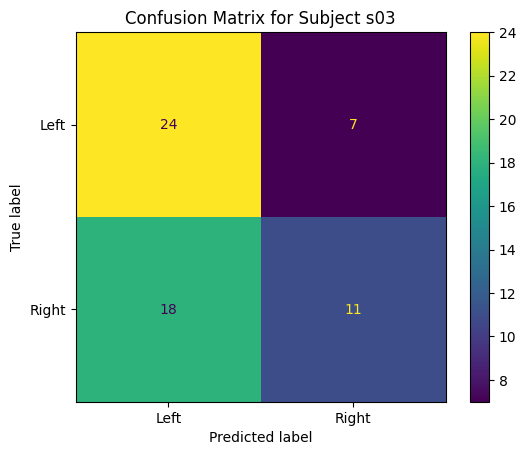

Classification accuracy for s03: 58.33%
Weighted F1-score: 0.57

Classification Report:
               precision    recall  f1-score   support

        Left       0.57      0.77      0.66        31
       Right       0.61      0.38      0.47        29

    accuracy                           0.58        60
   macro avg       0.59      0.58      0.56        60
weighted avg       0.59      0.58      0.57        60

Processing subject: s04
Computing rank from data with rank=None
    Using tolerance 1.2e+04 (2.2e-16 eps * 64 dim * 8.2e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


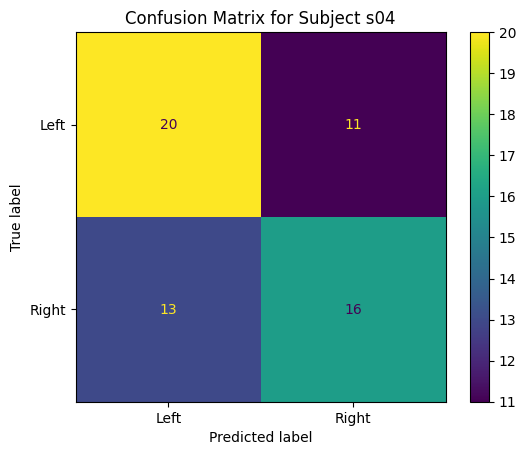

Classification accuracy for s04: 60.00%
Weighted F1-score: 0.60

Classification Report:
               precision    recall  f1-score   support

        Left       0.61      0.65      0.62        31
       Right       0.59      0.55      0.57        29

    accuracy                           0.60        60
   macro avg       0.60      0.60      0.60        60
weighted avg       0.60      0.60      0.60        60

Processing subject: s05
Computing rank from data with rank=None
    Using tolerance 1.4e+04 (2.2e-16 eps * 64 dim * 9.6e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


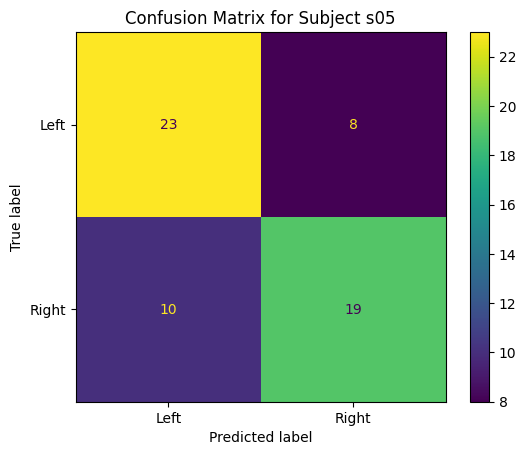

Classification accuracy for s05: 70.00%
Weighted F1-score: 0.70

Classification Report:
               precision    recall  f1-score   support

        Left       0.70      0.74      0.72        31
       Right       0.70      0.66      0.68        29

    accuracy                           0.70        60
   macro avg       0.70      0.70      0.70        60
weighted avg       0.70      0.70      0.70        60

Processing subject: s06
Computing rank from data with rank=None
    Using tolerance 4.4e+03 (2.2e-16 eps * 64 dim * 3.1e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


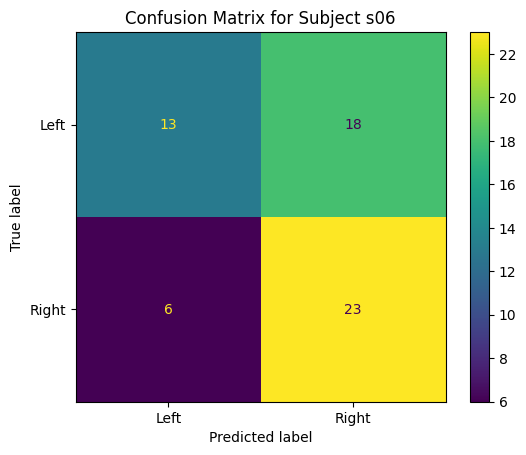

Classification accuracy for s06: 60.00%
Weighted F1-score: 0.59

Classification Report:
               precision    recall  f1-score   support

        Left       0.68      0.42      0.52        31
       Right       0.56      0.79      0.66        29

    accuracy                           0.60        60
   macro avg       0.62      0.61      0.59        60
weighted avg       0.62      0.60      0.59        60

Processing subject: s09
Computing rank from data with rank=None
    Using tolerance 5.9e+03 (2.2e-16 eps * 64 dim * 4.2e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


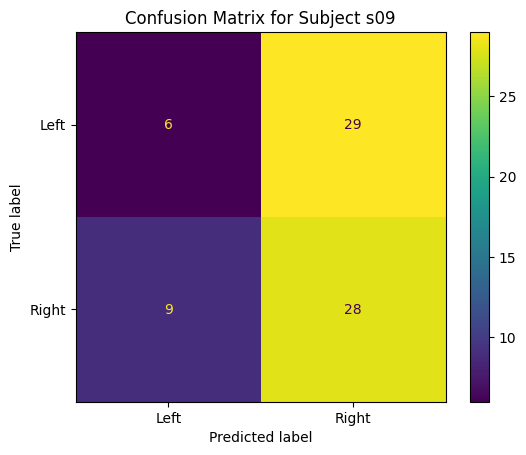

Classification accuracy for s09: 47.22%
Weighted F1-score: 0.42

Classification Report:
               precision    recall  f1-score   support

        Left       0.40      0.17      0.24        35
       Right       0.49      0.76      0.60        37

    accuracy                           0.47        72
   macro avg       0.45      0.46      0.42        72
weighted avg       0.45      0.47      0.42        72

Processing subject: s10
Computing rank from data with rank=None
    Using tolerance 1e+04 (2.2e-16 eps * 64 dim * 7e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


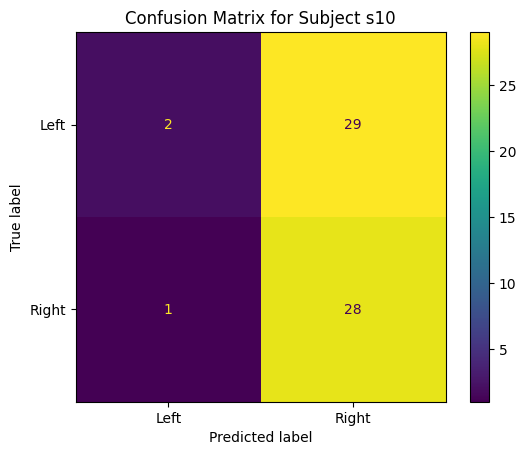

Classification accuracy for s10: 50.00%
Weighted F1-score: 0.38

Classification Report:
               precision    recall  f1-score   support

        Left       0.67      0.06      0.12        31
       Right       0.49      0.97      0.65        29

    accuracy                           0.50        60
   macro avg       0.58      0.52      0.38        60
weighted avg       0.58      0.50      0.38        60

Processing subject: s13
Computing rank from data with rank=None
    Using tolerance 7.8e+03 (2.2e-16 eps * 64 dim * 5.5e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


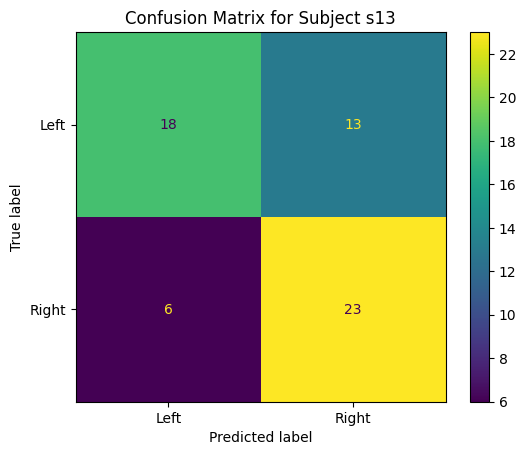

Classification accuracy for s13: 68.33%
Weighted F1-score: 0.68

Classification Report:
               precision    recall  f1-score   support

        Left       0.75      0.58      0.65        31
       Right       0.64      0.79      0.71        29

    accuracy                           0.68        60
   macro avg       0.69      0.69      0.68        60
weighted avg       0.70      0.68      0.68        60

Processing subject: s14
Computing rank from data with rank=None
    Using tolerance 1.2e+04 (2.2e-16 eps * 64 dim * 8.1e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


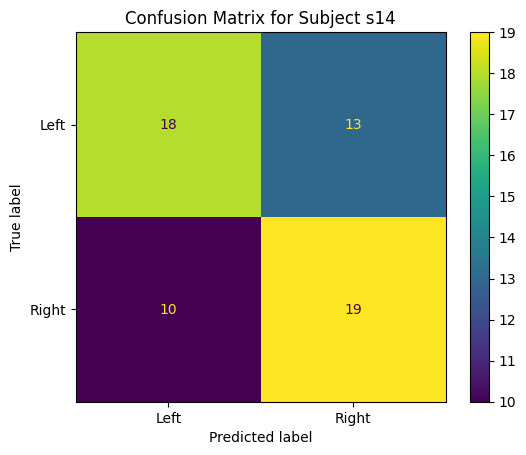

Classification accuracy for s14: 61.67%
Weighted F1-score: 0.62

Classification Report:
               precision    recall  f1-score   support

        Left       0.64      0.58      0.61        31
       Right       0.59      0.66      0.62        29

    accuracy                           0.62        60
   macro avg       0.62      0.62      0.62        60
weighted avg       0.62      0.62      0.62        60

Processing subject: s33
Computing rank from data with rank=None
    Using tolerance 1e+04 (2.2e-16 eps * 64 dim * 7.1e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


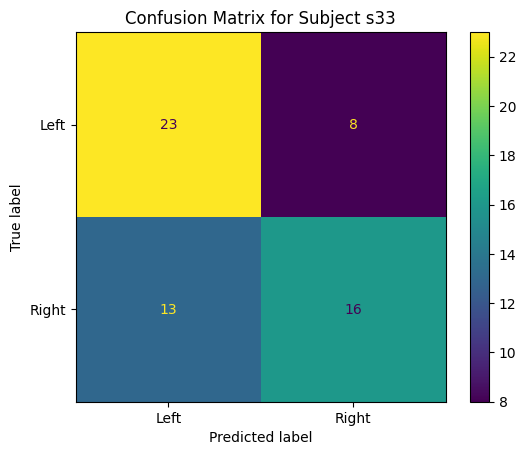

Classification accuracy for s33: 65.00%
Weighted F1-score: 0.65

Classification Report:
               precision    recall  f1-score   support

        Left       0.64      0.74      0.69        31
       Right       0.67      0.55      0.60        29

    accuracy                           0.65        60
   macro avg       0.65      0.65      0.65        60
weighted avg       0.65      0.65      0.65        60

Processing subject: s35
Computing rank from data with rank=None
    Using tolerance 4.3e+03 (2.2e-16 eps * 64 dim * 3.1e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


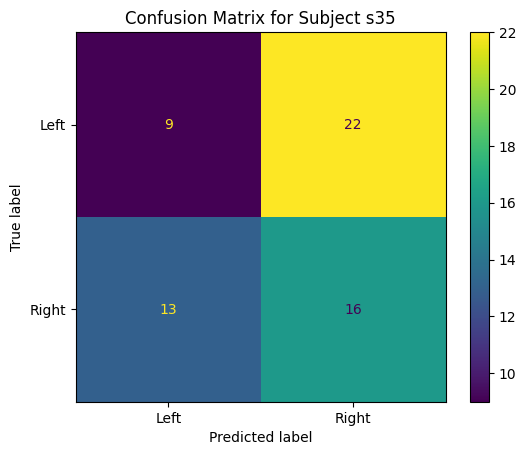

Classification accuracy for s35: 41.67%
Weighted F1-score: 0.41

Classification Report:
               precision    recall  f1-score   support

        Left       0.41      0.29      0.34        31
       Right       0.42      0.55      0.48        29

    accuracy                           0.42        60
   macro avg       0.42      0.42      0.41        60
weighted avg       0.41      0.42      0.41        60

Processing subject: s41
Computing rank from data with rank=None
    Using tolerance 1.1e+04 (2.2e-16 eps * 64 dim * 7.9e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


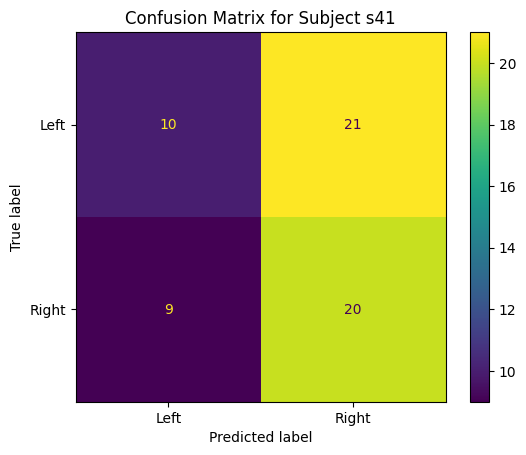

Classification accuracy for s41: 50.00%
Weighted F1-score: 0.48

Classification Report:
               precision    recall  f1-score   support

        Left       0.53      0.32      0.40        31
       Right       0.49      0.69      0.57        29

    accuracy                           0.50        60
   macro avg       0.51      0.51      0.49        60
weighted avg       0.51      0.50      0.48        60

Processing subject: s43
Computing rank from data with rank=None
    Using tolerance 5.9e+03 (2.2e-16 eps * 64 dim * 4.2e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


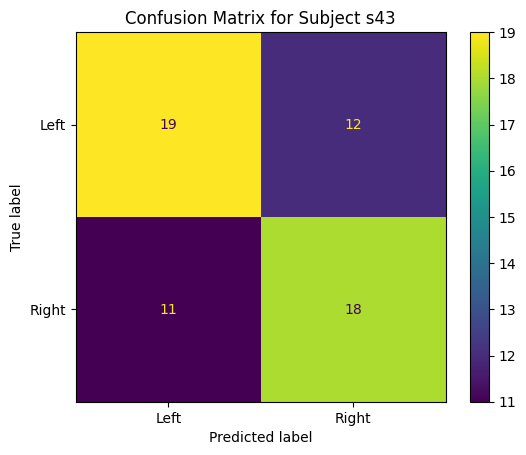

Classification accuracy for s43: 61.67%
Weighted F1-score: 0.62

Classification Report:
               precision    recall  f1-score   support

        Left       0.63      0.61      0.62        31
       Right       0.60      0.62      0.61        29

    accuracy                           0.62        60
   macro avg       0.62      0.62      0.62        60
weighted avg       0.62      0.62      0.62        60

Processing subject: s44
Computing rank from data with rank=None
    Using tolerance 1e+04 (2.2e-16 eps * 64 dim * 7.3e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


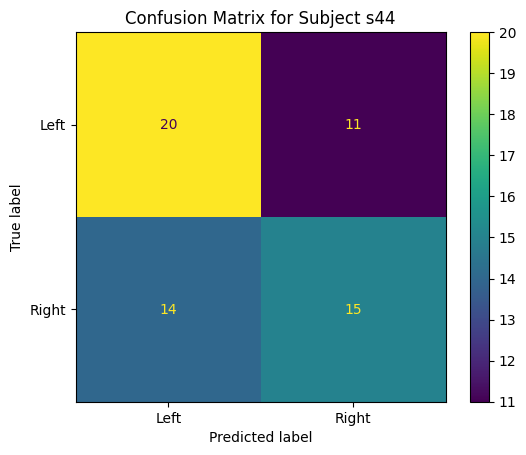

Classification accuracy for s44: 58.33%
Weighted F1-score: 0.58

Classification Report:
               precision    recall  f1-score   support

        Left       0.59      0.65      0.62        31
       Right       0.58      0.52      0.55        29

    accuracy                           0.58        60
   macro avg       0.58      0.58      0.58        60
weighted avg       0.58      0.58      0.58        60

Processing subject: s46
Computing rank from data with rank=None
    Using tolerance 1.6e+04 (2.2e-16 eps * 64 dim * 1.1e+18  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


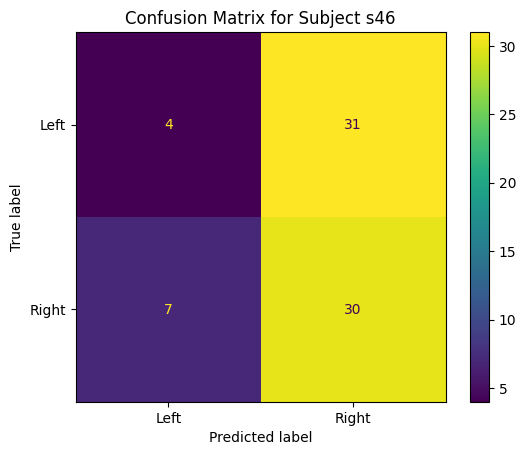

Classification accuracy for s46: 47.22%
Weighted F1-score: 0.40

Classification Report:
               precision    recall  f1-score   support

        Left       0.36      0.11      0.17        35
       Right       0.49      0.81      0.61        37

    accuracy                           0.47        72
   macro avg       0.43      0.46      0.39        72
weighted avg       0.43      0.47      0.40        72

Processing subject: s48
Computing rank from data with rank=None
    Using tolerance 1.6e+04 (2.2e-16 eps * 64 dim * 1.1e+18  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


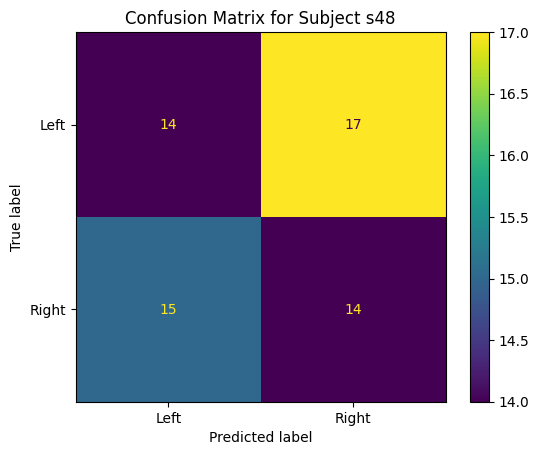

Classification accuracy for s48: 46.67%
Weighted F1-score: 0.47

Classification Report:
               precision    recall  f1-score   support

        Left       0.48      0.45      0.47        31
       Right       0.45      0.48      0.47        29

    accuracy                           0.47        60
   macro avg       0.47      0.47      0.47        60
weighted avg       0.47      0.47      0.47        60

Processing subject: s49
Computing rank from data with rank=None
    Using tolerance 9.6e+03 (2.2e-16 eps * 64 dim * 6.8e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


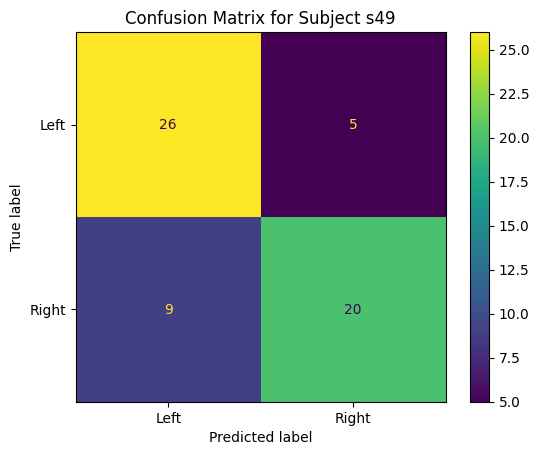

Classification accuracy for s49: 76.67%
Weighted F1-score: 0.77

Classification Report:
               precision    recall  f1-score   support

        Left       0.74      0.84      0.79        31
       Right       0.80      0.69      0.74        29

    accuracy                           0.77        60
   macro avg       0.77      0.76      0.76        60
weighted avg       0.77      0.77      0.77        60

Processing subject: s50
Computing rank from data with rank=None
    Using tolerance 7.6e+03 (2.2e-16 eps * 64 dim * 5.3e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


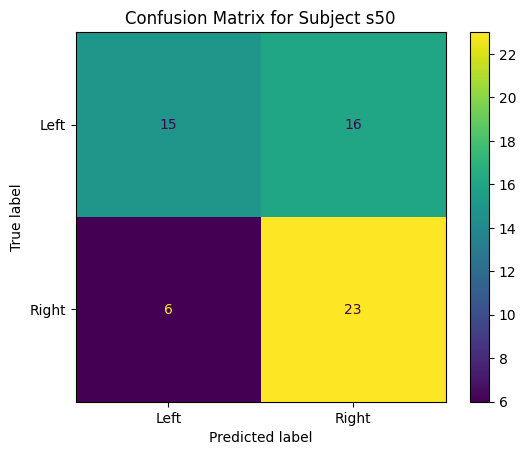

Classification accuracy for s50: 63.33%
Weighted F1-score: 0.63

Classification Report:
               precision    recall  f1-score   support

        Left       0.71      0.48      0.58        31
       Right       0.59      0.79      0.68        29

    accuracy                           0.63        60
   macro avg       0.65      0.64      0.63        60
weighted avg       0.65      0.63      0.63        60

Processing subject: s52
Computing rank from data with rank=None
    Using tolerance 6.8e+03 (2.2e-16 eps * 64 dim * 4.8e+17  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


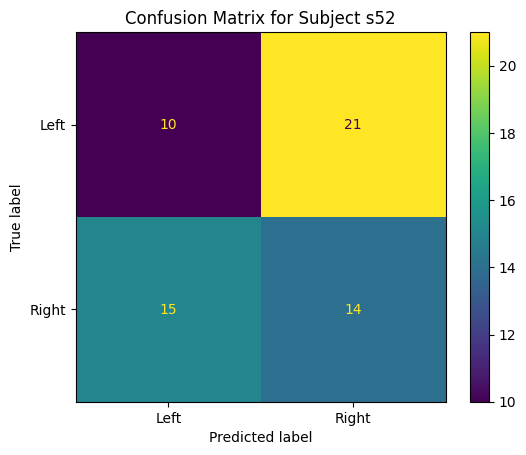

Classification accuracy for s52: 40.00%
Weighted F1-score: 0.40

Classification Report:
               precision    recall  f1-score   support

        Left       0.40      0.32      0.36        31
       Right       0.40      0.48      0.44        29

    accuracy                           0.40        60
   macro avg       0.40      0.40      0.40        60
weighted avg       0.40      0.40      0.40        60



In [18]:
# Dictionary to store classification accuracy for each subject
classification_results = {}

# Iterate over each subject's EEG data and perform classification
for subject, eeg_data_list in filtered_data_after_bad_trial_removal.items():
    print(f"Processing subject: {subject}")

    # Convert each trial's RawArray to numpy and check consistency
    processed_data = []
    for trial_data in eeg_data_list:
        # Convert RawArray to numpy
        trial_numpy = trial_data.get_data()
        
        # Ensure all trials have the same shape
        if processed_data and trial_numpy.shape != processed_data[0].shape:
            # Adjust shape by truncating or padding
            min_shape = (processed_data[0].shape[0], min(processed_data[0].shape[1], trial_numpy.shape[1]))
            adjusted_trial = np.zeros(processed_data[0].shape)
            adjusted_trial[:, :min_shape[1]] = trial_numpy[:, :min_shape[1]]
            processed_data.append(adjusted_trial)
        else:
            processed_data.append(trial_numpy)

    # Convert processed data to a consistent 3D array
    X = np.stack(processed_data)  # Shape should be (n_trials, n_channels, n_times)
    y = labels_per_subject[subject]  # Corresponding labels for this subject

    # Check shape consistency
    if X.shape[0] != len(y):
        print(f"Mismatch in trial counts for subject {subject}. X shape: {X.shape}, y length: {len(y)}")
        continue

    # Step 1: Apply CSP (Common Spatial Patterns) for feature extraction
    csp = CSP(n_components=2, reg=None, log=True)
    X_csp = csp.fit_transform(X, y)

    # Step 2: Perform 7:3 train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_csp, y, test_size=0.3, random_state=42)

    # Step 3: Classification using MLP
    model = MLPClassifier(random_state=42, max_iter=500, hidden_layer_sizes=(100,))
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Step 4: Compute and display the confusion matrix for the subject
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Left', 'Right'])
    disp.plot()
    plt.title(f"Confusion Matrix for Subject {subject}")
    plt.show()

    # Step 5: Calculate and store classification accuracy for this subject
    accuracy = np.mean(y_test == y_pred)
    classification_results[subject] = accuracy
    print(f"Classification accuracy for {subject}: {accuracy * 100:.2f}%")
    
    # F1-score 계산 및 출력
    f1 = f1_score(y_test, y_pred, average='weighted')  # 'weighted'는 클래스 불균형이 있을 때 사용, 'macro'는 각 클래스에 동일한 가중치 부여
    print(f"Weighted F1-score: {f1:.2f}")
    
    # 클래스별 Precision, Recall, F1-score 및 Accuracy 등 출력
    report = classification_report(y_test, y_pred, target_names=['Left', 'Right'])
    print("\nClassification Report:\n", report)


#### **CSP 시각화**

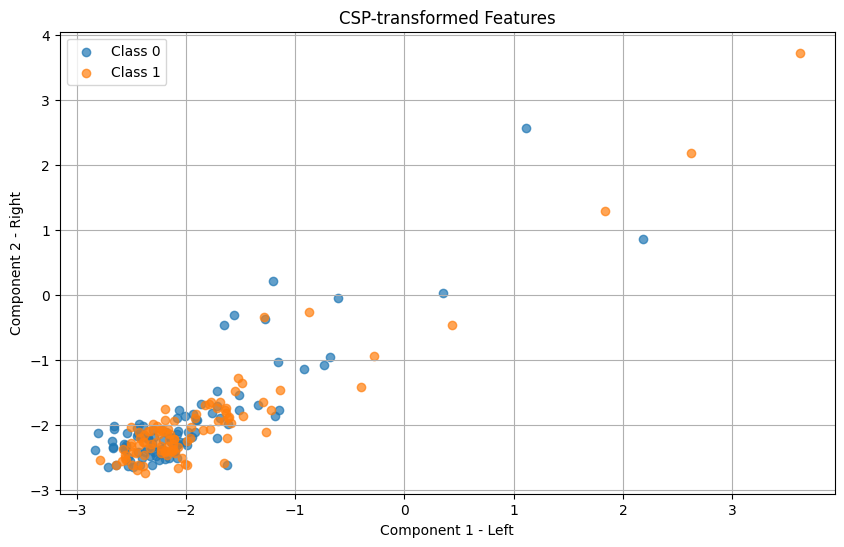

In [16]:
import matplotlib.pyplot as plt

# CSP 적용 후 변환된 데이터 (X_csp)와 레이블 (y)
# X_csp는 n_trials x n_components 크기의 배열이며, y는 각 trial의 클래스 레이블입니다.

# 첫 번째와 두 번째 주성분을 추출하여 시각화
plt.figure(figsize=(10, 6))
for label in np.unique(y):  # 각 클래스에 대해 다른 색으로 표시
    plt.scatter(
        X_csp[y == label, 0],  # 첫 번째 주성분
        X_csp[y == label, 1],  # 두 번째 주성분
        label=f'Class {label}',
        alpha=0.7
    )

plt.title("CSP-transformed Features")
plt.xlabel("Component 1 - Left")
plt.ylabel("Component 2 - Right")
plt.legend()
plt.grid(True)
plt.show()

In [25]:
X_csp.shape

(200, 2)

### **3.5.3 Wavelet Transform를 사용한 Classification**

여기서는 CSP를 Wavelet Transform으로 사용함.  
모델은 FLDA, SVM, SGD, MLP를 사용함.  
3.5.1에서 labels_per_subject를 해야 함. = y를 설정하기 위해서.

In [29]:
%pip install pywavelets scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [19]:
import numpy as np
import pywt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [20]:
# 데이터 준비
# X: EEG 데이터, shape = (n_trials, n_channels, n_times)
# y: Labels, shape = (n_trials,)

# Step 1: Wavelet 변환을 통해 특징 추출
def extract_wavelet_features(data):
    features = []
    for trial in data:
        trial_features = []
        for channel_data in trial:
            # 각 채널에 대해 Wavelet 변환 적용
            coeffs = pywt.wavedec(channel_data, 'db4', level=3)
            # 각 레벨의 세부 계수를 특징으로 사용
            channel_features = np.hstack([np.mean(abs(c)) for c in coeffs])
            trial_features.extend(channel_features)
        features.append(trial_features)
    return np.array(features)

#### **FLDA Model**

Processing subject: s01


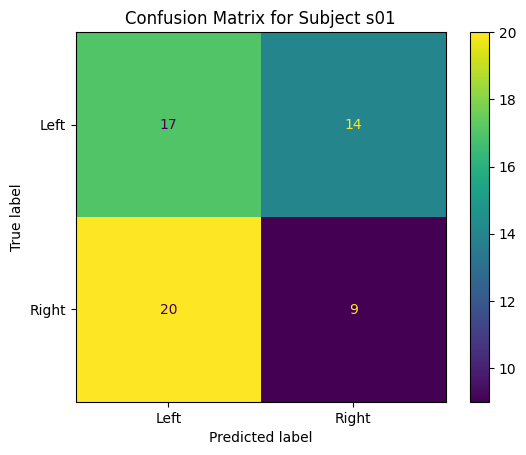

Classification accuracy: 43.33%
(200, 256)
Weighted F1-score: 0.43

Classification Report:
               precision    recall  f1-score   support

        Left       0.46      0.55      0.50        31
       Right       0.39      0.31      0.35        29

    accuracy                           0.43        60
   macro avg       0.43      0.43      0.42        60
weighted avg       0.43      0.43      0.43        60

Processing subject: s03


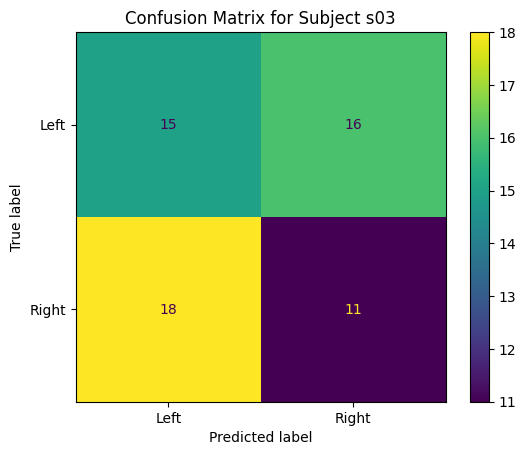

Classification accuracy: 43.33%
(200, 256)
Weighted F1-score: 0.43

Classification Report:
               precision    recall  f1-score   support

        Left       0.45      0.48      0.47        31
       Right       0.41      0.38      0.39        29

    accuracy                           0.43        60
   macro avg       0.43      0.43      0.43        60
weighted avg       0.43      0.43      0.43        60

Processing subject: s04


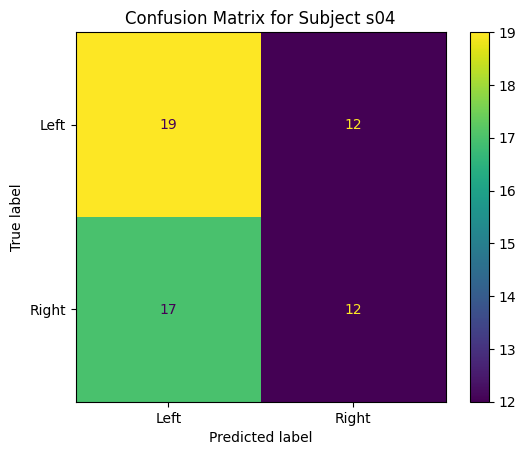

Classification accuracy: 51.67%
(200, 256)
Weighted F1-score: 0.51

Classification Report:
               precision    recall  f1-score   support

        Left       0.53      0.61      0.57        31
       Right       0.50      0.41      0.45        29

    accuracy                           0.52        60
   macro avg       0.51      0.51      0.51        60
weighted avg       0.51      0.52      0.51        60

Processing subject: s05


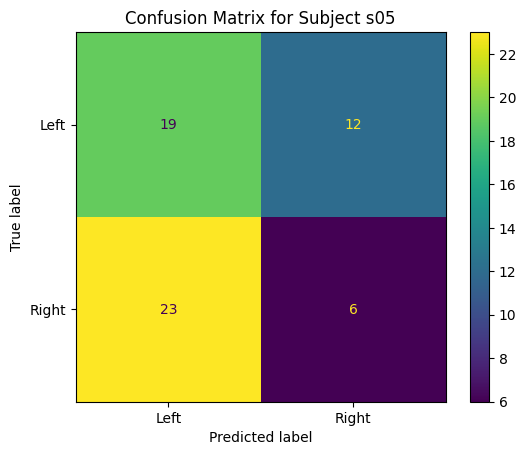

Classification accuracy: 41.67%
(200, 256)
Weighted F1-score: 0.39

Classification Report:
               precision    recall  f1-score   support

        Left       0.45      0.61      0.52        31
       Right       0.33      0.21      0.26        29

    accuracy                           0.42        60
   macro avg       0.39      0.41      0.39        60
weighted avg       0.39      0.42      0.39        60

Processing subject: s06


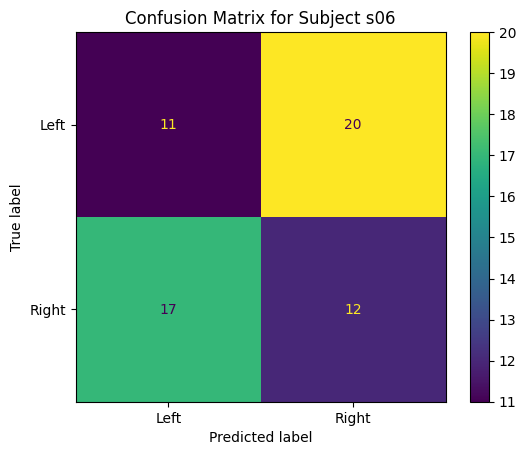

Classification accuracy: 38.33%
(200, 256)
Weighted F1-score: 0.38

Classification Report:
               precision    recall  f1-score   support

        Left       0.39      0.35      0.37        31
       Right       0.38      0.41      0.39        29

    accuracy                           0.38        60
   macro avg       0.38      0.38      0.38        60
weighted avg       0.38      0.38      0.38        60

Processing subject: s09


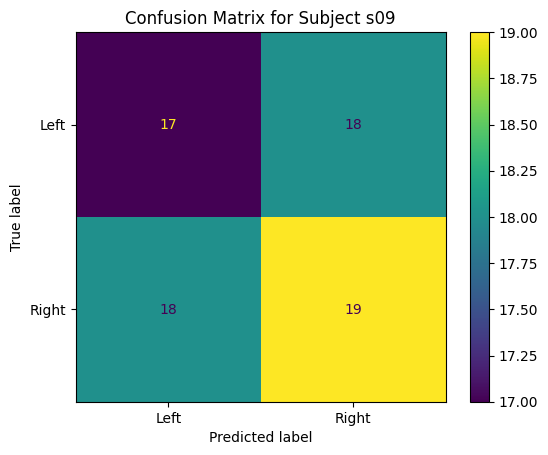

Classification accuracy: 50.00%
(240, 256)
Weighted F1-score: 0.50

Classification Report:
               precision    recall  f1-score   support

        Left       0.49      0.49      0.49        35
       Right       0.51      0.51      0.51        37

    accuracy                           0.50        72
   macro avg       0.50      0.50      0.50        72
weighted avg       0.50      0.50      0.50        72

Processing subject: s10


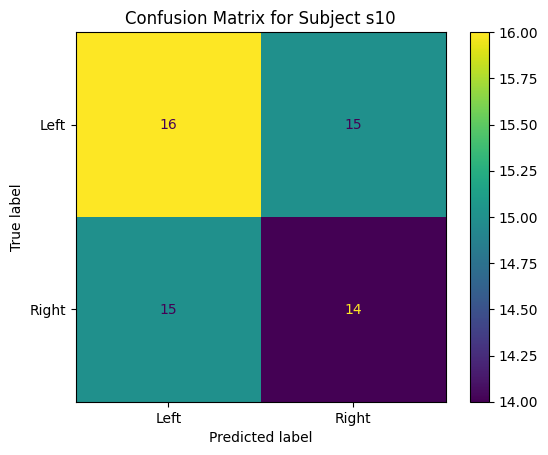

Classification accuracy: 50.00%
(200, 256)
Weighted F1-score: 0.50

Classification Report:
               precision    recall  f1-score   support

        Left       0.52      0.52      0.52        31
       Right       0.48      0.48      0.48        29

    accuracy                           0.50        60
   macro avg       0.50      0.50      0.50        60
weighted avg       0.50      0.50      0.50        60

Processing subject: s13


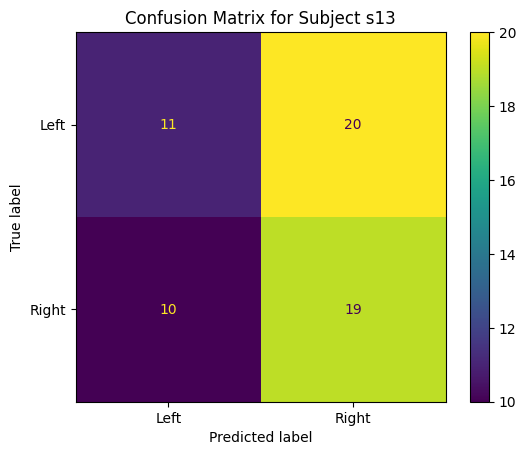

Classification accuracy: 50.00%
(200, 256)
Weighted F1-score: 0.49

Classification Report:
               precision    recall  f1-score   support

        Left       0.52      0.35      0.42        31
       Right       0.49      0.66      0.56        29

    accuracy                           0.50        60
   macro avg       0.51      0.51      0.49        60
weighted avg       0.51      0.50      0.49        60

Processing subject: s14


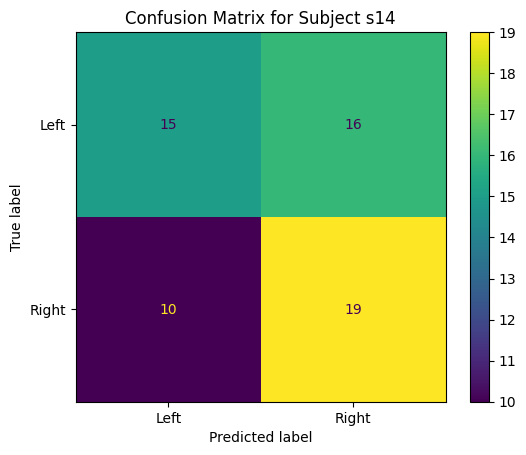

Classification accuracy: 56.67%
(200, 256)
Weighted F1-score: 0.56

Classification Report:
               precision    recall  f1-score   support

        Left       0.60      0.48      0.54        31
       Right       0.54      0.66      0.59        29

    accuracy                           0.57        60
   macro avg       0.57      0.57      0.56        60
weighted avg       0.57      0.57      0.56        60

Processing subject: s33


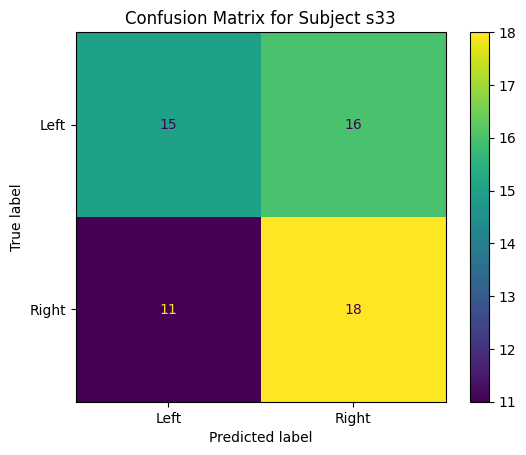

Classification accuracy: 55.00%
(200, 256)
Weighted F1-score: 0.55

Classification Report:
               precision    recall  f1-score   support

        Left       0.58      0.48      0.53        31
       Right       0.53      0.62      0.57        29

    accuracy                           0.55        60
   macro avg       0.55      0.55      0.55        60
weighted avg       0.55      0.55      0.55        60

Processing subject: s35


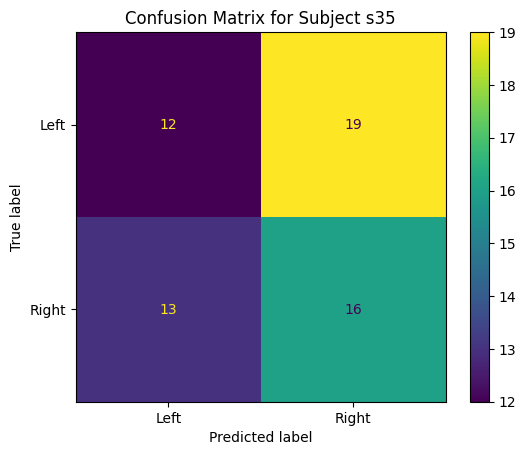

Classification accuracy: 46.67%
(200, 256)
Weighted F1-score: 0.46

Classification Report:
               precision    recall  f1-score   support

        Left       0.48      0.39      0.43        31
       Right       0.46      0.55      0.50        29

    accuracy                           0.47        60
   macro avg       0.47      0.47      0.46        60
weighted avg       0.47      0.47      0.46        60

Processing subject: s41


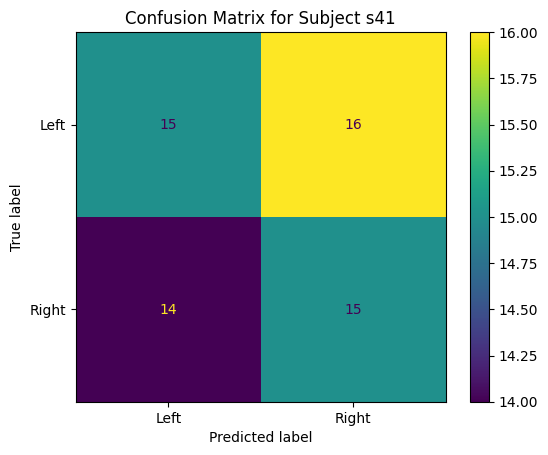

Classification accuracy: 50.00%
(200, 256)
Weighted F1-score: 0.50

Classification Report:
               precision    recall  f1-score   support

        Left       0.52      0.48      0.50        31
       Right       0.48      0.52      0.50        29

    accuracy                           0.50        60
   macro avg       0.50      0.50      0.50        60
weighted avg       0.50      0.50      0.50        60

Processing subject: s43


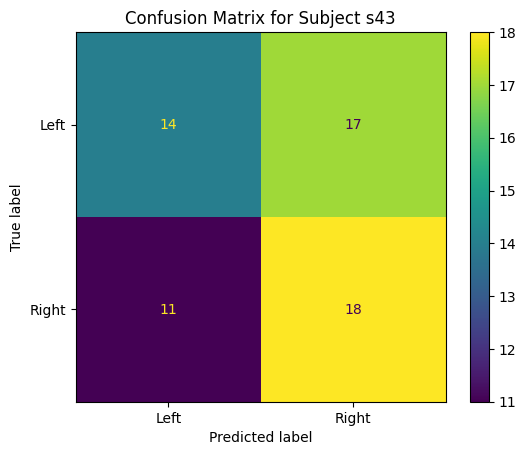

Classification accuracy: 53.33%
(200, 256)
Weighted F1-score: 0.53

Classification Report:
               precision    recall  f1-score   support

        Left       0.56      0.45      0.50        31
       Right       0.51      0.62      0.56        29

    accuracy                           0.53        60
   macro avg       0.54      0.54      0.53        60
weighted avg       0.54      0.53      0.53        60

Processing subject: s44


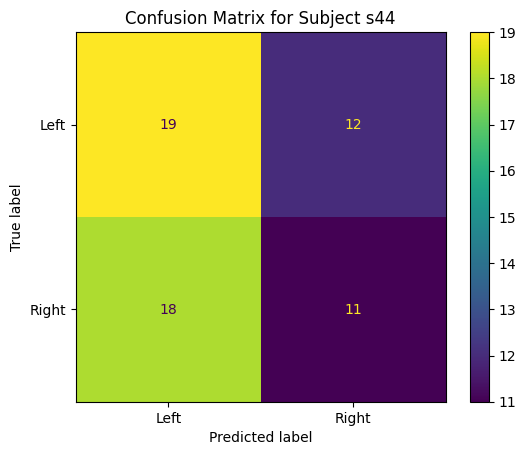

Classification accuracy: 50.00%
(200, 256)
Weighted F1-score: 0.49

Classification Report:
               precision    recall  f1-score   support

        Left       0.51      0.61      0.56        31
       Right       0.48      0.38      0.42        29

    accuracy                           0.50        60
   macro avg       0.50      0.50      0.49        60
weighted avg       0.50      0.50      0.49        60

Processing subject: s46


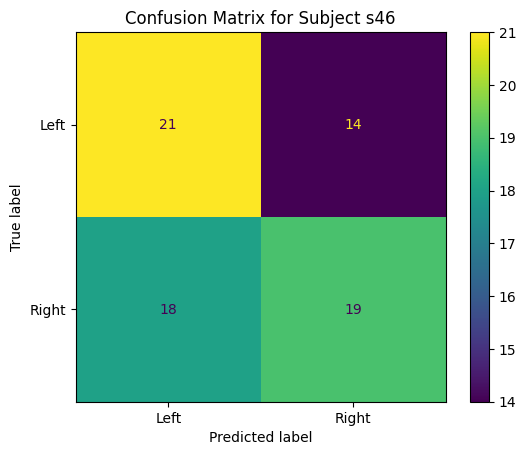

Classification accuracy: 55.56%
(240, 256)
Weighted F1-score: 0.55

Classification Report:
               precision    recall  f1-score   support

        Left       0.54      0.60      0.57        35
       Right       0.58      0.51      0.54        37

    accuracy                           0.56        72
   macro avg       0.56      0.56      0.56        72
weighted avg       0.56      0.56      0.55        72

Processing subject: s48


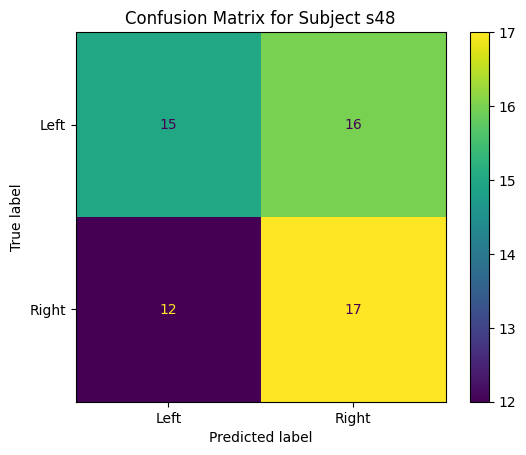

Classification accuracy: 53.33%
(200, 256)
Weighted F1-score: 0.53

Classification Report:
               precision    recall  f1-score   support

        Left       0.56      0.48      0.52        31
       Right       0.52      0.59      0.55        29

    accuracy                           0.53        60
   macro avg       0.54      0.54      0.53        60
weighted avg       0.54      0.53      0.53        60

Processing subject: s49


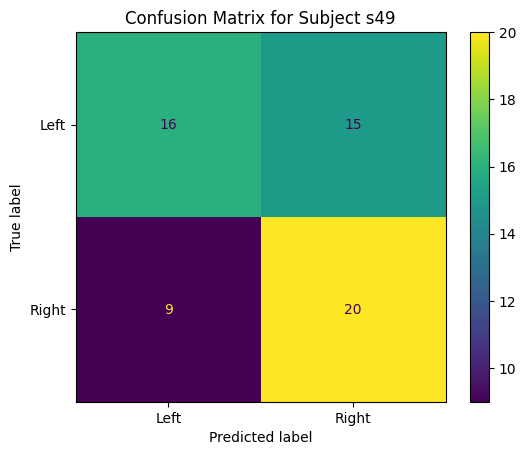

Classification accuracy: 60.00%
(200, 256)
Weighted F1-score: 0.60

Classification Report:
               precision    recall  f1-score   support

        Left       0.64      0.52      0.57        31
       Right       0.57      0.69      0.62        29

    accuracy                           0.60        60
   macro avg       0.61      0.60      0.60        60
weighted avg       0.61      0.60      0.60        60

Processing subject: s50


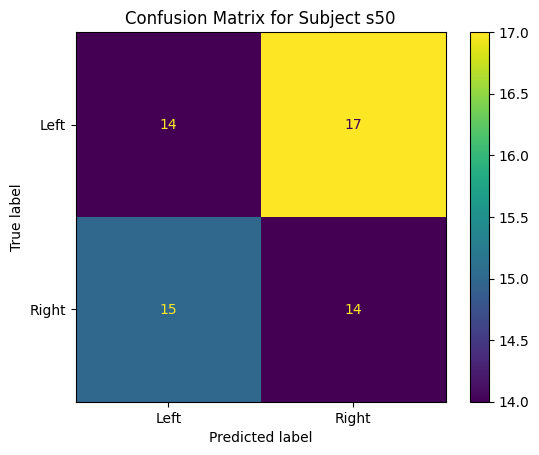

Classification accuracy: 46.67%
(200, 256)
Weighted F1-score: 0.47

Classification Report:
               precision    recall  f1-score   support

        Left       0.48      0.45      0.47        31
       Right       0.45      0.48      0.47        29

    accuracy                           0.47        60
   macro avg       0.47      0.47      0.47        60
weighted avg       0.47      0.47      0.47        60

Processing subject: s52


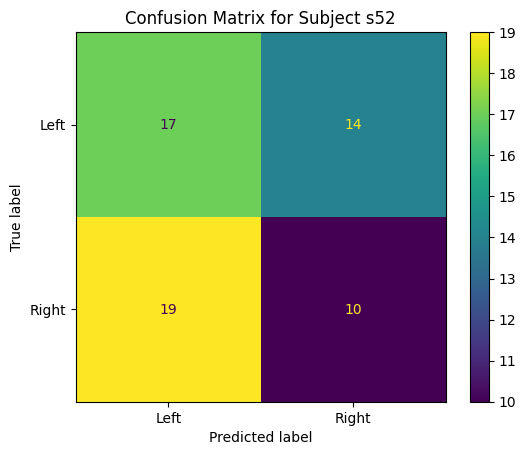

Classification accuracy: 45.00%
(200, 256)
Weighted F1-score: 0.44

Classification Report:
               precision    recall  f1-score   support

        Left       0.47      0.55      0.51        31
       Right       0.42      0.34      0.38        29

    accuracy                           0.45        60
   macro avg       0.44      0.45      0.44        60
weighted avg       0.45      0.45      0.44        60



In [21]:
# Dictionary to store classification accuracy for each subject
classification_results = {}

# Iterate over each subject's EEG data and perform classification
for subject, eeg_data_list in filtered_data_after_bad_trial_removal.items():
    print(f"Processing subject: {subject}")

    # Convert each trial's RawArray to numpy and check consistency
    processed_data = []
    for trial_data in eeg_data_list:
        # Convert RawArray to numpy
        trial_numpy = trial_data.get_data()
        
        # Ensure all trials have the same shape
        if processed_data and trial_numpy.shape != processed_data[0].shape:
            # Adjust shape by truncating or padding
            min_shape = (processed_data[0].shape[0], min(processed_data[0].shape[1], trial_numpy.shape[1]))
            adjusted_trial = np.zeros(processed_data[0].shape)
            adjusted_trial[:, :min_shape[1]] = trial_numpy[:, :min_shape[1]]
            processed_data.append(adjusted_trial)
        else:
            processed_data.append(trial_numpy)

    # Convert processed data to a consistent 3D array
    X = np.stack(processed_data)  # Shape should be (n_trials, n_channels, n_times)
    y = labels_per_subject[subject]  # Corresponding labels for this subject

    # Check shape consistency
    if X.shape[0] != len(y):
        print(f"Mismatch in trial counts for subject {subject}. X shape: {X.shape}, y length: {len(y)}")
        continue

    # 특징 추출
    X_features = extract_wavelet_features(X)

    # Step 2: Perform 7:3 train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.3, random_state=42)

    # Step 3: FLDA 모델 학습
    clf = LinearDiscriminantAnalysis()
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Step 4: Compute and display the confusion matrix for the subject
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Left', 'Right'])
    disp.plot()
    plt.title(f"Confusion Matrix for Subject {subject}")
    plt.show()

    # Step 5: Calculate and store classification accuracy for this subject
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Classification accuracy: {accuracy * 100:.2f}%")
    print(X_features.shape)
    
    # F1-score 계산 및 출력
    f1 = f1_score(y_test, y_pred, average='weighted')  # 'weighted'는 클래스 불균형이 있을 때 사용, 'macro'는 각 클래스에 동일한 가중치 부여
    print(f"Weighted F1-score: {f1:.2f}")
    
    # 클래스별 Precision, Recall, F1-score 및 Accuracy 등 출력
    report = classification_report(y_test, y_pred, target_names=['Left', 'Right'])
    print("\nClassification Report:\n", report)


In [20]:
# 행이 200개, 열이 64개.
X.shape

(200, 64, 1025)

In [ ]:
X

In [ ]:
X_features

In [ ]:
# X_features의 70% 해당.
X_train

In [ ]:
# X_features의 30% 해당.
X_test

#### **Support Vector Machine**

Processing subject: s01


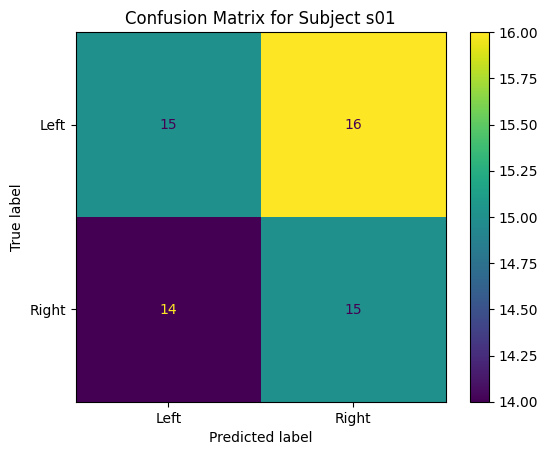

Classification accuracy: 50.00%
Weighted F1-score: 0.50

Classification Report:
               precision    recall  f1-score   support

        Left       0.52      0.48      0.50        31
       Right       0.48      0.52      0.50        29

    accuracy                           0.50        60
   macro avg       0.50      0.50      0.50        60
weighted avg       0.50      0.50      0.50        60

Processing subject: s03


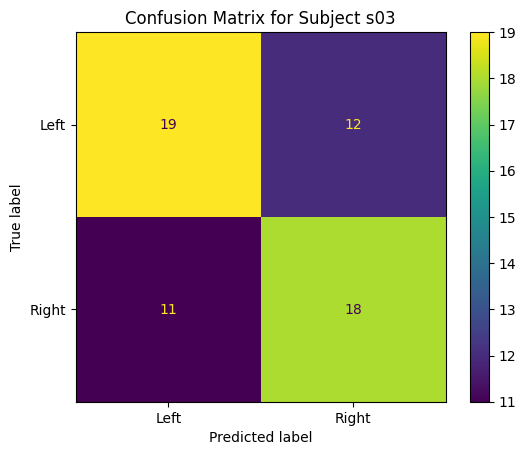

Classification accuracy: 61.67%
Weighted F1-score: 0.62

Classification Report:
               precision    recall  f1-score   support

        Left       0.63      0.61      0.62        31
       Right       0.60      0.62      0.61        29

    accuracy                           0.62        60
   macro avg       0.62      0.62      0.62        60
weighted avg       0.62      0.62      0.62        60

Processing subject: s04


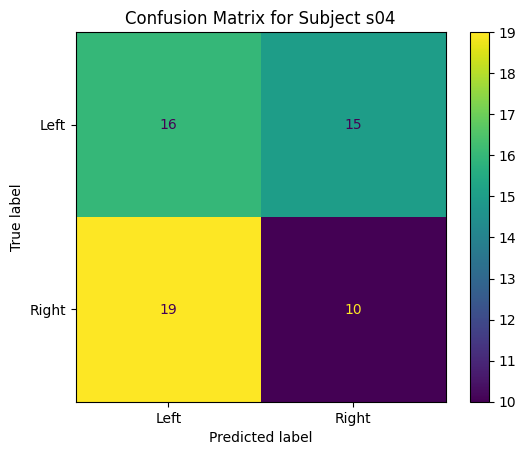

Classification accuracy: 43.33%
Weighted F1-score: 0.43

Classification Report:
               precision    recall  f1-score   support

        Left       0.46      0.52      0.48        31
       Right       0.40      0.34      0.37        29

    accuracy                           0.43        60
   macro avg       0.43      0.43      0.43        60
weighted avg       0.43      0.43      0.43        60

Processing subject: s05


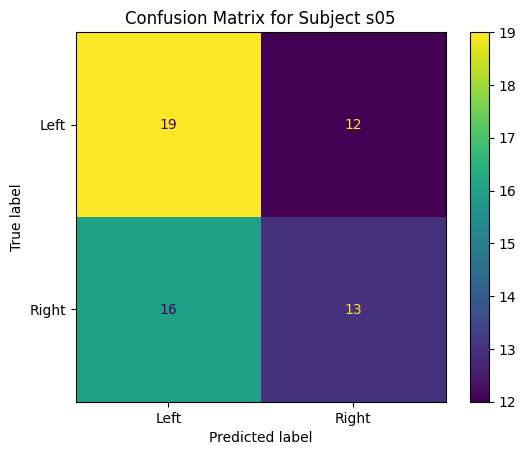

Classification accuracy: 53.33%
Weighted F1-score: 0.53

Classification Report:
               precision    recall  f1-score   support

        Left       0.54      0.61      0.58        31
       Right       0.52      0.45      0.48        29

    accuracy                           0.53        60
   macro avg       0.53      0.53      0.53        60
weighted avg       0.53      0.53      0.53        60

Processing subject: s06


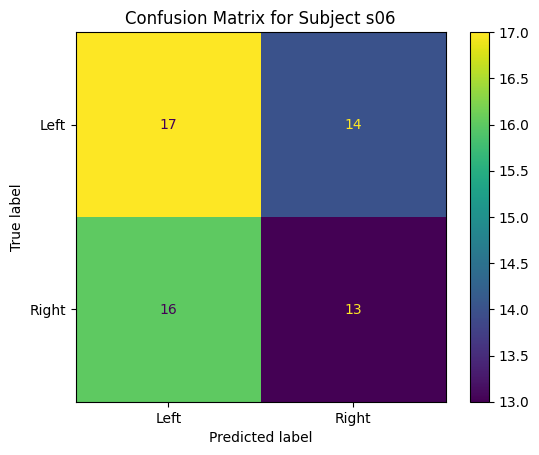

Classification accuracy: 50.00%
Weighted F1-score: 0.50

Classification Report:
               precision    recall  f1-score   support

        Left       0.52      0.55      0.53        31
       Right       0.48      0.45      0.46        29

    accuracy                           0.50        60
   macro avg       0.50      0.50      0.50        60
weighted avg       0.50      0.50      0.50        60

Processing subject: s09


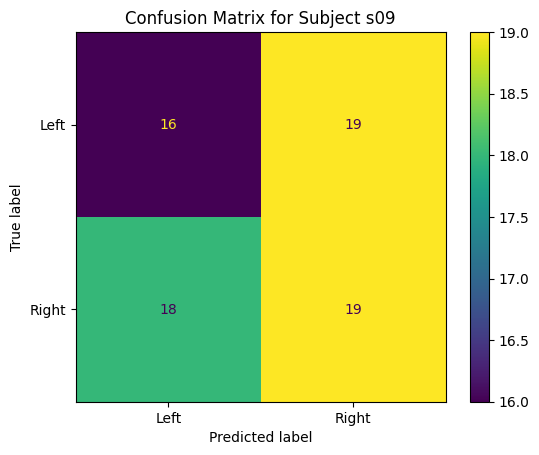

Classification accuracy: 48.61%
Weighted F1-score: 0.49

Classification Report:
               precision    recall  f1-score   support

        Left       0.47      0.46      0.46        35
       Right       0.50      0.51      0.51        37

    accuracy                           0.49        72
   macro avg       0.49      0.49      0.49        72
weighted avg       0.49      0.49      0.49        72

Processing subject: s10


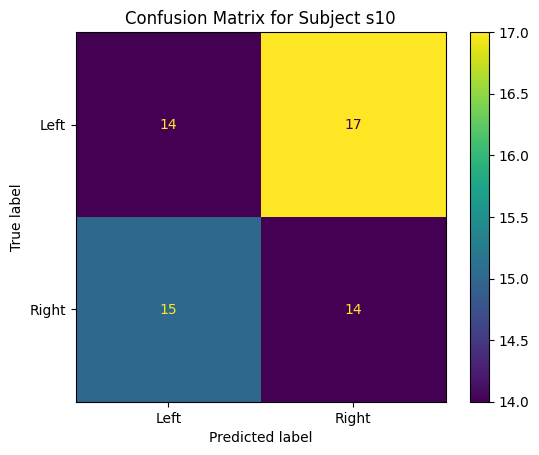

Classification accuracy: 46.67%
Weighted F1-score: 0.47

Classification Report:
               precision    recall  f1-score   support

        Left       0.48      0.45      0.47        31
       Right       0.45      0.48      0.47        29

    accuracy                           0.47        60
   macro avg       0.47      0.47      0.47        60
weighted avg       0.47      0.47      0.47        60

Processing subject: s13


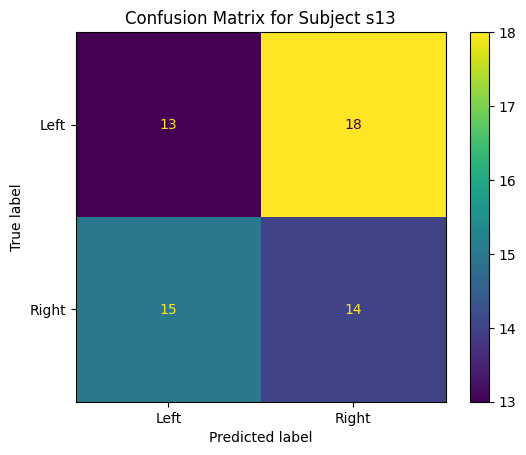

Classification accuracy: 45.00%
Weighted F1-score: 0.45

Classification Report:
               precision    recall  f1-score   support

        Left       0.46      0.42      0.44        31
       Right       0.44      0.48      0.46        29

    accuracy                           0.45        60
   macro avg       0.45      0.45      0.45        60
weighted avg       0.45      0.45      0.45        60

Processing subject: s14


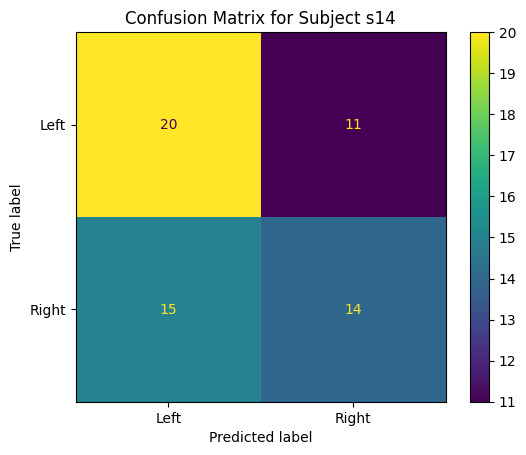

Classification accuracy: 56.67%
Weighted F1-score: 0.56

Classification Report:
               precision    recall  f1-score   support

        Left       0.57      0.65      0.61        31
       Right       0.56      0.48      0.52        29

    accuracy                           0.57        60
   macro avg       0.57      0.56      0.56        60
weighted avg       0.57      0.57      0.56        60

Processing subject: s33


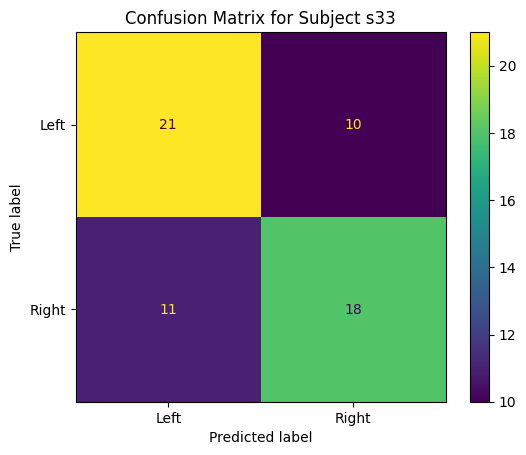

Classification accuracy: 65.00%
Weighted F1-score: 0.65

Classification Report:
               precision    recall  f1-score   support

        Left       0.66      0.68      0.67        31
       Right       0.64      0.62      0.63        29

    accuracy                           0.65        60
   macro avg       0.65      0.65      0.65        60
weighted avg       0.65      0.65      0.65        60

Processing subject: s35


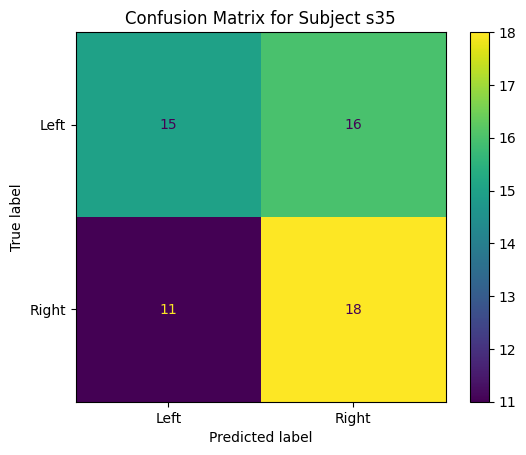

Classification accuracy: 55.00%
Weighted F1-score: 0.55

Classification Report:
               precision    recall  f1-score   support

        Left       0.58      0.48      0.53        31
       Right       0.53      0.62      0.57        29

    accuracy                           0.55        60
   macro avg       0.55      0.55      0.55        60
weighted avg       0.55      0.55      0.55        60

Processing subject: s41


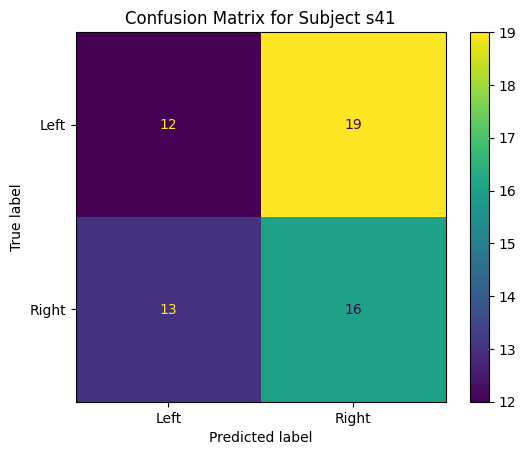

Classification accuracy: 46.67%
Weighted F1-score: 0.46

Classification Report:
               precision    recall  f1-score   support

        Left       0.48      0.39      0.43        31
       Right       0.46      0.55      0.50        29

    accuracy                           0.47        60
   macro avg       0.47      0.47      0.46        60
weighted avg       0.47      0.47      0.46        60

Processing subject: s43


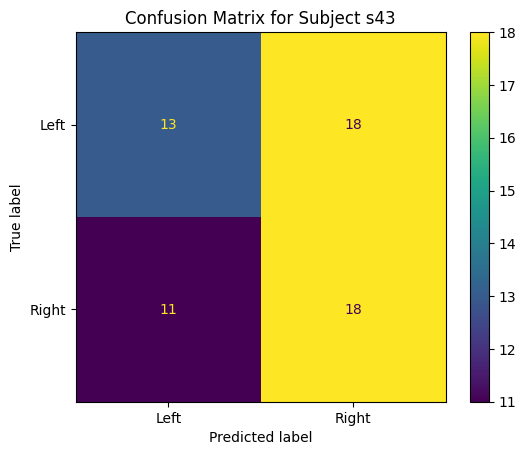

Classification accuracy: 51.67%
Weighted F1-score: 0.51

Classification Report:
               precision    recall  f1-score   support

        Left       0.54      0.42      0.47        31
       Right       0.50      0.62      0.55        29

    accuracy                           0.52        60
   macro avg       0.52      0.52      0.51        60
weighted avg       0.52      0.52      0.51        60

Processing subject: s44


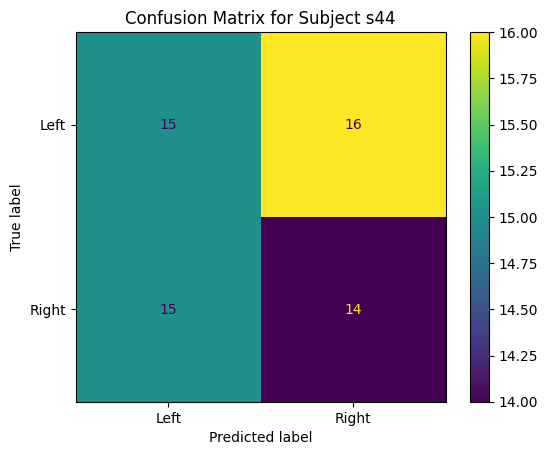

Classification accuracy: 48.33%
Weighted F1-score: 0.48

Classification Report:
               precision    recall  f1-score   support

        Left       0.50      0.48      0.49        31
       Right       0.47      0.48      0.47        29

    accuracy                           0.48        60
   macro avg       0.48      0.48      0.48        60
weighted avg       0.48      0.48      0.48        60

Processing subject: s46


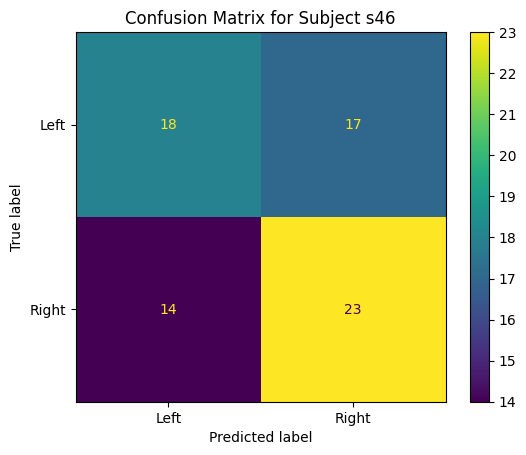

Classification accuracy: 56.94%
Weighted F1-score: 0.57

Classification Report:
               precision    recall  f1-score   support

        Left       0.56      0.51      0.54        35
       Right       0.57      0.62      0.60        37

    accuracy                           0.57        72
   macro avg       0.57      0.57      0.57        72
weighted avg       0.57      0.57      0.57        72

Processing subject: s48


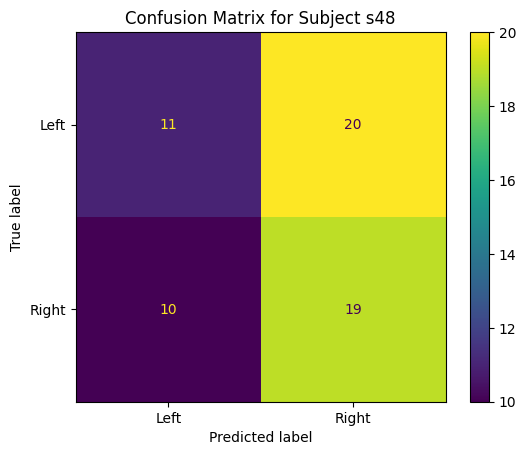

Classification accuracy: 50.00%
Weighted F1-score: 0.49

Classification Report:
               precision    recall  f1-score   support

        Left       0.52      0.35      0.42        31
       Right       0.49      0.66      0.56        29

    accuracy                           0.50        60
   macro avg       0.51      0.51      0.49        60
weighted avg       0.51      0.50      0.49        60

Processing subject: s49


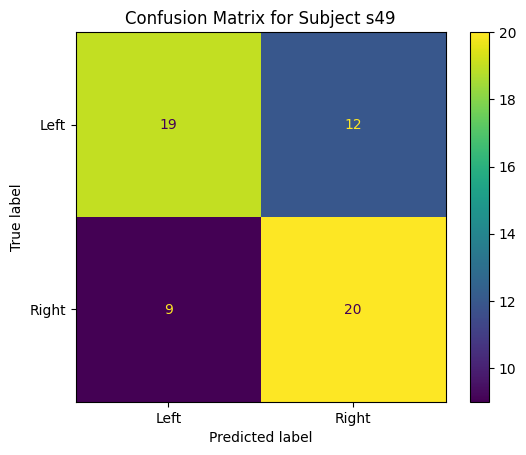

Classification accuracy: 65.00%
Weighted F1-score: 0.65

Classification Report:
               precision    recall  f1-score   support

        Left       0.68      0.61      0.64        31
       Right       0.62      0.69      0.66        29

    accuracy                           0.65        60
   macro avg       0.65      0.65      0.65        60
weighted avg       0.65      0.65      0.65        60

Processing subject: s50


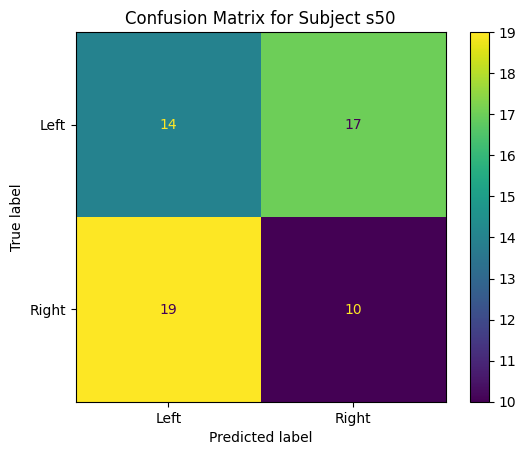

Classification accuracy: 40.00%
Weighted F1-score: 0.40

Classification Report:
               precision    recall  f1-score   support

        Left       0.42      0.45      0.44        31
       Right       0.37      0.34      0.36        29

    accuracy                           0.40        60
   macro avg       0.40      0.40      0.40        60
weighted avg       0.40      0.40      0.40        60

Processing subject: s52


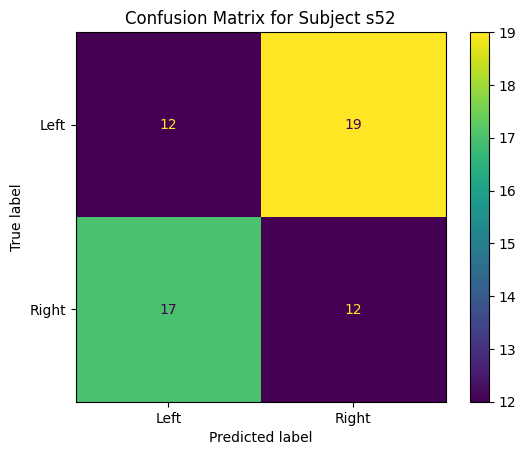

Classification accuracy: 40.00%
Weighted F1-score: 0.40

Classification Report:
               precision    recall  f1-score   support

        Left       0.41      0.39      0.40        31
       Right       0.39      0.41      0.40        29

    accuracy                           0.40        60
   macro avg       0.40      0.40      0.40        60
weighted avg       0.40      0.40      0.40        60



In [24]:
# Dictionary to store classification accuracy for each subject
classification_results = {}

# Iterate over each subject's EEG data and perform classification
for subject, eeg_data_list in filtered_data_after_bad_trial_removal.items():
    print(f"Processing subject: {subject}")

    # Convert each trial's RawArray to numpy and check consistency
    processed_data = []
    for trial_data in eeg_data_list:
        # Convert RawArray to numpy
        trial_numpy = trial_data.get_data()
        
        # Ensure all trials have the same shape
        if processed_data and trial_numpy.shape != processed_data[0].shape:
            # Adjust shape by truncating or padding
            min_shape = (processed_data[0].shape[0], min(processed_data[0].shape[1], trial_numpy.shape[1]))
            adjusted_trial = np.zeros(processed_data[0].shape)
            adjusted_trial[:, :min_shape[1]] = trial_numpy[:, :min_shape[1]]
            processed_data.append(adjusted_trial)
        else:
            processed_data.append(trial_numpy)

    # Convert processed data to a consistent 3D array
    X = np.stack(processed_data)  # Shape should be (n_trials, n_channels, n_times)
    y = labels_per_subject[subject]  # Corresponding labels for this subject

    # Check shape consistency
    if X.shape[0] != len(y):
        print(f"Mismatch in trial counts for subject {subject}. X shape: {X.shape}, y length: {len(y)}")
        continue

    # 특징 추출
    X_features = extract_wavelet_features(X)

    # Step 2: Perform 7:3 train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.3, random_state=42)

    # Step 3: Support Vector Machine(SVM)을 적용
    model = SVC(kernel='linear')  # 또는 'rbf', 'poly' 등으로 커널 변경 가능
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Step 4: Compute and display the confusion matrix for the subject
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Left', 'Right'])
    disp.plot()
    plt.title(f"Confusion Matrix for Subject {subject}")
    plt.show()

    # Step 5: Calculate and store classification accuracy for this subject
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Classification accuracy: {accuracy * 100:.2f}%")
    
    # F1-score 계산 및 출력
    f1 = f1_score(y_test, y_pred, average='weighted')  # 'weighted'는 클래스 불균형이 있을 때 사용, 'macro'는 각 클래스에 동일한 가중치 부여
    print(f"Weighted F1-score: {f1:.2f}")
    
    # 클래스별 Precision, Recall, F1-score 및 Accuracy 등 출력
    report = classification_report(y_test, y_pred, target_names=['Left', 'Right'])
    print("\nClassification Report:\n", report)


#### **Stochastic Gradient Descent**

In [25]:
from sklearn.linear_model import SGDClassifier

Processing subject: s01


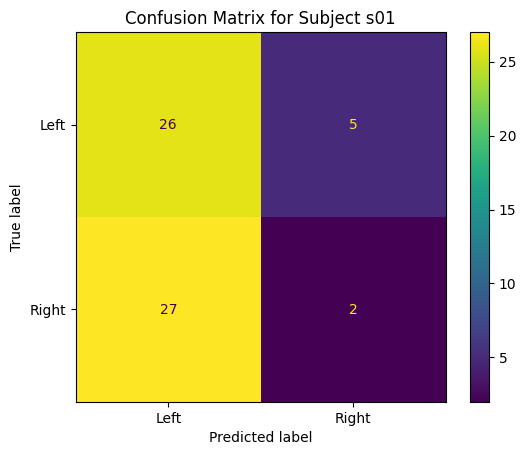

Classification accuracy: 46.67%
Weighted F1-score: 0.37

Classification Report:
               precision    recall  f1-score   support

        Left       0.49      0.84      0.62        31
       Right       0.29      0.07      0.11        29

    accuracy                           0.47        60
   macro avg       0.39      0.45      0.37        60
weighted avg       0.39      0.47      0.37        60

Processing subject: s03


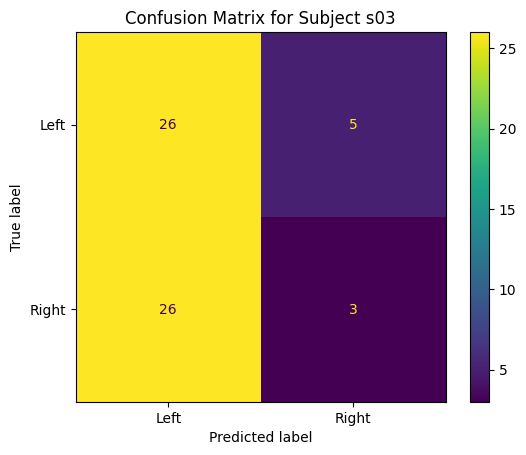

Classification accuracy: 48.33%
Weighted F1-score: 0.40

Classification Report:
               precision    recall  f1-score   support

        Left       0.50      0.84      0.63        31
       Right       0.38      0.10      0.16        29

    accuracy                           0.48        60
   macro avg       0.44      0.47      0.39        60
weighted avg       0.44      0.48      0.40        60

Processing subject: s04


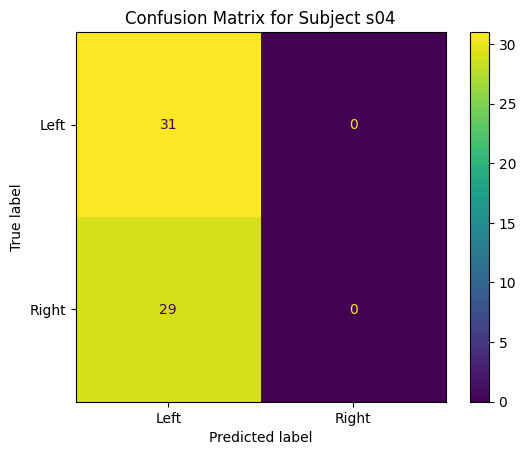

Classification accuracy: 51.67%
Weighted F1-score: 0.35

Classification Report:
               precision    recall  f1-score   support

        Left       0.52      1.00      0.68        31
       Right       0.00      0.00      0.00        29

    accuracy                           0.52        60
   macro avg       0.26      0.50      0.34        60
weighted avg       0.27      0.52      0.35        60

Processing subject: s05


c:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


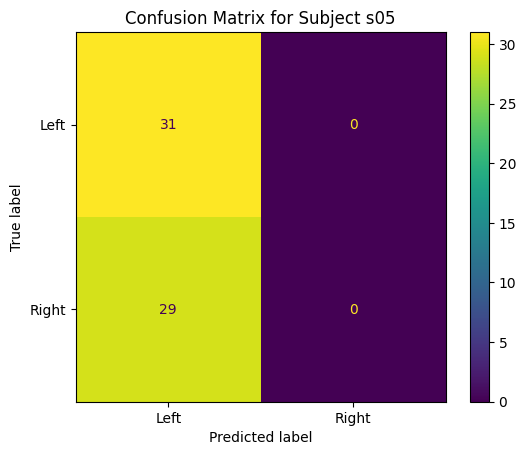

Classification accuracy: 51.67%
Weighted F1-score: 0.35

Classification Report:
               precision    recall  f1-score   support

        Left       0.52      1.00      0.68        31
       Right       0.00      0.00      0.00        29

    accuracy                           0.52        60
   macro avg       0.26      0.50      0.34        60
weighted avg       0.27      0.52      0.35        60

Processing subject: s06


c:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


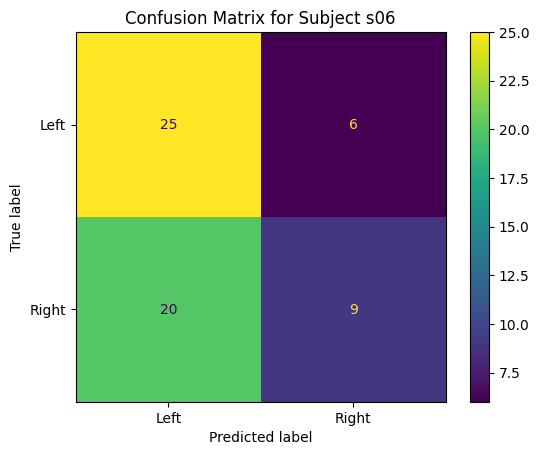

Classification accuracy: 56.67%
Weighted F1-score: 0.54

Classification Report:
               precision    recall  f1-score   support

        Left       0.56      0.81      0.66        31
       Right       0.60      0.31      0.41        29

    accuracy                           0.57        60
   macro avg       0.58      0.56      0.53        60
weighted avg       0.58      0.57      0.54        60

Processing subject: s09


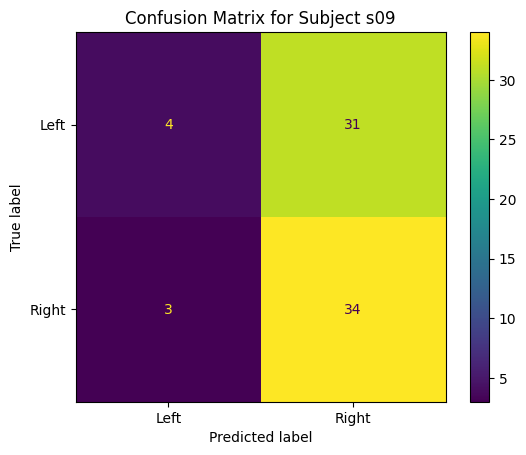

Classification accuracy: 52.78%
Weighted F1-score: 0.44

Classification Report:
               precision    recall  f1-score   support

        Left       0.57      0.11      0.19        35
       Right       0.52      0.92      0.67        37

    accuracy                           0.53        72
   macro avg       0.55      0.52      0.43        72
weighted avg       0.55      0.53      0.44        72

Processing subject: s10


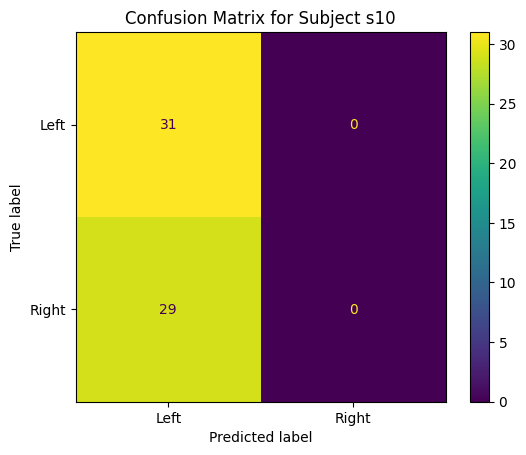

Classification accuracy: 51.67%
Weighted F1-score: 0.35

Classification Report:
               precision    recall  f1-score   support

        Left       0.52      1.00      0.68        31
       Right       0.00      0.00      0.00        29

    accuracy                           0.52        60
   macro avg       0.26      0.50      0.34        60
weighted avg       0.27      0.52      0.35        60

Processing subject: s13


c:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


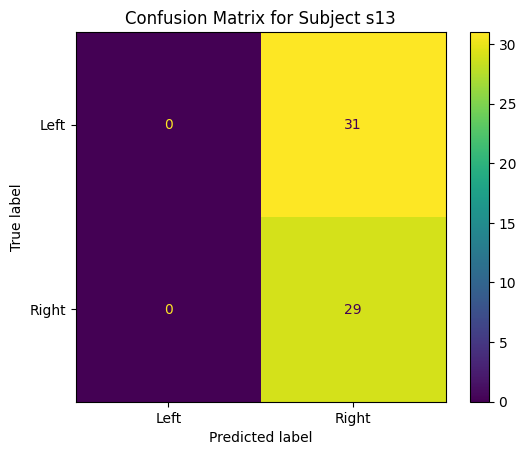

Classification accuracy: 48.33%
Weighted F1-score: 0.31

Classification Report:
               precision    recall  f1-score   support

        Left       0.00      0.00      0.00        31
       Right       0.48      1.00      0.65        29

    accuracy                           0.48        60
   macro avg       0.24      0.50      0.33        60
weighted avg       0.23      0.48      0.31        60

Processing subject: s14


c:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


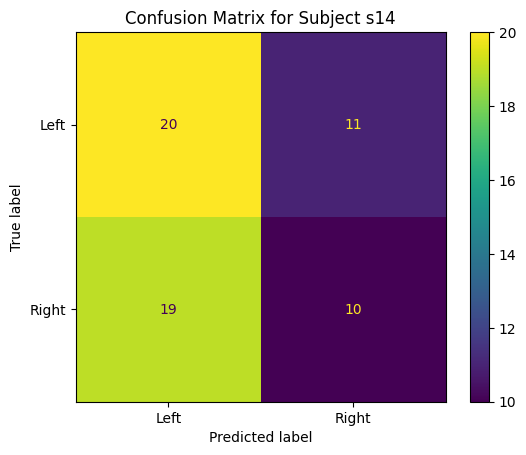

Classification accuracy: 50.00%
Weighted F1-score: 0.49

Classification Report:
               precision    recall  f1-score   support

        Left       0.51      0.65      0.57        31
       Right       0.48      0.34      0.40        29

    accuracy                           0.50        60
   macro avg       0.49      0.49      0.49        60
weighted avg       0.50      0.50      0.49        60

Processing subject: s33


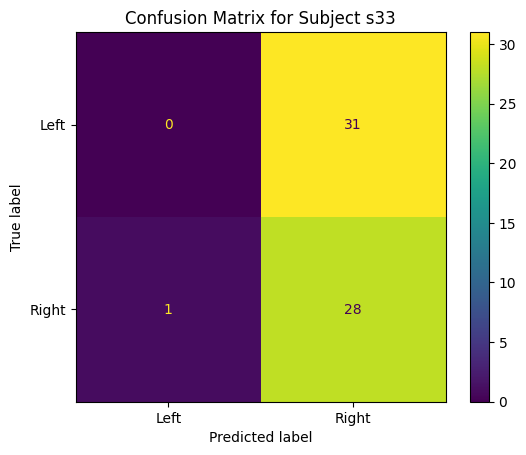

Classification accuracy: 46.67%
Weighted F1-score: 0.31

Classification Report:
               precision    recall  f1-score   support

        Left       0.00      0.00      0.00        31
       Right       0.47      0.97      0.64        29

    accuracy                           0.47        60
   macro avg       0.24      0.48      0.32        60
weighted avg       0.23      0.47      0.31        60

Processing subject: s35


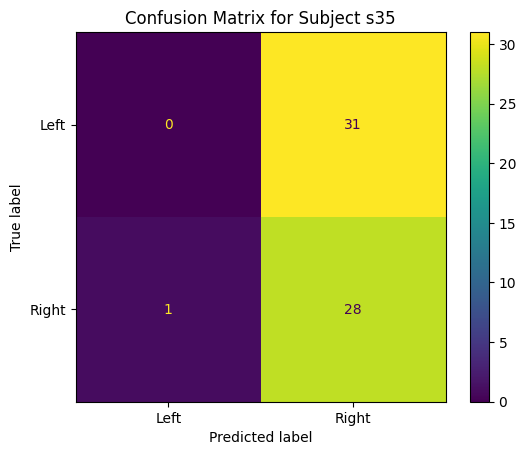

Classification accuracy: 46.67%
Weighted F1-score: 0.31

Classification Report:
               precision    recall  f1-score   support

        Left       0.00      0.00      0.00        31
       Right       0.47      0.97      0.64        29

    accuracy                           0.47        60
   macro avg       0.24      0.48      0.32        60
weighted avg       0.23      0.47      0.31        60

Processing subject: s41


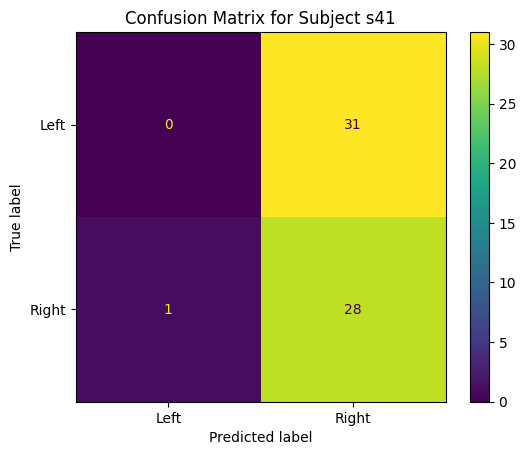

Classification accuracy: 46.67%
Weighted F1-score: 0.31

Classification Report:
               precision    recall  f1-score   support

        Left       0.00      0.00      0.00        31
       Right       0.47      0.97      0.64        29

    accuracy                           0.47        60
   macro avg       0.24      0.48      0.32        60
weighted avg       0.23      0.47      0.31        60

Processing subject: s43


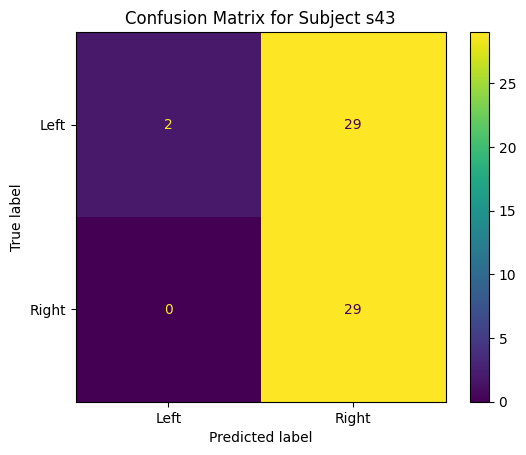

Classification accuracy: 51.67%
Weighted F1-score: 0.38

Classification Report:
               precision    recall  f1-score   support

        Left       1.00      0.06      0.12        31
       Right       0.50      1.00      0.67        29

    accuracy                           0.52        60
   macro avg       0.75      0.53      0.39        60
weighted avg       0.76      0.52      0.38        60

Processing subject: s44


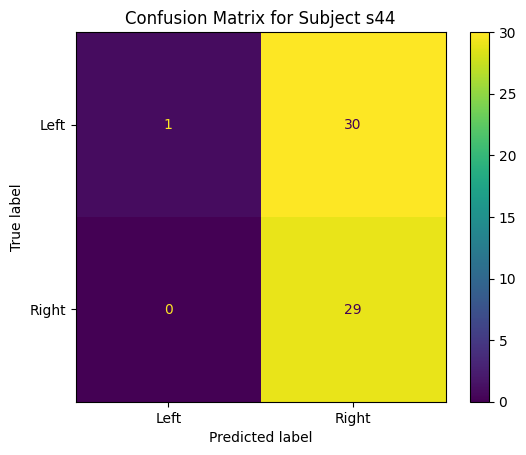

Classification accuracy: 50.00%
Weighted F1-score: 0.35

Classification Report:
               precision    recall  f1-score   support

        Left       1.00      0.03      0.06        31
       Right       0.49      1.00      0.66        29

    accuracy                           0.50        60
   macro avg       0.75      0.52      0.36        60
weighted avg       0.75      0.50      0.35        60

Processing subject: s46


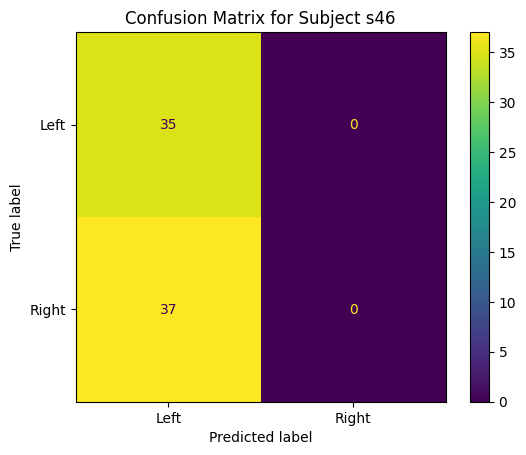

Classification accuracy: 48.61%
Weighted F1-score: 0.32

Classification Report:
               precision    recall  f1-score   support

        Left       0.49      1.00      0.65        35
       Right       0.00      0.00      0.00        37

    accuracy                           0.49        72
   macro avg       0.24      0.50      0.33        72
weighted avg       0.24      0.49      0.32        72

Processing subject: s48


c:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


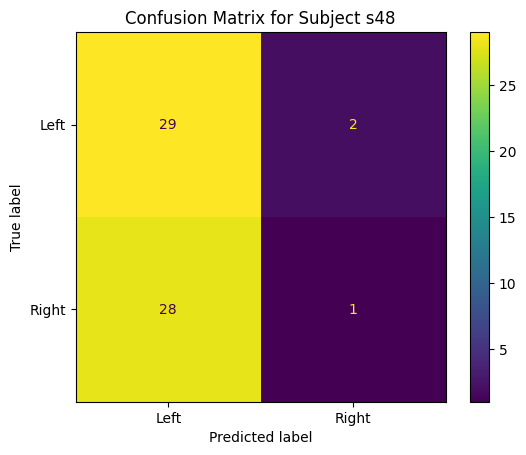

Classification accuracy: 50.00%
Weighted F1-score: 0.37

Classification Report:
               precision    recall  f1-score   support

        Left       0.51      0.94      0.66        31
       Right       0.33      0.03      0.06        29

    accuracy                           0.50        60
   macro avg       0.42      0.48      0.36        60
weighted avg       0.42      0.50      0.37        60

Processing subject: s49


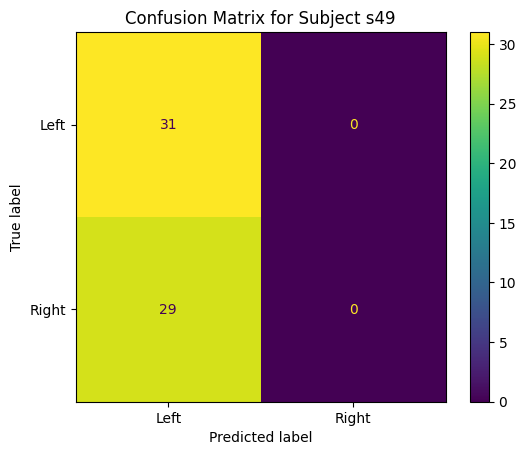

Classification accuracy: 51.67%
Weighted F1-score: 0.35

Classification Report:
               precision    recall  f1-score   support

        Left       0.52      1.00      0.68        31
       Right       0.00      0.00      0.00        29

    accuracy                           0.52        60
   macro avg       0.26      0.50      0.34        60
weighted avg       0.27      0.52      0.35        60

Processing subject: s50


c:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


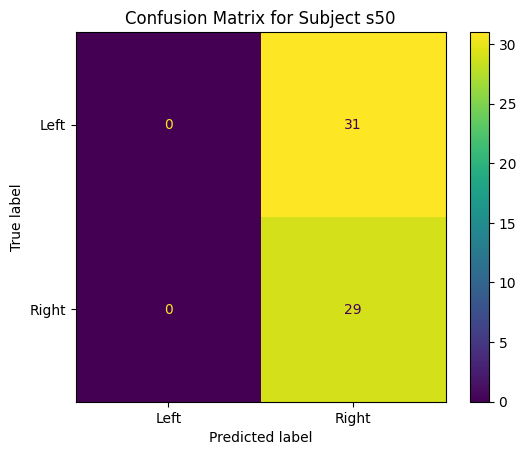

Classification accuracy: 48.33%
Weighted F1-score: 0.31

Classification Report:
               precision    recall  f1-score   support

        Left       0.00      0.00      0.00        31
       Right       0.48      1.00      0.65        29

    accuracy                           0.48        60
   macro avg       0.24      0.50      0.33        60
weighted avg       0.23      0.48      0.31        60

Processing subject: s52


c:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


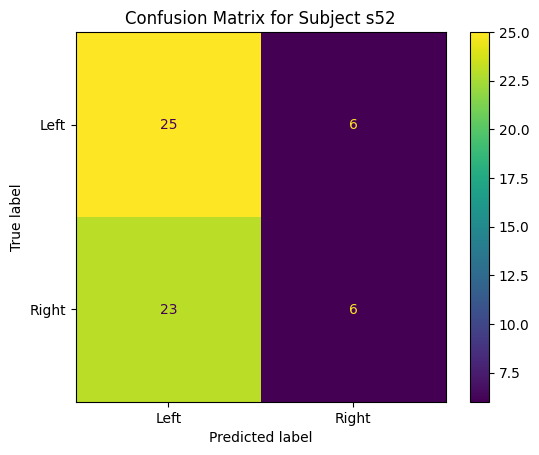

Classification accuracy: 51.67%
Weighted F1-score: 0.47

Classification Report:
               precision    recall  f1-score   support

        Left       0.52      0.81      0.63        31
       Right       0.50      0.21      0.29        29

    accuracy                           0.52        60
   macro avg       0.51      0.51      0.46        60
weighted avg       0.51      0.52      0.47        60



In [26]:
# Dictionary to store classification accuracy for each subject
classification_results = {}

# Iterate over each subject's EEG data and perform classification
for subject, eeg_data_list in filtered_data_after_bad_trial_removal.items():
    print(f"Processing subject: {subject}")

    # Convert each trial's RawArray to numpy and check consistency
    processed_data = []
    for trial_data in eeg_data_list:
        # Convert RawArray to numpy
        trial_numpy = trial_data.get_data()
        
        # Ensure all trials have the same shape
        if processed_data and trial_numpy.shape != processed_data[0].shape:
            # Adjust shape by truncating or padding
            min_shape = (processed_data[0].shape[0], min(processed_data[0].shape[1], trial_numpy.shape[1]))
            adjusted_trial = np.zeros(processed_data[0].shape)
            adjusted_trial[:, :min_shape[1]] = trial_numpy[:, :min_shape[1]]
            processed_data.append(adjusted_trial)
        else:
            processed_data.append(trial_numpy)

    # Convert processed data to a consistent 3D array
    X = np.stack(processed_data)  # Shape should be (n_trials, n_channels, n_times)
    y = labels_per_subject[subject]  # Corresponding labels for this subject

    # Check shape consistency
    if X.shape[0] != len(y):
        print(f"Mismatch in trial counts for subject {subject}. X shape: {X.shape}, y length: {len(y)}")
        continue

    # 특징 추출
    X_features = extract_wavelet_features(X)

    # Step 2: Perform 7:3 train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.3, random_state=42)

    # Step 3: Classification using SGD
    model = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Step 4: Compute and display the confusion matrix for the subject
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Left', 'Right'])
    disp.plot()
    plt.title(f"Confusion Matrix for Subject {subject}")
    plt.show()

    # Step 5: Calculate and store classification accuracy for this subject
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Classification accuracy: {accuracy * 100:.2f}%")
    
    # F1-score 계산 및 출력
    f1 = f1_score(y_test, y_pred, average='weighted')  # 'weighted'는 클래스 불균형이 있을 때 사용, 'macro'는 각 클래스에 동일한 가중치 부여
    print(f"Weighted F1-score: {f1:.2f}")
    
    # 클래스별 Precision, Recall, F1-score 및 Accuracy 등 출력
    report = classification_report(y_test, y_pred, target_names=['Left', 'Right'])
    print("\nClassification Report:\n", report)


#### **Multi Layer Perception**

Processing subject: s01


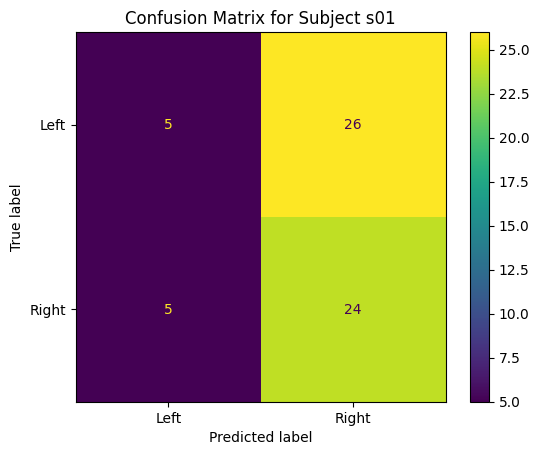

Classification accuracy: 48.33%
Weighted F1-score: 0.42

Classification Report:
               precision    recall  f1-score   support

        Left       0.50      0.16      0.24        31
       Right       0.48      0.83      0.61        29

    accuracy                           0.48        60
   macro avg       0.49      0.49      0.43        60
weighted avg       0.49      0.48      0.42        60

Processing subject: s03


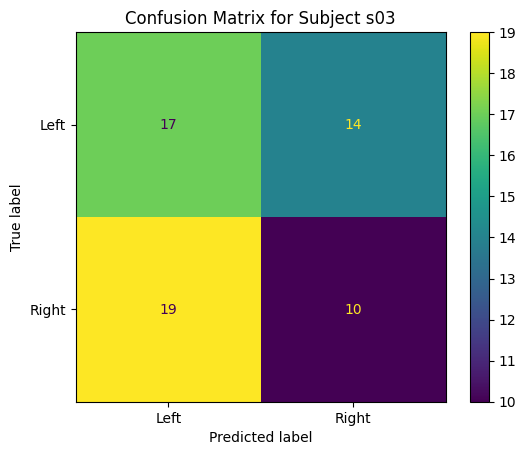

Classification accuracy: 45.00%
Weighted F1-score: 0.44

Classification Report:
               precision    recall  f1-score   support

        Left       0.47      0.55      0.51        31
       Right       0.42      0.34      0.38        29

    accuracy                           0.45        60
   macro avg       0.44      0.45      0.44        60
weighted avg       0.45      0.45      0.44        60

Processing subject: s04


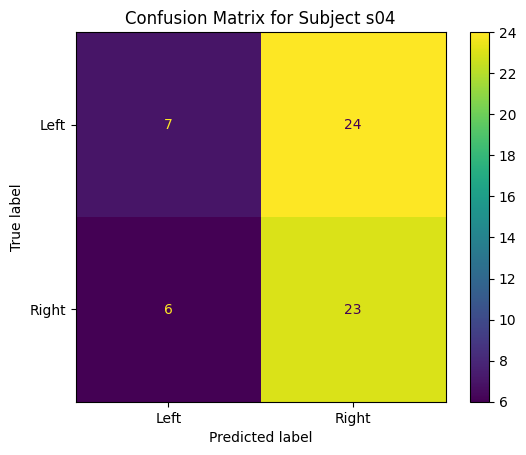

Classification accuracy: 50.00%
Weighted F1-score: 0.46

Classification Report:
               precision    recall  f1-score   support

        Left       0.54      0.23      0.32        31
       Right       0.49      0.79      0.61        29

    accuracy                           0.50        60
   macro avg       0.51      0.51      0.46        60
weighted avg       0.51      0.50      0.46        60

Processing subject: s05


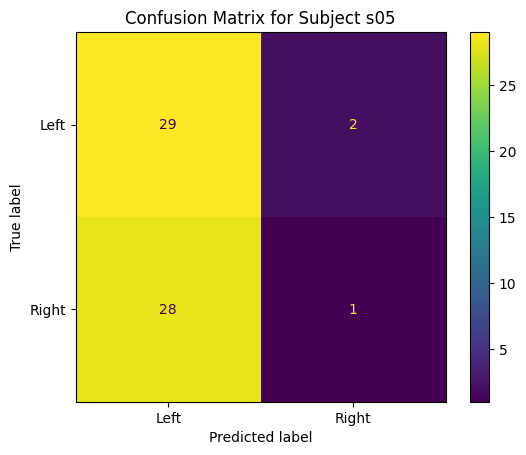

Classification accuracy: 50.00%
Weighted F1-score: 0.37

Classification Report:
               precision    recall  f1-score   support

        Left       0.51      0.94      0.66        31
       Right       0.33      0.03      0.06        29

    accuracy                           0.50        60
   macro avg       0.42      0.48      0.36        60
weighted avg       0.42      0.50      0.37        60

Processing subject: s06


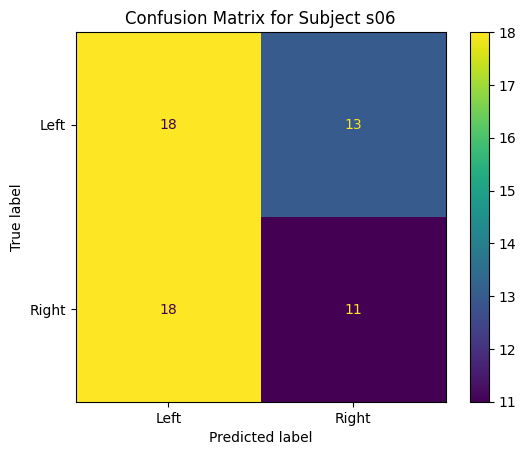

Classification accuracy: 48.33%
Weighted F1-score: 0.48

Classification Report:
               precision    recall  f1-score   support

        Left       0.50      0.58      0.54        31
       Right       0.46      0.38      0.42        29

    accuracy                           0.48        60
   macro avg       0.48      0.48      0.48        60
weighted avg       0.48      0.48      0.48        60

Processing subject: s09


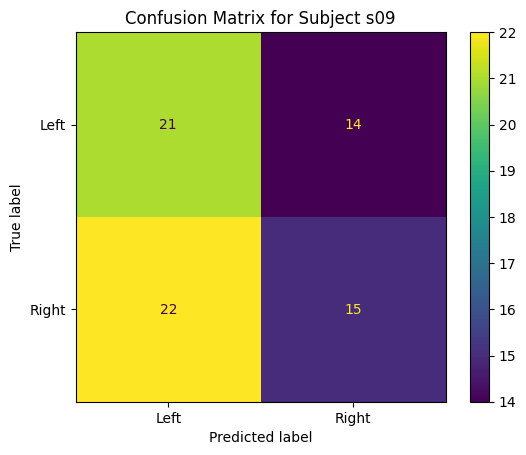

Classification accuracy: 50.00%
Weighted F1-score: 0.50

Classification Report:
               precision    recall  f1-score   support

        Left       0.49      0.60      0.54        35
       Right       0.52      0.41      0.45        37

    accuracy                           0.50        72
   macro avg       0.50      0.50      0.50        72
weighted avg       0.50      0.50      0.50        72

Processing subject: s10


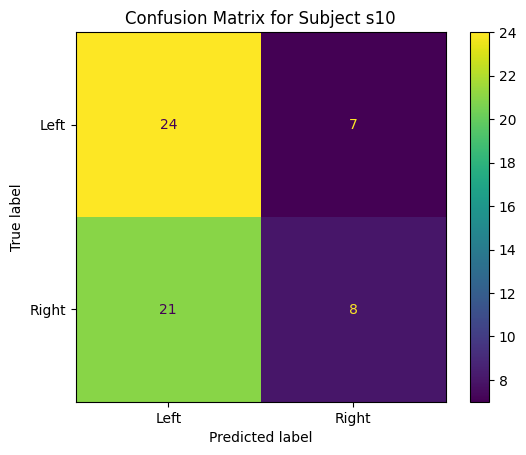

Classification accuracy: 53.33%
Weighted F1-score: 0.50

Classification Report:
               precision    recall  f1-score   support

        Left       0.53      0.77      0.63        31
       Right       0.53      0.28      0.36        29

    accuracy                           0.53        60
   macro avg       0.53      0.53      0.50        60
weighted avg       0.53      0.53      0.50        60

Processing subject: s13


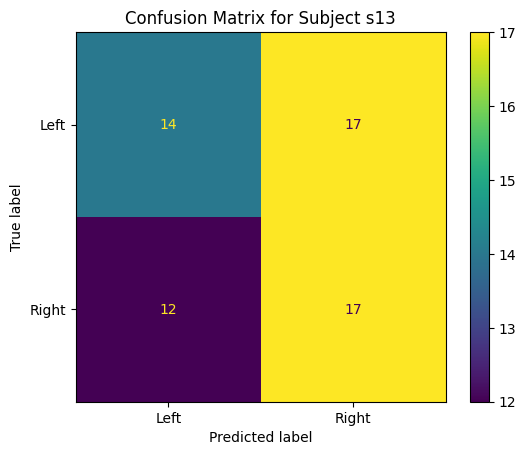

Classification accuracy: 51.67%
Weighted F1-score: 0.51

Classification Report:
               precision    recall  f1-score   support

        Left       0.54      0.45      0.49        31
       Right       0.50      0.59      0.54        29

    accuracy                           0.52        60
   macro avg       0.52      0.52      0.52        60
weighted avg       0.52      0.52      0.51        60

Processing subject: s14


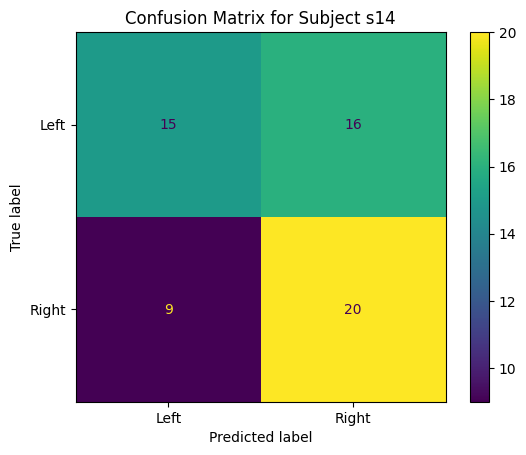

Classification accuracy: 58.33%
Weighted F1-score: 0.58

Classification Report:
               precision    recall  f1-score   support

        Left       0.62      0.48      0.55        31
       Right       0.56      0.69      0.62        29

    accuracy                           0.58        60
   macro avg       0.59      0.59      0.58        60
weighted avg       0.59      0.58      0.58        60

Processing subject: s33


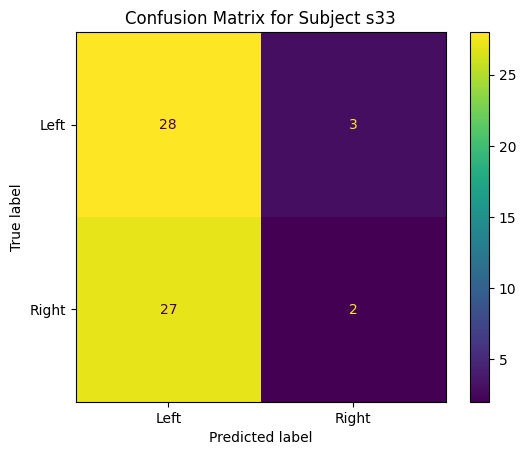

Classification accuracy: 50.00%
Weighted F1-score: 0.39

Classification Report:
               precision    recall  f1-score   support

        Left       0.51      0.90      0.65        31
       Right       0.40      0.07      0.12        29

    accuracy                           0.50        60
   macro avg       0.45      0.49      0.38        60
weighted avg       0.46      0.50      0.39        60

Processing subject: s35


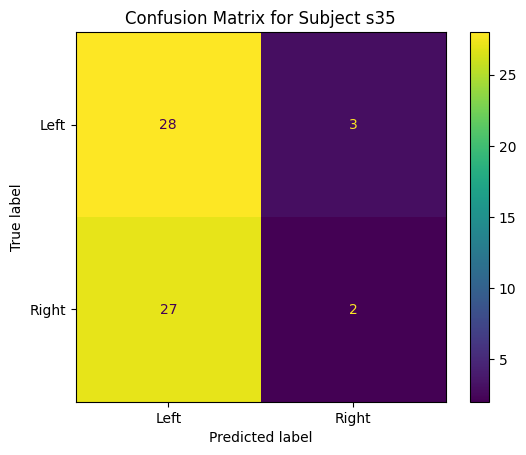

Classification accuracy: 50.00%
Weighted F1-score: 0.39

Classification Report:
               precision    recall  f1-score   support

        Left       0.51      0.90      0.65        31
       Right       0.40      0.07      0.12        29

    accuracy                           0.50        60
   macro avg       0.45      0.49      0.38        60
weighted avg       0.46      0.50      0.39        60

Processing subject: s41


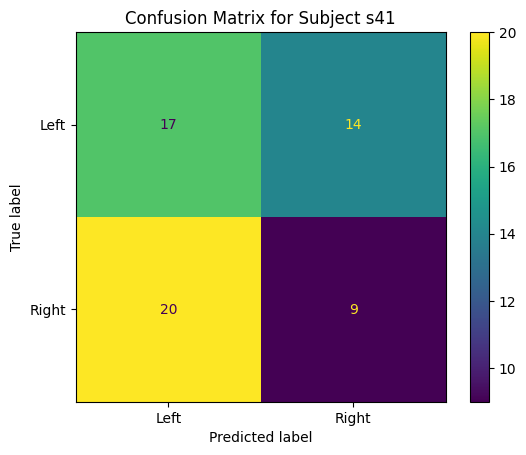

Classification accuracy: 43.33%
Weighted F1-score: 0.43

Classification Report:
               precision    recall  f1-score   support

        Left       0.46      0.55      0.50        31
       Right       0.39      0.31      0.35        29

    accuracy                           0.43        60
   macro avg       0.43      0.43      0.42        60
weighted avg       0.43      0.43      0.43        60

Processing subject: s43


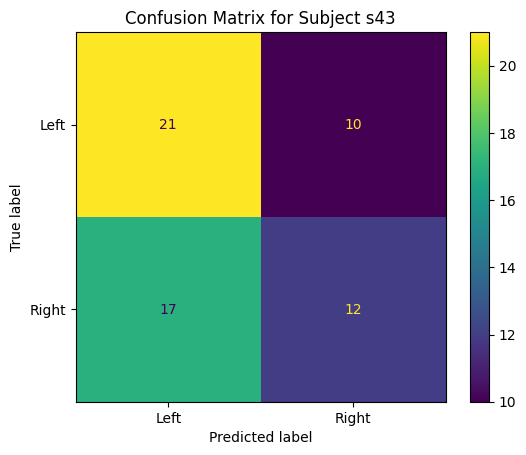

Classification accuracy: 55.00%
Weighted F1-score: 0.54

Classification Report:
               precision    recall  f1-score   support

        Left       0.55      0.68      0.61        31
       Right       0.55      0.41      0.47        29

    accuracy                           0.55        60
   macro avg       0.55      0.55      0.54        60
weighted avg       0.55      0.55      0.54        60

Processing subject: s44


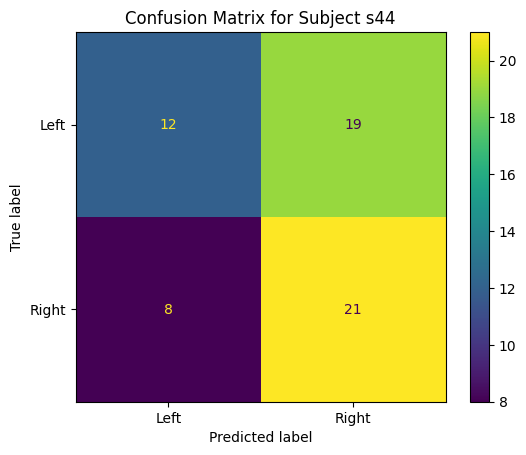

Classification accuracy: 55.00%
Weighted F1-score: 0.54

Classification Report:
               precision    recall  f1-score   support

        Left       0.60      0.39      0.47        31
       Right       0.53      0.72      0.61        29

    accuracy                           0.55        60
   macro avg       0.56      0.56      0.54        60
weighted avg       0.56      0.55      0.54        60

Processing subject: s46


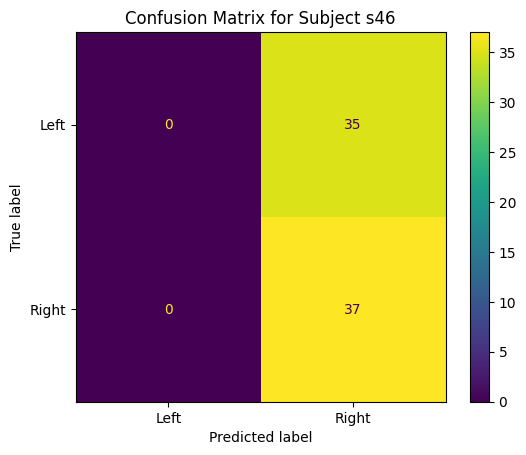

Classification accuracy: 51.39%
Weighted F1-score: 0.35

Classification Report:
               precision    recall  f1-score   support

        Left       0.00      0.00      0.00        35
       Right       0.51      1.00      0.68        37

    accuracy                           0.51        72
   macro avg       0.26      0.50      0.34        72
weighted avg       0.26      0.51      0.35        72

Processing subject: s48


c:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


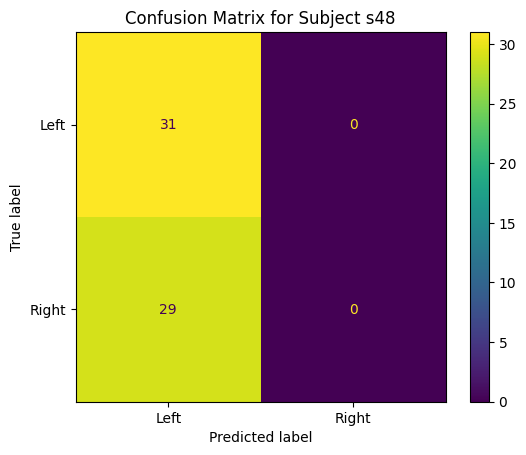

Classification accuracy: 51.67%
Weighted F1-score: 0.35

Classification Report:
               precision    recall  f1-score   support

        Left       0.52      1.00      0.68        31
       Right       0.00      0.00      0.00        29

    accuracy                           0.52        60
   macro avg       0.26      0.50      0.34        60
weighted avg       0.27      0.52      0.35        60

Processing subject: s49


c:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


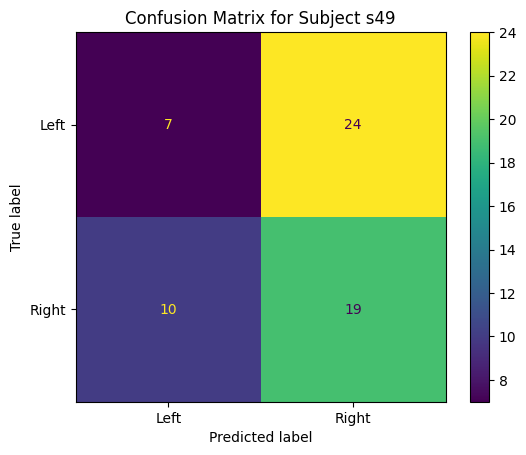

Classification accuracy: 43.33%
Weighted F1-score: 0.41

Classification Report:
               precision    recall  f1-score   support

        Left       0.41      0.23      0.29        31
       Right       0.44      0.66      0.53        29

    accuracy                           0.43        60
   macro avg       0.43      0.44      0.41        60
weighted avg       0.43      0.43      0.41        60

Processing subject: s50


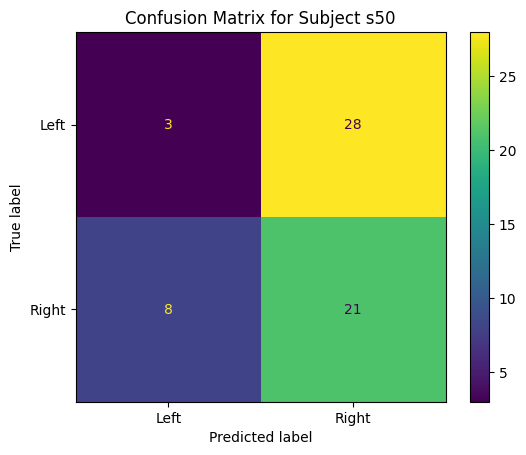

Classification accuracy: 40.00%
Weighted F1-score: 0.33

Classification Report:
               precision    recall  f1-score   support

        Left       0.27      0.10      0.14        31
       Right       0.43      0.72      0.54        29

    accuracy                           0.40        60
   macro avg       0.35      0.41      0.34        60
weighted avg       0.35      0.40      0.33        60

Processing subject: s52


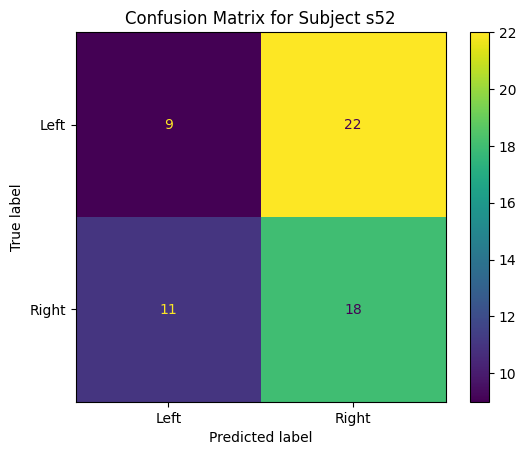

Classification accuracy: 45.00%
Weighted F1-score: 0.43

Classification Report:
               precision    recall  f1-score   support

        Left       0.45      0.29      0.35        31
       Right       0.45      0.62      0.52        29

    accuracy                           0.45        60
   macro avg       0.45      0.46      0.44        60
weighted avg       0.45      0.45      0.43        60



In [27]:
# Dictionary to store classification accuracy for each subject
classification_results = {}

# Iterate over each subject's EEG data and perform classification
for subject, eeg_data_list in filtered_data_after_bad_trial_removal.items():
    print(f"Processing subject: {subject}")

    # Convert each trial's RawArray to numpy and check consistency
    processed_data = []
    for trial_data in eeg_data_list:
        # Convert RawArray to numpy
        trial_numpy = trial_data.get_data()
        
        # Ensure all trials have the same shape
        if processed_data and trial_numpy.shape != processed_data[0].shape:
            # Adjust shape by truncating or padding
            min_shape = (processed_data[0].shape[0], min(processed_data[0].shape[1], trial_numpy.shape[1]))
            adjusted_trial = np.zeros(processed_data[0].shape)
            adjusted_trial[:, :min_shape[1]] = trial_numpy[:, :min_shape[1]]
            processed_data.append(adjusted_trial)
        else:
            processed_data.append(trial_numpy)

    # Convert processed data to a consistent 3D array
    X = np.stack(processed_data)  # Shape should be (n_trials, n_channels, n_times)
    y = labels_per_subject[subject]  # Corresponding labels for this subject

    # Check shape consistency
    if X.shape[0] != len(y):
        print(f"Mismatch in trial counts for subject {subject}. X shape: {X.shape}, y length: {len(y)}")
        continue

    # 특징 추출
    X_features = extract_wavelet_features(X)

    # Step 2: Perform 7:3 train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.3, random_state=42)

    # Step 3: Classification using MLP
    model = MLPClassifier(random_state=42, max_iter=500, hidden_layer_sizes=(100,))
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Step 4: Compute and display the confusion matrix for the subject
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Left', 'Right'])
    disp.plot()
    plt.title(f"Confusion Matrix for Subject {subject}")
    plt.show()

    # Step 5: Calculate and store classification accuracy for this subject
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Classification accuracy: {accuracy * 100:.2f}%")
    
    # F1-score 계산 및 출력
    f1 = f1_score(y_test, y_pred, average='weighted')  # 'weighted'는 클래스 불균형이 있을 때 사용, 'macro'는 각 클래스에 동일한 가중치 부여
    print(f"Weighted F1-score: {f1:.2f}")
    
    # 클래스별 Precision, Recall, F1-score 및 Accuracy 등 출력
    report = classification_report(y_test, y_pred, target_names=['Left', 'Right'])
    print("\nClassification Report:\n", report)


#### **Wavelet Transform 시각화**

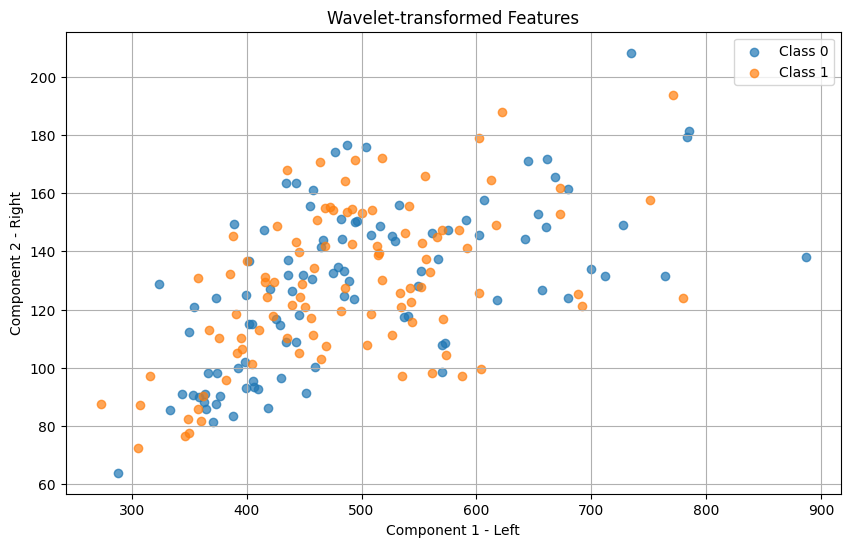

In [28]:
import matplotlib.pyplot as plt

# CSP 적용 후 변환된 데이터 (X_csp)와 레이블 (y)
# X_csp는 n_trials x n_components 크기의 배열이며, y는 각 trial의 클래스 레이블입니다.

# 첫 번째와 두 번째 주성분을 추출하여 시각화
plt.figure(figsize=(10, 6))
for label in np.unique(y):  # 각 클래스에 대해 다른 색으로 표시
    plt.scatter(
        X_features[y == label, 0],  # 첫 번째 주성분
        X_features[y == label, 1],  # 두 번째 주성분
        label=f'Class {label}',
        alpha=0.7
    )

plt.title("Wavelet-transformed Features")
plt.xlabel("Component 1 - Left")
plt.ylabel("Component 2 - Right")
plt.legend()
plt.grid(True)
plt.show()

In [24]:
X_features.shape

(200, 256)